In [1]:
!pip install perceval-quandela merlinquantum

In [2]:
import torch, torch.nn as nn
import merlin as ML
import shutil
import json
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import RandomSampler, DataLoader
from tqdm import tqdm
import perceval as pcvl
import sys; sys.path.insert(0, '..')
import pandas as pd
from models.qgan import QGAN
from helpers.digits import DigitsDataset
#from torch.utils.data import Dataset
from pathlib import Path
import re
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from helpers.pqc import ParametrizedQuantumCircuit
import math

In [3]:
EPS = 1e-6

class MerlinPatchGenerator(nn.Module):
    def __init__(
        self,
        image_size,
        gen_count,
        gen_arch,
        input_state,
        noise_dim,
        pnr,
        lossy,
        shots=3000,
        use_clements=False,
    ):
        super().__init__()
        self.image_size  = int(image_size)
        self.gen_count   = int(gen_count)
        self.noise_dim   = int(noise_dim)
        assert (self.image_size * self.image_size) % self.gen_count == 0, \
            "image_size^2 must be divisible by gen_count"
        self.pixels_per_patch = (self.image_size * self.image_size) // self.gen_count

        # Perceval state
        self.input_state = pcvl.BasicState(input_state) if not hasattr(input_state, "m") else input_state

        # circuit template from pqc.py architecture
        n_modes  = self.input_state.m if hasattr(self.input_state, "m") else len(self.input_state)
        template = ParametrizedQuantumCircuit(n_modes, gen_arch, use_clements).circuit

        # number of enc[...] params must equal noise_dim (per patch)
        enc_params = [p for p in template.get_parameters() if "enc" in getattr(p, "name", "")]
        if len(enc_params) != self.noise_dim:
            raise ValueError(
                f"noise_dim ({self.noise_dim}) must equal number of enc[...] params in circuit ({len(enc_params)})."
            )

        # Merlin sampling
        layer_shots = 0 if not lossy else shots

        class _ClampQL(nn.Module):
            #Clamp QuantumLayer inputs to (EPS, 1-EPS)
            def __init__(self, ql):
                super().__init__()
                self.ql = ql
            def forward(self, x):
                x = torch.nan_to_num(x, nan=0.0, posinf=1.0, neginf=0.0)
                x = torch.clamp(x, EPS, 1.0 - EPS)
                return self.ql(x)

        class _TrainableQL(nn.Module):
            
            #Trainable wrapper that *pushes the actual tensor* of angles into the quantum layer.
            #Falls back to float mapping if the backend doesn't accept tensors (prints once).
            
            def __init__(self, circuit_template, input_state, noise_dim, shots, no_bunching):
                super().__init__()
                self.circuit = circuit_template.copy()
                self.ql = ML.QuantumLayer(
                    input_size=noise_dim,
                    circuit=self.circuit,
                    input_state=input_state,
                    trainable_parameters=["phi", "psi", "theta"],
                    input_parameters=["enc"],
                    output_mapping_strategy=ML.OutputMappingStrategy.NONE,
                    shots=shots,
                    no_bunching=no_bunching,
                )

                # Collect trainable parameter names and initial values
                names, vals = [], []
                for p in self.circuit.get_parameters():
                    pname = getattr(p, "name", "")
                    if any(k in pname for k in ("phi", "psi", "theta")):
                        names.append(pname)
                        try:
                            vals.append(float(getattr(p, "value", 0.0)))
                        except Exception:
                            vals.append(0.0)
                if len(names) == 0:
                    names = ["theta_dummy"]
                    vals  = [0.0]

                self.param_names = names
                self.theta = nn.Parameter(torch.tensor(vals, dtype=torch.float32))

                self.clamped_ql = _ClampQL(self.ql)
                self._warned_detach = False

            def _apply_params_tensor_first(self, theta_tensor: torch.Tensor):
                
                if hasattr(self.ql, "set_params_tensor"):
                    self.ql.set_params_tensor(theta_tensor, names=self.param_names)
                    return True
                if hasattr(self.ql, "set_parameter_tensors"):
                    self.ql.set_parameter_tensors({n: t for n, t in zip(self.param_names, theta_tensor)})
                    return True
                # Dict of tensors (some versions accept torch tensors in set_parameter_values)
                try:
                    self.ql.set_parameter_values({n: t for n, t in zip(self.param_names, theta_tensor)})
                    return True
                except Exception:
                    pass
                try:
                    self.circuit.set_parameters({n: t for n, t in zip(self.param_names, theta_tensor)})
                    return True
                except Exception:
                    pass
                if hasattr(self.ql, "ansatz"):
                    try:
                        self.ql.ansatz.set_parameters({n: t for n, t in zip(self.param_names, theta_tensor)})
                        return True
                    except Exception:
                        pass
                return False

            def _push(self):



                """
                Push the trainable vector into the quantum layer.
                Tries tensor path first; if unsupported, falls back to floats (no grad through circuit).
                """


                theta = self.theta  # keep as tensor (no detach, no no_grad)
                ok = self._apply_params_tensor_first(theta)
                if ok:
                    return
                # Fallback: convert to float (non-differentiable through circuit params)
                mapping_float = {n: float(v.item()) for n, v in zip(self.param_names, theta)}
                pushed = False
                for fn in ("set_parameter_values",):
                    if hasattr(self.ql, fn):
                        try:
                            getattr(self.ql, fn)(mapping_float)
                            pushed = True
                            break
                        except Exception:
                            pass
                if not pushed:
                    try:
                        self.circuit.set_parameters(mapping_float)
                        pushed = True
                    except Exception:
                        pass
                if not pushed and hasattr(self.ql, "ansatz"):
                    try:
                        self.ql.ansatz.set_parameters(mapping_float)
                        pushed = True
                    except Exception:
                        pass
                if pushed and not self._warned_detach:
                    print("[Note] QuantumLayer did not accept tensors; fell back to float mapping. "
                          "Autograd will NOT flow through circuit parameters.")
                    self._warned_detach = True

            def forward(self, x):
                self._push()
                return self.clamped_ql(x)

        self.layers = nn.ModuleList([
            _TrainableQL(
                circuit_template=template,
                input_state=self.input_state,
                noise_dim=self.noise_dim,
                shots=layer_shots,
                no_bunching=(not pnr),
            )
            for _ in range(self.gen_count)
        ])

        # One head per patch; LazyLinear autosizes to [q_out || latent]
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.LazyLinear(3 * self.pixels_per_patch),
                nn.GELU(),
                nn.Linear(3 * self.pixels_per_patch, self.pixels_per_patch),
            )
            for _ in range(self.gen_count)
        ])

    def forward(self, z):
        # sanitize & map latent into (0,1) strictly
        if not torch.is_tensor(z):
            z = torch.as_tensor(z)
        z = torch.nan_to_num(z, nan=0.0, posinf=6.0, neginf=-6.0)
        z01 = torch.sigmoid(z)                 # (0,1)
        z01 = z01.mul_(1 - 2*EPS).add_(EPS)    # (EPS, 1-EPS)

        B, L = z01.shape
        expected = self.noise_dim * self.gen_count
        if L != expected:
            raise ValueError(
                f"latent dim {L} != noise_dim*gen_count ({expected}). "
                f"Sample z with shape (B, {expected})."
            )

        # exact split into gen_count parts of size noise_dim
        parts = z01.view(B, self.gen_count, self.noise_dim).unbind(dim=1)  # list[(B, noise_dim)]

        patches = []
        for layer, head, zi in zip(self.layers, self.heads, parts):
            zi = torch.clamp(torch.nan_to_num(zi, nan=0.0, posinf=1.0, neginf=0.0), EPS, 1.0 - EPS)
            q_out = layer(zi)                        # (B, q_dim)
            h     = torch.cat([q_out, zi], dim=1)    # latent skip
            patches.append(head(h))                  # (B, pixels_per_patch)

        img_flat = torch.cat(patches, dim=1)        # (B, H*W)
        x = torch.sigmoid(img_flat)                  # soft squash (0,1)

        # Per-image min–max normalization (robust, avoids black/flat)
        x_min = x.amin(dim=1, keepdim=True)
        x_max = x.amax(dim=1, keepdim=True)
        span  = (x_max - x_min)

        x_norm = (x - x_min) / span.clamp_min(EPS)

        tol = 1e-3
        is_flat = (span < tol)
        if is_flat.any():
            x_center = x - x.mean(dim=1, keepdim=True)
            std = x_center.std(dim=1, keepdim=True).clamp_min(EPS)
            x_boost = (x_center / std) * 0.15 + 0.5
            x_boost = x_boost.clamp(0.0, 1.0)
            out = torch.where(is_flat, x_boost, x_norm)
        else:
            out = x_norm
            out = out.clamp(0.0, 1.0)
            out = 2.0*out - 1.0  # to (-1, 1)

        return out

    def generate(self, noise):
        with torch.no_grad():
            return self.forward(noise)

In [4]:
class MerlinDiscriminator(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(64, 64), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.1),
            nn.Linear(64, 32), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.1),
            nn.Linear(32, 1) 
        )

    def forward(self, x):
        if x.dim() == 4:  # (B,1,8,8)
            x = x.view(x.size(0), -1)
        return self.net(x).view(-1)  # logits

In [21]:
class QGAN:
    def __init__(self, image_size, gen_count, gen_arch, input_state, noise_dim, batch_size, pnr, lossy):
        self.image_size = image_size
        self.gen_count = gen_count
        self.noise_dim = max(1, int(noise_dim))
        self.latent_dim = self.noise_dim * max(1, int(gen_count))
        self.batch_size = int(batch_size)

        # Generator & Discriminator
        self.G = MerlinPatchGenerator(
            image_size=image_size,
            gen_count=gen_count,
            gen_arch=gen_arch,
            input_state=pcvl.BasicState(input_state) if not hasattr(input_state, "m") else input_state,
            noise_dim=noise_dim,
            pnr=pnr,
            lossy=lossy,
            shots=3000,
            use_clements=False,
        )
        self.D = MerlinDiscriminator(image_size=image_size)  # logits

        # Opts (set during fit)
        self.optG = None
        self.optD = None

        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.G.to(self.device)
        self.D.to(self.device)

        # Warm-up once to initialize any Lazy* params BEFORE counting
        with torch.no_grad():
            _ = self.G(torch.zeros(1, self.latent_dim, device=self.device))
            _ = self.D(torch.zeros(1, self.image_size * self.image_size, device=self.device))

        # Safe parameter count
        def _count_params(m):
            total = 0
            for p in m.parameters():
                if not getattr(p, "requires_grad", False):
                    continue
                try:
                    total += p.numel()
                except Exception:
                    continue
            return total

        print(f"Generator trainable params: {_count_params(self.G)}")
        print(f"Discriminator trainable params: {_count_params(self.D)}")

    # always return a non-empty trainable vector for logging
    def _get_trainable_vector(self):
        vecs = []
        if hasattr(self.G, "layers"):
            for layer in self.G.layers:
                t = getattr(layer, "theta", None)
                if isinstance(t, torch.Tensor):
                    vecs.append(t.view(-1))
        if vecs:
            return torch.cat(vecs)

        params = [p.view(-1) for p in self.G.parameters() if isinstance(p, torch.Tensor) and p.requires_grad]
        if params:
            return torch.cat(params)

        return torch.zeros(1, device=self.device)

    def fit(self, dataloader, lrD, opt_params, silent=False):

        def _save_grid(batch_flat: torch.Tensor, step: int, outdir: str = "samples"):
            N = batch_flat.shape[0]
            H = W = self.image_size
            imgs01 = ((batch_flat.clamp(-1, 1) + 1.0) / 2.0).detach().cpu().view(N, H, W).numpy()

            ncols = min(8, N)
            nrows = math.ceil(N / ncols)
            fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 1.2, nrows * 1.2))
            axes = np.atleast_1d(axes).ravel()
            for i in range(nrows * ncols):
                ax = axes[i]
                ax.axis("off")
                if i < N:
                    ax.imshow((imgs01[i] * 255).astype(np.uint8), cmap="gray", vmin=0, vmax=255)
            os.makedirs(outdir, exist_ok=True)
            fig.savefig(os.path.join(outdir, f"step_{step:04d}.png"), dpi=150, bbox_inches="tight", pad_inches=0)
            plt.close(fig)

        # Sanity: latent size must match
        expected = self.noise_dim * self.gen_count
        assert self.latent_dim == expected, f"[Sanity] latent_dim mismatch: {self.latent_dim} vs {expected}"

        # TTUR tweak
        self.optD = torch.optim.Adam(self.D.parameters(), lr=lrD * 0.08, betas=(0.5, 0.999))
        self.optG = torch.optim.Adam(self.G.parameters(), lr=lrD * 1.00, betas=(0.5, 0.999))

        # Make Merlin deterministic
        try:
            self.G.sample_count = 1
            if hasattr(self.G, "sampler"):
                self.G.sampler._iterator = []
        except Exception:
            pass

        total_steps = int(opt_params.get("opt_iter_num", 1500))
        steps_done = 0

        z_track = torch.randn(8, self.latent_dim, device=self.device)  # fixed latent batch
        prev_track = None



        D_loss_progress, G_loss_progress, G_params_progress, fake_data_progress = [], [], [], []

        pbar = dataloader if silent else tqdm(
            dataloader, total=total_steps, desc="Merlin-QGAN training", leave=False
        )

        last_loss_G, last_gen_for_log = None, None
        grad_nonzero_steps = 0

        # Fixed probe and fixed snapshot noise
        z_probe = torch.randn(self.batch_size, self.latent_dim, device=self.device)
        with torch.no_grad():
            probe_out_prev = self.G(z_probe).detach()

        # >>> FIXED LATENT NOISE VECTOR FOR SNAPSHOTS <<<
        z_fixed = torch.randn(16, self.latent_dim, device=self.device)

        first_logged = False
        r1_gamma = 1e-3

        for batch in pbar:
            # === Prepare real data ===
            real_imgs = batch[0] if isinstance(batch, (list, tuple)) else batch
            if real_imgs.dim() == 3:
                real_imgs = real_imgs.unsqueeze(1)
            real_imgs = real_imgs.to(self.device).float()

            with torch.no_grad():
                if real_imgs.max() > 1.0:
                    real_imgs.div_(255.0)

            real_flat = real_imgs.view(real_imgs.size(0), -1)
            B = real_flat.size(0)
# sanity check for generating images

            if steps_done %50 == 0:
                
                    with torch.no_grad():
                        cur_track = self.G(z_track).detach()
                    if prev_track is not None:
                        rmse = ((cur_track - prev_track)**2).mean().sqrt().item()
                        print(f"[Track] ΔRMSE since last checkpoint: {rmse:.6f}")
                        prev_track = cur_track

                
            # Instance noise
            real_noisy = real_flat + 0.05 * torch.randn_like(real_flat)

            # Log initial D scores
            if not first_logged:
                with torch.no_grad():
                    z0 = torch.randn(B, self.latent_dim, device=self.device)
                    f0 = self.G(z0)
                    d_real0 = self.D(real_flat).mean().item()
                    d_fake0 = self.D(f0).mean().item()
                    print(f"[Sanity] D logits at start: real={d_real0:.3f}, fake={d_fake0:.3f}")
                first_logged = True

                print("f0", f0)
                print("d_real0", d_real0)
                print("d_fake0", d_fake0)

            # === Train D ===
            self.optD.zero_grad()
            real_noisy.requires_grad_(True)
            real_logits = self.D(real_noisy)
            if real_logits.dim() == 1:
                real_logits = real_logits.unsqueeze(1)

            z = torch.randn(B, self.latent_dim, device=self.device)
            fake_flat = self.G(z).detach()
            if not torch.isfinite(fake_flat).all():
                fake_flat = torch.nan_to_num(fake_flat, nan=0.0, posinf=1.0, neginf=0.0).clamp(0.0, 1.0)

            fake_logits = self.D(fake_flat)
            if fake_logits.dim() == 1:
                fake_logits = fake_logits.unsqueeze(1)

            loss_D_main = F.softplus(-real_logits).mean() + F.softplus(fake_logits).mean()
            grad_real = torch.autograd.grad(
                outputs=real_logits.sum(), inputs=real_noisy,
                create_graph=True, retain_graph=True, only_inputs=True
            )[0]
            r1_penalty = (grad_real.pow(2).sum(dim=1).mean()) * (r1_gamma * 0.5)

            loss_D = loss_D_main + r1_penalty
            loss_D.backward()
            self.optD.step()

            # === Train G ===
            self.optG.zero_grad()
            z = torch.randn(B, self.latent_dim, device=self.device)
            gen_flat = self.G(z)

            if not torch.isfinite(gen_flat).all():
                gen_flat = torch.nan_to_num(gen_flat, nan=0.0, posinf=1.0, neginf=0.0).clamp(0.0, 1.0)

            gen_logits = self.D(gen_flat)
            if gen_logits.dim() == 1:
                gen_logits = gen_logits.unsqueeze(1)

            loss_G = F.softplus(-gen_logits).mean()
            loss_G.backward()

            nz = sum((p.grad.detach().abs().sum().item() if (p.requires_grad and p.grad is not None) else 0)
                     for p in self.G.parameters())
            if nz > 0:
                grad_nonzero_steps += 1

            torch.nn.utils.clip_grad_norm_(self.G.parameters(), 1.0)
            self.optG.step()
            last_loss_G = float(loss_G.detach().item())
            last_gen_for_log = gen_flat.detach()

            # Log probe drift
            if (steps_done % 5) == 0:
                with torch.no_grad():
                    g_mean, g_std = last_gen_for_log.mean().item(), last_gen_for_log.std().item()
                    probe_now = self.G(z_probe).detach()
                    drift = (probe_now - probe_out_prev).pow(2).mean().sqrt().item()
                print(f"[Sanity] step {steps_done}: gen mean={g_mean:.4f}, std={g_std:.4f}, probe_RMSE={drift:.6f}")
                probe_out_prev = probe_now

                #sanity checks for generating images

            if drift < 1e-4:
                  print(f"[Alert] Probe output barely changing (RMSE={drift:.2e}).")


            im = gen_flat.view(B, self.image_size, self.image_size)

            per_img_std  = im.float().flatten(1).std(dim=1)
            per_img_span = im.flatten(1).amax(dim=1) - im.flatten(1).amin(dim=1)

            flat_std  = (per_img_std  < 1e-3).sum().item()
            flat_span = (per_img_span < 1e-3).sum().item()

            print(f"[Check] flat-by-std: {flat_std}/{B}, flat-by-span: {flat_span}/{B}")

            # Logging
            D_loss_progress.append(loss_D.item())
            G_loss_progress.append(last_loss_G)
            with torch.no_grad():
                g_vec = self._get_trainable_vector().detach().float().cpu().numpy()
            G_params_progress.append(g_vec)
            fake_data_progress.append(last_gen_for_log.mean(0).detach().cpu().numpy())

            
            steps_done += 1
            if steps_done % 300 == 0:
                with torch.no_grad():
                    self.G.eval()
                    grid = self.G(z_fixed)
                    _save_grid(grid, steps_done, outdir="samples")
                    self.G.train()

            if steps_done >= total_steps:
                break

        print(f"[Sanity] Steps with non-zero G gradients: {grad_nonzero_steps}/{steps_done}")
        return D_loss_progress, G_loss_progress, G_params_progress, np.vstack(fake_data_progress)


In [25]:
# definitions and constants
image_size = 8
batch_size = 4
lossy = False
write_to_disk = True

# optimization params
#spsa_iter_num = 10500
opt_iter_num = 2000
lrD = 0.002
opt_params = {"opt_iter_num": opt_iter_num}

# define desired run configurations (kept for parity; not used by Merlin QGAN)
arch_grid_45modes = [
    {"noise_dim": 1, "arch": ["var", "enc[2]", "var"]},
    {"noise_dim": 1, "arch": ["var", "var", "enc[2]", "var", "var"]},
    {"noise_dim": 2, "arch": ["var", "enc[1]", "var", "enc[3]", "var"]},
    {"noise_dim": 2, "arch": ["var", "var", "enc[1]", "var", "var", "enc[3]", "var", "var"]},
]

input_grid_4modes = [
    {"input_state": [1, 1, 1, 1], "gen_count": 2, "pnr": True},
    {"input_state": [1, 1, 1, 1], "gen_count": 4, "pnr": False},
    {"input_state": [1, 0, 1, 1], "gen_count": 4, "pnr": True},
]

arch_grid_5modes = [{"noise_dim": 3, "arch": ["var", "enc[0]", "var", "enc[2]", "var", "enc[4]", "var"]}]

input_grid_5modes = [
    {"input_state": [0, 1, 0, 1, 0], "gen_count": 4, "pnr": False},
    {"input_state": [1, 0, 1, 0, 1], "gen_count": 2, "pnr": True},
]

arch_grid_8modes = [
    {"noise_dim": 1, "arch": ["var", "enc[4]", "var"]},
    {"noise_dim": 1, "arch": ["var", "var", "enc[4]", "var", "var"]},
    {"noise_dim": 2, "arch": ["var", "enc[2]", "var", "enc[5]", "var"]},
    {"noise_dim": 2, "arch": ["var", "var", "enc[2]", "var", "var", "enc[5]", "var", "var"]},
    {"noise_dim": 3, "arch": ["var", "enc[1]", "var", "enc[4]", "var", "enc[6]", "var"]},
    {"noise_dim": 4, "arch": ["var", "enc[1]", "var", "enc[3]", "var", "enc[5]", "var", "enc[7]", "var"]},
]

input_grid_8modes = [{"input_state": [0, 0, 1, 0, 0, 1, 0, 0], "gen_count": 2, "pnr": False}]

config_grid = []
for inp in input_grid_5modes:
    for arch in (arch_grid_45modes + arch_grid_5modes):
        config = inp.copy()
        config.update(arch)
        config_grid.append(config)

for inp in input_grid_4modes:
    for arch in arch_grid_45modes:
        config = inp.copy()
        config.update(arch)
        config_grid.append(config)

for inp in input_grid_8modes:
    for arch in arch_grid_8modes:
        config = inp.copy()
        config.update(arch)
        config_grid.append(config)


        config_grid = config_grid[:5]

# number of runs for each config combination
runs = 1

In [26]:
csv_path = "optdigits_csv (1).csv"
dataset = DigitsDataset(csv_file=csv_path)
sampler = RandomSampler(dataset, replacement=True, num_samples=batch_size * opt_iter_num)
dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True, sampler=sampler)

In [27]:
path = "./ideal_merlin_1/"
if os.path.isdir(path):
    shutil.rmtree(path)
os.makedirs(path, exist_ok=True)

for config_num, config in enumerate(tqdm(config_grid, desc="config", position=0, leave=False)):
    config_path = os.path.join(path, f"config_{config_num}")
    if os.path.isdir(config_path):
        continue
    os.makedirs(config_path, exist_ok=True)

    with open(os.path.join(config_path, "config.json"), "w") as f:
        f.write(json.dumps(config))

    gen_arch = config["arch"]
    noise_dim = config["noise_dim"]
    input_state = config["input_state"]
    pnr = config["pnr"]
    gen_count = config["gen_count"]

    run_num = 0
    for _ in tqdm(range(1000), desc="run", position=1, leave=False):
        if run_num == runs:
            break
        run_num += 1

        save_path = os.path.join(config_path, f"run_{run_num}")
        os.makedirs(save_path, exist_ok=True)
        try:
            qgan = QGAN(
                image_size,
                gen_count,
                gen_arch,
                input_state,      # kept for signature; Merlin ignores
                noise_dim,
                batch_size,
                pnr,
                lossy,
            )
            D_loss_progress, G_loss_progress, G_params_progress, fake_data_progress = qgan.fit(
                tqdm(dataloader, desc="iter", position=2, leave=False),
                lrD,
                opt_params,
                silent=True,
            )

            # Save results (same filenames as original, new parent dir)
            # fake_progress: take per-step batch means (64-dim)
            fake_rows = []
            for step_array in fake_data_progress:
                # step_array: (B, 64)
                arr = np.array(step_array)
                if arr.ndim == 2 and arr.shape[1] == 64:
                    fake_rows.append(arr.mean(axis=0))
                else:
                    fake_rows.append(np.zeros(64, dtype=np.float32))
            fake_rows = np.vstack(fake_rows)
            np.savetxt(os.path.join(save_path, "fake_progress.csv"), fake_rows, delimiter=",")

            np.savetxt(
                os.path.join(save_path, "loss_progress.csv"),
                np.array([D_loss_progress, G_loss_progress]).T,
                delimiter=",",
                header="D_loss, G_loss",
            )

            # Save generator parameter snapshots
            # store as object array to avoid huge files
            G_params_array = np.array(G_params_progress, dtype=object)
            np.save(os.path.join(save_path, "G_params_progress.npy"), G_params_array)

        except Exception as exc:
            print("[Merlin-QGAN] Error:", exc)
            shutil.rmtree(save_path)
            run_num -= 1

if __name__ == "__main__":
    pass

config:   0%|          | 0/5 [00:00<?, ?it/s]

Generator trainable params: 5648
Discriminator trainable params: 6273


[Sanity] D logits at start: real=-0.158, fake=-0.176
f0 tensor([[ 6.4590e-01, -1.0329e-01,  2.7394e-01, -8.1389e-02,  1.3462e-01,
          3.4429e-01,  2.2148e-01,  7.5135e-01,  5.5011e-02,  1.3056e-01,
         -1.9900e-01,  1.0000e+00, -6.1576e-01,  5.6212e-01,  1.9406e-01,
          8.0074e-02,  2.8466e-01,  2.4220e-01,  1.7332e-01, -1.3383e-01,
          6.2913e-01,  6.0485e-01, -1.9747e-01,  5.6139e-01,  4.1697e-01,
         -2.4738e-01,  6.8726e-01, -3.1047e-01, -8.9440e-02,  2.1584e-01,
         -5.8859e-01, -6.5610e-02,  1.6257e-01,  5.6143e-01, -7.6579e-02,
         -2.1874e-01,  4.5320e-01,  5.7072e-02,  2.7045e-01,  7.4007e-02,
          2.2265e-01, -3.6805e-01,  3.1430e-01, -1.8937e-01, -8.5413e-01,
          1.4518e-01, -1.7041e-01, -1.8447e-02, -1.0000e+00,  2.3576e-01,
         -1.9955e-02,  1.3281e-01,  5.5475e-01,  7.0374e-01, -4.9879e-01,
          8.4868e-01,  7.5082e-01,  2.6011e-01, -4.0917e-01, -5.3566e-01,
         -2.9123e-01, -7.5630e-02,  5.6362e-01,  3.4222e


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 5: gen mean=0.1689, std=0.4129, probe_RMSE=0.195283
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 10: gen mean=0.1894, std=0.4332, probe_RMSE=0.169132
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 15: gen mean=0.2073, std=0.5075, probe_RMSE=0.189069
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 20: gen mean=0.1472, std=0.5720, probe_RMSE=0.181136
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 25: gen mean=0.1665, std=0.5787, probe_RMSE=0.175086
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 30: gen mean=0.1845, std=0.5804, probe_RMSE=0.202596
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   2%|▏         | 31/2000 [00:01<01:49, 18.01it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 35: gen mean=0.2080, std=0.5826, probe_RMSE=0.187376
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 40: gen mean=0.1982, std=0.5883, probe_RMSE=0.177628
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 45: gen mean=0.1762, std=0.5787, probe_RMSE=0.146405
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   2%|▎         | 50/2000 [00:02<01:43, 18.79it/s]




[Sanity] step 50: gen mean=0.2356, std=0.5836, probe_RMSE=0.119238
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   3%|▎         | 55/2000 [00:03<01:44, 18.64it/s]



[Sanity] step 55: gen mean=0.2746, std=0.5755, probe_RMSE=0.155096
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 60: gen mean=0.2818, std=0.5743, probe_RMSE=0.095622
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 65: gen mean=0.2938, std=0.5536, probe_RMSE=0.092555
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 70: gen mean=0.3424, std=0.5375, probe_RMSE=0.120542
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 75: gen mean=0.3399, std=0.5046, probe_RMSE=0.104596
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 80: gen mean=0.3090, std=0.5327, probe_RMSE=0.155566
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 85: gen mean=0.2037, std=0.5969, probe_RMSE=0.153934
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 90: gen mean=0.1941, std=0.5938, probe_RMSE=0.126201
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4





iter:   5%|▍         | 99/2000 [00:05<01:50, 17.19it/s]

[Sanity] step 95: gen mean=0.2176, std=0.5646, probe_RMSE=0.099075
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 100: gen mean=0.2745, std=0.5319, probe_RMSE=0.141103
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   5%|▌         | 103/2000 [00:05<01:50, 17.18it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 105: gen mean=0.3675, std=0.4921, probe_RMSE=0.095958
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 110: gen mean=0.3833, std=0.4842, probe_RMSE=0.081982
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 115: gen mean=0.3935, std=0.4807, probe_RMSE=0.065188
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 120: gen mean=0.3591, std=0.4984, probe_RMSE=0.073287
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 125: gen mean=0.3468, std=0.5041, probe_RMSE=0.076355
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 130: gen mean=0.3141, std=0.5093, probe_RMSE=0.096111
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 135: gen mean=0.2829, std=0.5195, probe_RMSE=0.069717
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 140: gen mean=0.3105, std=0.5235, probe_RMSE=0.074243
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 145: gen mean=0.3812, std=0.4831, probe_RMSE=0.131502
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 150: gen mean=0.3609, std=0.4948, probe_RMSE=0.065370
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 155: gen mean=0.3273, std=0.4967, probe_RMSE=0.071893
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 160: gen mean=0.3298, std=0.5020, probe_RMSE=0.062333
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 165: gen mean=0.3467, std=0.4914, probe_RMSE=0.064408
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 170: gen mean=0.3623, std=0.4954, probe_RMSE=0.057983
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 175: gen mean=0.3515, std=0.4970, probe_RMSE=0.065813
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 180: gen mean=0.3296, std=0.5296, probe_RMSE=0.060128
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 185: gen mean=0.3197, std=0.5366, probe_RMSE=0.069122
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 190: gen mean=0.3097, std=0.5326, probe_RMSE=0.050033
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 195: gen mean=0.3133, std=0.5068, probe_RMSE=0.062467
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 200: gen mean=0.3271, std=0.5263, probe_RMSE=0.051228
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  10%|█         | 205/2000 [00:11<01:41, 17.71it/s]



[Sanity] step 205: gen mean=0.3257, std=0.5201, probe_RMSE=0.056145
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 210: gen mean=0.3273, std=0.5068, probe_RMSE=0.056891
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 215: gen mean=0.3350, std=0.5072, probe_RMSE=0.059041
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 220: gen mean=0.3571, std=0.4799, probe_RMSE=0.054063
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  11%|█         | 221/2000 [00:12<01:46, 16.65it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 225: gen mean=0.3755, std=0.4769, probe_RMSE=0.059584
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 230: gen mean=0.3811, std=0.4721, probe_RMSE=0.065776
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 235: gen mean=0.3588, std=0.4598, probe_RMSE=0.076264
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 240: gen mean=0.3321, std=0.4548, probe_RMSE=0.076425
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  12%|█▏        | 241/2000 [00:13<01:44, 16.78it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 245: gen mean=0.2948, std=0.4698, probe_RMSE=0.077187
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 250: gen mean=0.2501, std=0.4966, probe_RMSE=0.107552
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  13%|█▎        | 253/2000 [00:14<01:39, 17.52it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 255: gen mean=0.1913, std=0.5460, probe_RMSE=0.104289
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 260: gen mean=0.3660, std=0.4449, probe_RMSE=0.244799
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 265: gen mean=0.4561, std=0.4048, probe_RMSE=0.104024
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 270: gen mean=0.4445, std=0.4132, probe_RMSE=0.064555
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  14%|█▎        | 273/2000 [00:15<01:39, 17.28it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 275: gen mean=0.3343, std=0.4829, probe_RMSE=0.167807
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 280: gen mean=0.1888, std=0.5505, probe_RMSE=0.150872
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 285: gen mean=0.1404, std=0.5320, probe_RMSE=0.110172
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 290: gen mean=0.1949, std=0.5516, probe_RMSE=0.095716
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  15%|█▍        | 295/2000 [00:16<01:33, 18.25it/s]



[Sanity] step 295: gen mean=0.2278, std=0.5265, probe_RMSE=0.138437
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 300: gen mean=0.3040, std=0.5071, probe_RMSE=0.073972
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  15%|█▌        | 301/2000 [00:17<02:11, 12.88it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 305: gen mean=0.3094, std=0.5185, probe_RMSE=0.077985
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 310: gen mean=0.3797, std=0.4734, probe_RMSE=0.100766
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 315: gen mean=0.3675, std=0.4890, probe_RMSE=0.049338
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 320: gen mean=0.3748, std=0.4919, probe_RMSE=0.042799
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 325: gen mean=0.3782, std=0.4834, probe_RMSE=0.046960
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 330: gen mean=0.3717, std=0.4659, probe_RMSE=0.068665
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 335: gen mean=0.3658, std=0.4682, probe_RMSE=0.065691
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 340: gen mean=0.3382, std=0.4610, probe_RMSE=0.082442
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 345: gen mean=0.2854, std=0.4634, probe_RMSE=0.075232
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 350: gen mean=0.2725, std=0.4680, probe_RMSE=0.056043
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 355: gen mean=0.2220, std=0.4751, probe_RMSE=0.051520
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 360: gen mean=0.2500, std=0.4593, probe_RMSE=0.050265
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 365: gen mean=0.2573, std=0.4462, probe_RMSE=0.066300
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 370: gen mean=0.2913, std=0.4217, probe_RMSE=0.040128
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 375: gen mean=0.2590, std=0.4272, probe_RMSE=0.044291
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 380: gen mean=0.2669, std=0.4210, probe_RMSE=0.048089
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 385: gen mean=0.2697, std=0.4100, probe_RMSE=0.044927
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 390: gen mean=0.2516, std=0.4129, probe_RMSE=0.045775
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 395: gen mean=0.2292, std=0.4059, probe_RMSE=0.049588
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 400: gen mean=0.2637, std=0.3939, probe_RMSE=0.060457
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 405: gen mean=0.2857, std=0.3815, probe_RMSE=0.052569
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 410: gen mean=0.3113, std=0.3763, probe_RMSE=0.054276
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 415: gen mean=0.3206, std=0.3838, probe_RMSE=0.051903
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 420: gen mean=0.3336, std=0.3944, probe_RMSE=0.051458
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 425: gen mean=0.2954, std=0.4168, probe_RMSE=0.067373
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 430: gen mean=0.2722, std=0.4428, probe_RMSE=0.066792
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 435: gen mean=0.2164, std=0.4713, probe_RMSE=0.102836
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 440: gen mean=0.2243, std=0.4523, probe_RMSE=0.073145
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 445: gen mean=0.2320, std=0.4499, probe_RMSE=0.070301
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 450: gen mean=0.3095, std=0.4216, probe_RMSE=0.124153
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 455: gen mean=0.3592, std=0.4085, probe_RMSE=0.079476
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  23%|██▎       | 459/2000 [00:26<01:20, 19.20it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 460: gen mean=0.3744, std=0.4215, probe_RMSE=0.064917
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 465: gen mean=0.3469, std=0.4373, probe_RMSE=0.079859
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 470: gen mean=0.2244, std=0.4856, probe_RMSE=0.159584
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 475: gen mean=0.2041, std=0.4969, probe_RMSE=0.092651
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 480: gen mean=0.3011, std=0.4671, probe_RMSE=0.150091
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 485: gen mean=0.3534, std=0.4532, probe_RMSE=0.087415
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 490: gen mean=0.3807, std=0.4373, probe_RMSE=0.076582
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 495: gen mean=0.3359, std=0.4471, probe_RMSE=0.092891
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  25%|██▍       | 498/2000 [00:28<03:25,  7.30it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  25%|██▌       | 500/2000 [00:29<03:49,  6.54it/s]


[Sanity] step 500: gen mean=0.2798, std=0.4566, probe_RMSE=0.130464
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 505: gen mean=0.2612, std=0.4409, probe_RMSE=0.106322
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  26%|██▌       | 510/2000 [00:31<05:35,  4.45it/s]


[Sanity] step 510: gen mean=0.2765, std=0.4476, probe_RMSE=0.091400
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 515: gen mean=0.3151, std=0.4517, probe_RMSE=0.113444
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  26%|██▌       | 518/2000 [00:33<05:46,  4.28it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  26%|██▌       | 520/2000 [00:34<05:21,  4.61it/s]




[Sanity] step 520: gen mean=0.3603, std=0.4477, probe_RMSE=0.105609
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  26%|██▌       | 522/2000 [00:34<05:19,  4.62it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 525: gen mean=0.3387, std=0.4636, probe_RMSE=0.102822
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 530: gen mean=0.2316, std=0.4658, probe_RMSE=0.227685
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 535: gen mean=0.1386, std=0.4987, probe_RMSE=0.136621
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 540: gen mean=0.3515, std=0.3889, probe_RMSE=0.250320
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 545: gen mean=0.4566, std=0.3839, probe_RMSE=0.125638
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 550: gen mean=0.4735, std=0.3974, probe_RMSE=0.119138
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 555: gen mean=0.3185, std=0.4109, probe_RMSE=0.116507
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 560: gen mean=0.3353, std=0.4406, probe_RMSE=0.093358
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 565: gen mean=0.3282, std=0.4955, probe_RMSE=0.103998
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 570: gen mean=0.2847, std=0.5054, probe_RMSE=0.060130
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  29%|██▊       | 572/2000 [00:47<05:36,  4.25it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  29%|██▊       | 574/2000 [00:47<05:04,  4.69it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 575: gen mean=0.3138, std=0.4999, probe_RMSE=0.057714
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  29%|██▉       | 577/2000 [00:48<05:02,  4.70it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  29%|██▉       | 579/2000 [00:48<04:51,  4.88it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 580: gen mean=0.2959, std=0.5011, probe_RMSE=0.057735
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  29%|██▉       | 585/2000 [00:49<04:51,  4.85it/s]


[Sanity] step 585: gen mean=0.2839, std=0.5059, probe_RMSE=0.052793
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  29%|██▉       | 588/2000 [00:50<04:50,  4.86it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  30%|██▉       | 590/2000 [00:50<04:44,  4.95it/s]




[Sanity] step 590: gen mean=0.3327, std=0.4900, probe_RMSE=0.079006
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  30%|██▉       | 592/2000 [00:51<05:03,  4.64it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  30%|██▉       | 595/2000 [00:52<05:06,  4.58it/s]




[Sanity] step 595: gen mean=0.3380, std=0.4805, probe_RMSE=0.054424
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  30%|██▉       | 597/2000 [00:52<05:01,  4.65it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  30%|██▉       | 599/2000 [00:52<04:52,  4.80it/s]

[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 600: gen mean=0.3520, std=0.4661, probe_RMSE=0.054945
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  30%|███       | 602/2000 [00:53<06:34,  3.55it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 605: gen mean=0.3505, std=0.4545, probe_RMSE=0.057893
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  30%|███       | 608/2000 [00:55<05:19,  4.36it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  30%|███       | 610/2000 [00:55<04:59,  4.64it/s]


[Sanity] step 610: gen mean=0.3199, std=0.4448, probe_RMSE=0.055440
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  31%|███       | 613/2000 [00:56<05:01,  4.60it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  31%|███       | 615/2000 [00:56<04:46,  4.84it/s]


[Sanity] step 615: gen mean=0.3184, std=0.4356, probe_RMSE=0.064423
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 620: gen mean=0.2691, std=0.4374, probe_RMSE=0.054977
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 625: gen mean=0.2683, std=0.4339, probe_RMSE=0.056229
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 630: gen mean=0.2494, std=0.4282, probe_RMSE=0.055865
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 635: gen mean=0.2544, std=0.4118, probe_RMSE=0.059408
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  32%|███▏      | 637/2000 [01:02<05:31,  4.11it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  32%|███▏      | 639/2000 [01:02<05:03,  4.48it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 640: gen mean=0.2535, std=0.4196, probe_RMSE=0.057752
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 645: gen mean=0.2576, std=0.4156, probe_RMSE=0.062928
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  32%|███▎      | 650/2000 [01:05<05:01,  4.48it/s]




[Sanity] step 650: gen mean=0.2688, std=0.4208, probe_RMSE=0.061221
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  33%|███▎      | 652/2000 [01:05<05:15,  4.27it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 655: gen mean=0.2667, std=0.4281, probe_RMSE=0.059847
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  33%|███▎      | 658/2000 [01:06<04:57,  4.51it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 660: gen mean=0.2846, std=0.4304, probe_RMSE=0.069579
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 665: gen mean=0.3176, std=0.4344, probe_RMSE=0.081424
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 670: gen mean=0.3317, std=0.4456, probe_RMSE=0.081955
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 675: gen mean=0.3067, std=0.4614, probe_RMSE=0.087792
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 680: gen mean=0.2883, std=0.4861, probe_RMSE=0.098055
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  34%|███▍      | 685/2000 [01:13<05:06,  4.29it/s]


[Sanity] step 685: gen mean=0.2686, std=0.5065, probe_RMSE=0.098535
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 690: gen mean=0.2765, std=0.5060, probe_RMSE=0.102227
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  35%|███▍      | 694/2000 [01:15<05:01,  4.34it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 695: gen mean=0.2995, std=0.4998, probe_RMSE=0.095861
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 700: gen mean=0.3190, std=0.4816, probe_RMSE=0.096722
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  35%|███▌      | 705/2000 [01:18<04:37,  4.66it/s]


[Sanity] step 705: gen mean=0.3394, std=0.4679, probe_RMSE=0.106832
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  35%|███▌      | 708/2000 [01:18<04:46,  4.50it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 710: gen mean=0.3237, std=0.4561, probe_RMSE=0.107794
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 715: gen mean=0.3163, std=0.4647, probe_RMSE=0.112762
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  36%|███▌      | 718/2000 [01:21<04:59,  4.28it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  36%|███▌      | 720/2000 [01:21<04:41,  4.55it/s]


[Sanity] step 720: gen mean=0.2950, std=0.4727, probe_RMSE=0.101305
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 725: gen mean=0.2823, std=0.4744, probe_RMSE=0.107381
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 730: gen mean=0.2568, std=0.5089, probe_RMSE=0.115120
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  37%|███▋      | 735/2000 [01:25<04:53,  4.30it/s]


[Sanity] step 735: gen mean=0.2452, std=0.5250, probe_RMSE=0.113096
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 740: gen mean=0.2741, std=0.5243, probe_RMSE=0.128093
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 745: gen mean=0.3023, std=0.5186, probe_RMSE=0.125521
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 750: gen mean=0.3307, std=0.4968, probe_RMSE=0.142621
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 755: gen mean=0.3802, std=0.4956, probe_RMSE=0.132548
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 760: gen mean=0.3551, std=0.4956, probe_RMSE=0.164077
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 765: gen mean=0.3525, std=0.4798, probe_RMSE=0.184784
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 770: gen mean=0.4081, std=0.4550, probe_RMSE=0.177323
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 775: gen mean=0.4159, std=0.4543, probe_RMSE=0.128683
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  39%|███▉      | 777/2000 [01:36<05:04,  4.02it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 780: gen mean=0.3369, std=0.4334, probe_RMSE=0.090235
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  39%|███▉      | 784/2000 [01:38<04:33,  4.44it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 785: gen mean=0.3544, std=0.4441, probe_RMSE=0.088039
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 790: gen mean=0.3290, std=0.4474, probe_RMSE=0.096164
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 795: gen mean=0.3086, std=0.4861, probe_RMSE=0.100116
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 800: gen mean=0.2527, std=0.4783, probe_RMSE=0.089345
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 805: gen mean=0.2424, std=0.4877, probe_RMSE=0.075169
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 810: gen mean=0.2709, std=0.4869, probe_RMSE=0.067828
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 815: gen mean=0.3170, std=0.4721, probe_RMSE=0.086307
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 820: gen mean=0.3578, std=0.4577, probe_RMSE=0.088484
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 825: gen mean=0.3993, std=0.4503, probe_RMSE=0.083705
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 830: gen mean=0.3920, std=0.4569, probe_RMSE=0.078941
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 835: gen mean=0.3977, std=0.4474, probe_RMSE=0.067203
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  42%|████▏     | 838/2000 [01:52<04:34,  4.23it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 840: gen mean=0.4090, std=0.4532, probe_RMSE=0.065181
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 845: gen mean=0.3947, std=0.4482, probe_RMSE=0.065440
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 850: gen mean=0.3850, std=0.4547, probe_RMSE=0.069544
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  43%|████▎     | 852/2000 [01:55<04:41,  4.08it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 855: gen mean=0.3449, std=0.4490, probe_RMSE=0.077993
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 860: gen mean=0.3472, std=0.4576, probe_RMSE=0.075869
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  43%|████▎     | 863/2000 [01:58<04:35,  4.13it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 865: gen mean=0.3421, std=0.4504, probe_RMSE=0.069621
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 870: gen mean=0.3403, std=0.4571, probe_RMSE=0.064772
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 875: gen mean=0.3374, std=0.4622, probe_RMSE=0.066045
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 880: gen mean=0.3197, std=0.4603, probe_RMSE=0.062821
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 885: gen mean=0.3202, std=0.4684, probe_RMSE=0.062138
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 890: gen mean=0.3122, std=0.4680, probe_RMSE=0.064038
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 895: gen mean=0.3227, std=0.4731, probe_RMSE=0.064117
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  45%|████▍     | 898/2000 [02:06<04:07,  4.45it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 900: gen mean=0.3150, std=0.4857, probe_RMSE=0.060673
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  45%|████▌     | 903/2000 [02:08<04:34,  3.99it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 905: gen mean=0.3234, std=0.4860, probe_RMSE=0.061624
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  45%|████▌     | 907/2000 [02:09<04:08,  4.39it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 910: gen mean=0.3159, std=0.4905, probe_RMSE=0.058536
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  46%|████▌     | 913/2000 [02:10<03:53,  4.65it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 915: gen mean=0.3274, std=0.4880, probe_RMSE=0.060360
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  46%|████▌     | 918/2000 [02:11<04:01,  4.48it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  46%|████▌     | 920/2000 [02:12<04:00,  4.50it/s]


[Sanity] step 920: gen mean=0.3106, std=0.4826, probe_RMSE=0.066414
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  46%|████▌     | 923/2000 [02:12<03:53,  4.61it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 925: gen mean=0.3349, std=0.4850, probe_RMSE=0.060655
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 930: gen mean=0.3203, std=0.4891, probe_RMSE=0.055939
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  47%|████▋     | 932/2000 [02:14<04:13,  4.22it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 935: gen mean=0.3294, std=0.4850, probe_RMSE=0.071635
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  47%|████▋     | 937/2000 [02:16<04:09,  4.26it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  47%|████▋     | 940/2000 [02:16<03:49,  4.61it/s]



[Sanity] step 940: gen mean=0.3166, std=0.4760, probe_RMSE=0.067794
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 945: gen mean=0.2925, std=0.4748, probe_RMSE=0.059690
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 950: gen mean=0.2921, std=0.4682, probe_RMSE=0.062993
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 955: gen mean=0.2800, std=0.4608, probe_RMSE=0.061643
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 960: gen mean=0.2880, std=0.4454, probe_RMSE=0.073029
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 965: gen mean=0.3133, std=0.4258, probe_RMSE=0.095264
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 970: gen mean=0.3592, std=0.4112, probe_RMSE=0.128890
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 975: gen mean=0.3766, std=0.4256, probe_RMSE=0.126326
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 980: gen mean=0.4112, std=0.4610, probe_RMSE=0.118823
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 985: gen mean=0.3850, std=0.4882, probe_RMSE=0.097085
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 990: gen mean=0.3624, std=0.5053, probe_RMSE=0.108403
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 995: gen mean=0.2843, std=0.5212, probe_RMSE=0.120979
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1000: gen mean=0.2348, std=0.5258, probe_RMSE=0.099562
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1005: gen mean=0.2273, std=0.5309, probe_RMSE=0.095860
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1010: gen mean=0.2605, std=0.5080, probe_RMSE=0.097825
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1015: gen mean=0.2876, std=0.4890, probe_RMSE=0.108281
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1020: gen mean=0.3016, std=0.4775, probe_RMSE=0.102600
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1025: gen mean=0.3359, std=0.4651, probe_RMSE=0.101982
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  51%|█████▏    | 1027/2000 [02:21<00:54, 17.86it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1030: gen mean=0.3855, std=0.4585, probe_RMSE=0.098884
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1035: gen mean=0.3922, std=0.4510, probe_RMSE=0.089128
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1040: gen mean=0.3981, std=0.4635, probe_RMSE=0.086781
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1045: gen mean=0.3777, std=0.4591, probe_RMSE=0.100608
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1050: gen mean=0.3457, std=0.4713, probe_RMSE=0.101966
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1055: gen mean=0.3006, std=0.4860, probe_RMSE=0.112963
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1060: gen mean=0.2936, std=0.5021, probe_RMSE=0.089940
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1065: gen mean=0.3058, std=0.5145, probe_RMSE=0.096972
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1070: gen mean=0.3131, std=0.5103, probe_RMSE=0.099282
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1075: gen mean=0.3324, std=0.5158, probe_RMSE=0.110644
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  54%|█████▍    | 1076/2000 [02:24<00:51, 18.06it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1080: gen mean=0.3571, std=0.5240, probe_RMSE=0.123430
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1085: gen mean=0.3664, std=0.5260, probe_RMSE=0.109497
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1090: gen mean=0.3697, std=0.5175, probe_RMSE=0.108050
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1095: gen mean=0.3819, std=0.4898, probe_RMSE=0.097520
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1100: gen mean=0.3827, std=0.4693, probe_RMSE=0.103316
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1105: gen mean=0.3769, std=0.4544, probe_RMSE=0.106615
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1110: gen mean=0.3617, std=0.4540, probe_RMSE=0.115720
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1115: gen mean=0.3321, std=0.4625, probe_RMSE=0.124883
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1120: gen mean=0.3031, std=0.4820, probe_RMSE=0.133698
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1125: gen mean=0.2739, std=0.5188, probe_RMSE=0.119398
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1130: gen mean=0.2452, std=0.5344, probe_RMSE=0.118712
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1135: gen mean=0.2679, std=0.5428, probe_RMSE=0.139200
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1140: gen mean=0.3273, std=0.5463, probe_RMSE=0.139699
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1145: gen mean=0.3526, std=0.5359, probe_RMSE=0.149074
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1150: gen mean=0.3620, std=0.5263, probe_RMSE=0.127119
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1155: gen mean=0.4011, std=0.5317, probe_RMSE=0.120697
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  58%|█████▊    | 1156/2000 [02:28<00:52, 15.94it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1160: gen mean=0.4228, std=0.5282, probe_RMSE=0.117124
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1165: gen mean=0.4218, std=0.5191, probe_RMSE=0.117095
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1170: gen mean=0.3989, std=0.5089, probe_RMSE=0.128249
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  59%|█████▊    | 1172/2000 [02:29<00:49, 16.86it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1175: gen mean=0.3594, std=0.5154, probe_RMSE=0.147594
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  59%|█████▉    | 1176/2000 [02:29<00:49, 16.52it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1180: gen mean=0.3406, std=0.5302, probe_RMSE=0.157362
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  59%|█████▉    | 1184/2000 [02:30<00:47, 17.08it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1185: gen mean=0.3179, std=0.5595, probe_RMSE=0.144817
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1190: gen mean=0.3007, std=0.5705, probe_RMSE=0.142935
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1195: gen mean=0.2740, std=0.5860, probe_RMSE=0.177522
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  60%|█████▉    | 1196/2000 [02:30<00:47, 16.92it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1200: gen mean=0.2673, std=0.5931, probe_RMSE=0.167560
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1205: gen mean=0.2822, std=0.5628, probe_RMSE=0.178041
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  60%|██████    | 1208/2000 [02:31<00:52, 15.01it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1210: gen mean=0.3263, std=0.5519, probe_RMSE=0.187648
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  61%|██████    | 1212/2000 [02:32<00:51, 15.31it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1215: gen mean=0.3661, std=0.5519, probe_RMSE=0.176944
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1220: gen mean=0.3843, std=0.5513, probe_RMSE=0.148779
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1225: gen mean=0.3627, std=0.5397, probe_RMSE=0.142838
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1230: gen mean=0.3695, std=0.5459, probe_RMSE=0.146257
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1235: gen mean=0.3671, std=0.5475, probe_RMSE=0.141786
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1240: gen mean=0.3607, std=0.5616, probe_RMSE=0.127340
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  62%|██████▏   | 1241/2000 [02:33<00:45, 16.58it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1245: gen mean=0.3476, std=0.5632, probe_RMSE=0.131000
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  62%|██████▎   | 1250/2000 [02:34<00:40, 18.40it/s]



[Sanity] step 1250: gen mean=0.3424, std=0.5691, probe_RMSE=0.116889
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1255: gen mean=0.3383, std=0.5555, probe_RMSE=0.106241
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1260: gen mean=0.3396, std=0.5307, probe_RMSE=0.123203
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1265: gen mean=0.3310, std=0.5183, probe_RMSE=0.112542
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1270: gen mean=0.3182, std=0.5121, probe_RMSE=0.117769
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1275: gen mean=0.3065, std=0.5118, probe_RMSE=0.125423
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1280: gen mean=0.3074, std=0.5223, probe_RMSE=0.116433
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  64%|██████▍   | 1282/2000 [02:36<00:42, 17.04it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1285: gen mean=0.3037, std=0.5345, probe_RMSE=0.107576
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  64%|██████▍   | 1286/2000 [02:36<00:43, 16.52it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1290: gen mean=0.2983, std=0.5409, probe_RMSE=0.118609
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1295: gen mean=0.3044, std=0.5393, probe_RMSE=0.112068
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1300: gen mean=0.3090, std=0.5336, probe_RMSE=0.126789
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1305: gen mean=0.3264, std=0.5379, probe_RMSE=0.134437
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1310: gen mean=0.3184, std=0.5424, probe_RMSE=0.128534
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1315: gen mean=0.3290, std=0.5465, probe_RMSE=0.137181
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1320: gen mean=0.3369, std=0.5494, probe_RMSE=0.135909
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1325: gen mean=0.3375, std=0.5499, probe_RMSE=0.146857
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  66%|██████▋   | 1330/2000 [02:39<00:42, 15.82it/s]




[Sanity] step 1330: gen mean=0.3554, std=0.5674, probe_RMSE=0.152870
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  67%|██████▋   | 1334/2000 [02:39<00:42, 15.56it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1335: gen mean=0.3569, std=0.5933, probe_RMSE=0.136060
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  67%|██████▋   | 1338/2000 [02:40<00:42, 15.45it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1340: gen mean=0.3600, std=0.5995, probe_RMSE=0.117428
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  67%|██████▋   | 1342/2000 [02:40<00:42, 15.65it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1345: gen mean=0.3652, std=0.5977, probe_RMSE=0.111212
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  68%|██████▊   | 1350/2000 [02:40<00:39, 16.59it/s]



[Sanity] step 1350: gen mean=0.3791, std=0.5879, probe_RMSE=0.108681
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1355: gen mean=0.3778, std=0.5899, probe_RMSE=0.117015
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  68%|██████▊   | 1358/2000 [02:41<00:37, 17.20it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1360: gen mean=0.3638, std=0.5833, probe_RMSE=0.111463
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1365: gen mean=0.3508, std=0.5806, probe_RMSE=0.109464
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  68%|██████▊   | 1366/2000 [02:41<00:38, 16.41it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  68%|██████▊   | 1370/2000 [02:41<00:39, 16.14it/s]


[Sanity] step 1370: gen mean=0.3442, std=0.5680, probe_RMSE=0.088259
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1375: gen mean=0.3389, std=0.5537, probe_RMSE=0.103432
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  69%|██████▉   | 1380/2000 [02:42<00:43, 14.28it/s]



[Sanity] step 1380: gen mean=0.3365, std=0.5388, probe_RMSE=0.115029
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1385: gen mean=0.3407, std=0.5427, probe_RMSE=0.107785
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1390: gen mean=0.3512, std=0.5462, probe_RMSE=0.100445
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1395: gen mean=0.3566, std=0.5471, probe_RMSE=0.094504
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1400: gen mean=0.3783, std=0.5475, probe_RMSE=0.103905
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1405: gen mean=0.4007, std=0.5410, probe_RMSE=0.092239
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1410: gen mean=0.4025, std=0.5325, probe_RMSE=0.092962
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1415: gen mean=0.4027, std=0.5192, probe_RMSE=0.101052
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1420: gen mean=0.3946, std=0.5244, probe_RMSE=0.095298
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1425: gen mean=0.3982, std=0.5298, probe_RMSE=0.096482
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1430: gen mean=0.3924, std=0.5365, probe_RMSE=0.099911
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1435: gen mean=0.3866, std=0.5350, probe_RMSE=0.089929
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1440: gen mean=0.3709, std=0.5368, probe_RMSE=0.081972
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1445: gen mean=0.3871, std=0.5444, probe_RMSE=0.084551
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1450: gen mean=0.3687, std=0.5396, probe_RMSE=0.089008
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1455: gen mean=0.3524, std=0.5411, probe_RMSE=0.080487
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1460: gen mean=0.3543, std=0.5440, probe_RMSE=0.088155
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1465: gen mean=0.3397, std=0.5398, probe_RMSE=0.099489
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  73%|███████▎  | 1468/2000 [02:47<00:30, 17.68it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1470: gen mean=0.3493, std=0.5423, probe_RMSE=0.104604
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1475: gen mean=0.3521, std=0.5524, probe_RMSE=0.089697
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1480: gen mean=0.3401, std=0.5623, probe_RMSE=0.097143
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1485: gen mean=0.3394, std=0.5734, probe_RMSE=0.082419
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1490: gen mean=0.3337, std=0.5790, probe_RMSE=0.089656
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1495: gen mean=0.3201, std=0.5853, probe_RMSE=0.096763
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1500: gen mean=0.3079, std=0.6004, probe_RMSE=0.085123
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1505: gen mean=0.3032, std=0.5990, probe_RMSE=0.076221
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  75%|███████▌  | 1508/2000 [02:50<00:33, 14.83it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1510: gen mean=0.3010, std=0.5981, probe_RMSE=0.079244
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1515: gen mean=0.3105, std=0.5782, probe_RMSE=0.082938
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1520: gen mean=0.3199, std=0.5595, probe_RMSE=0.088752
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1525: gen mean=0.3344, std=0.5484, probe_RMSE=0.099518
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  76%|███████▋  | 1526/2000 [02:51<00:33, 13.96it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  76%|███████▋  | 1530/2000 [02:52<00:32, 14.52it/s]



[Sanity] step 1530: gen mean=0.3537, std=0.5381, probe_RMSE=0.101524
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1535: gen mean=0.3685, std=0.5342, probe_RMSE=0.090831
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1540: gen mean=0.3692, std=0.5237, probe_RMSE=0.098551
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  77%|███████▋  | 1542/2000 [02:52<00:27, 16.37it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1545: gen mean=0.3792, std=0.5091, probe_RMSE=0.098466
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1550: gen mean=0.3922, std=0.5130, probe_RMSE=0.096781
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1555: gen mean=0.3866, std=0.5214, probe_RMSE=0.099619
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1560: gen mean=0.3938, std=0.5353, probe_RMSE=0.098096
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1565: gen mean=0.3832, std=0.5441, probe_RMSE=0.102770
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  78%|███████▊  | 1566/2000 [02:54<00:25, 16.74it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1570: gen mean=0.3826, std=0.5501, probe_RMSE=0.104300
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1575: gen mean=0.3494, std=0.5650, probe_RMSE=0.107625
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1580: gen mean=0.3096, std=0.5868, probe_RMSE=0.098324
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1585: gen mean=0.2708, std=0.6050, probe_RMSE=0.093955
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1590: gen mean=0.2637, std=0.6051, probe_RMSE=0.071996
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1595: gen mean=0.2557, std=0.6047, probe_RMSE=0.078205
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  80%|███████▉  | 1598/2000 [02:56<00:23, 16.92it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1600: gen mean=0.2477, std=0.5993, probe_RMSE=0.074074
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  80%|████████  | 1602/2000 [02:56<00:24, 16.44it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1605: gen mean=0.2679, std=0.5888, probe_RMSE=0.072507
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1610: gen mean=0.2814, std=0.5791, probe_RMSE=0.073008
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1615: gen mean=0.2909, std=0.5720, probe_RMSE=0.068772
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1620: gen mean=0.3064, std=0.5574, probe_RMSE=0.090954
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1625: gen mean=0.3288, std=0.5533, probe_RMSE=0.124257
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1630: gen mean=0.3566, std=0.5595, probe_RMSE=0.122107
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1635: gen mean=0.3692, std=0.5714, probe_RMSE=0.111721
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1640: gen mean=0.3711, std=0.5952, probe_RMSE=0.112763
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1645: gen mean=0.3468, std=0.5995, probe_RMSE=0.145694
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1650: gen mean=0.3210, std=0.6248, probe_RMSE=0.119059
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1655: gen mean=0.2966, std=0.6396, probe_RMSE=0.118835
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1660: gen mean=0.2644, std=0.6533, probe_RMSE=0.106149
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1665: gen mean=0.2471, std=0.6571, probe_RMSE=0.114941
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1670: gen mean=0.2362, std=0.6572, probe_RMSE=0.099897
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1675: gen mean=0.2334, std=0.6551, probe_RMSE=0.097193
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1680: gen mean=0.2465, std=0.6523, probe_RMSE=0.101031
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  84%|████████▍ | 1683/2000 [03:00<00:17, 18.32it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1685: gen mean=0.2602, std=0.6554, probe_RMSE=0.099039
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1690: gen mean=0.2781, std=0.6500, probe_RMSE=0.099335
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1695: gen mean=0.2842, std=0.6418, probe_RMSE=0.096789
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1700: gen mean=0.3091, std=0.6441, probe_RMSE=0.109253
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1705: gen mean=0.3209, std=0.6442, probe_RMSE=0.100773
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1710: gen mean=0.3390, std=0.6712, probe_RMSE=0.091123
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1715: gen mean=0.3445, std=0.6734, probe_RMSE=0.081914
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1720: gen mean=0.3540, std=0.6622, probe_RMSE=0.064360
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1725: gen mean=0.3680, std=0.6436, probe_RMSE=0.082966
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1730: gen mean=0.3814, std=0.6175, probe_RMSE=0.087978
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1735: gen mean=0.3995, std=0.5902, probe_RMSE=0.091732
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1740: gen mean=0.4216, std=0.5764, probe_RMSE=0.092433
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1745: gen mean=0.4326, std=0.5690, probe_RMSE=0.097140
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1750: gen mean=0.4384, std=0.5641, probe_RMSE=0.094971
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1755: gen mean=0.4420, std=0.5662, probe_RMSE=0.078976
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1760: gen mean=0.4265, std=0.5730, probe_RMSE=0.083320
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1765: gen mean=0.4227, std=0.5753, probe_RMSE=0.075999
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1770: gen mean=0.4094, std=0.5779, probe_RMSE=0.091150
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1775: gen mean=0.3959, std=0.5825, probe_RMSE=0.095567
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1780: gen mean=0.3785, std=0.5901, probe_RMSE=0.099828
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1785: gen mean=0.3845, std=0.5960, probe_RMSE=0.080454
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1790: gen mean=0.3816, std=0.6039, probe_RMSE=0.062064
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1795: gen mean=0.3873, std=0.5988, probe_RMSE=0.079097
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1800: gen mean=0.4070, std=0.6062, probe_RMSE=0.083895
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1805: gen mean=0.4091, std=0.6162, probe_RMSE=0.076748
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1810: gen mean=0.4086, std=0.6242, probe_RMSE=0.071659
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1815: gen mean=0.4151, std=0.6271, probe_RMSE=0.077572
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1820: gen mean=0.4142, std=0.6300, probe_RMSE=0.077902
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1825: gen mean=0.4093, std=0.6464, probe_RMSE=0.073019
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1830: gen mean=0.4205, std=0.6431, probe_RMSE=0.063238
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1835: gen mean=0.4123, std=0.6479, probe_RMSE=0.069861
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  92%|█████████▏| 1840/2000 [03:10<00:10, 15.13it/s]




[Sanity] step 1840: gen mean=0.4219, std=0.6483, probe_RMSE=0.073781
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  92%|█████████▏| 1844/2000 [03:10<00:10, 15.60it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1845: gen mean=0.4199, std=0.6440, probe_RMSE=0.075708
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  92%|█████████▏| 1848/2000 [03:10<00:09, 15.96it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1850: gen mean=0.4121, std=0.6391, probe_RMSE=0.066775
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  93%|█████████▎| 1852/2000 [03:10<00:09, 15.65it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1855: gen mean=0.4153, std=0.6263, probe_RMSE=0.075235
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  93%|█████████▎| 1856/2000 [03:11<00:08, 16.02it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1860: gen mean=0.3964, std=0.6138, probe_RMSE=0.095862
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  93%|█████████▎| 1864/2000 [03:11<00:08, 16.25it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1865: gen mean=0.3978, std=0.6014, probe_RMSE=0.100989
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  93%|█████████▎| 1868/2000 [03:11<00:07, 16.58it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1870: gen mean=0.3922, std=0.5933, probe_RMSE=0.088637
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1875: gen mean=0.3882, std=0.5942, probe_RMSE=0.084106
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1880: gen mean=0.3845, std=0.5921, probe_RMSE=0.073015
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1885: gen mean=0.3833, std=0.6087, probe_RMSE=0.077922
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1890: gen mean=0.3725, std=0.6148, probe_RMSE=0.074755
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1895: gen mean=0.3621, std=0.6315, probe_RMSE=0.068058
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1900: gen mean=0.3568, std=0.6409, probe_RMSE=0.053610
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  95%|█████████▌| 1903/2000 [03:13<00:05, 17.54it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1905: gen mean=0.3586, std=0.6371, probe_RMSE=0.064643
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1910: gen mean=0.3559, std=0.6396, probe_RMSE=0.061842
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1915: gen mean=0.3531, std=0.6387, probe_RMSE=0.060935
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1920: gen mean=0.3433, std=0.6349, probe_RMSE=0.062954
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1925: gen mean=0.3411, std=0.6281, probe_RMSE=0.068159
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1930: gen mean=0.3329, std=0.6342, probe_RMSE=0.061630
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1935: gen mean=0.3317, std=0.6307, probe_RMSE=0.070976
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1940: gen mean=0.3313, std=0.6265, probe_RMSE=0.071470
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1945: gen mean=0.3310, std=0.6230, probe_RMSE=0.068444
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1950: gen mean=0.3371, std=0.6040, probe_RMSE=0.083579
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1955: gen mean=0.3347, std=0.5964, probe_RMSE=0.079338
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1960: gen mean=0.3329, std=0.5962, probe_RMSE=0.073046
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1965: gen mean=0.3372, std=0.5912, probe_RMSE=0.068773
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1970: gen mean=0.3463, std=0.5793, probe_RMSE=0.079663
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1975: gen mean=0.3542, std=0.5788, probe_RMSE=0.068920
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1980: gen mean=0.3536, std=0.5817, probe_RMSE=0.058754
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1985: gen mean=0.3620, std=0.5785, probe_RMSE=0.076166
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1990: gen mean=0.3657, std=0.5787, probe_RMSE=0.078569
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1995: gen mean=0.3702, std=0.5793, probe_RMSE=0.086830
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] Steps with non-zero G gradients: 2000/2000


config:  20%|██        | 1/5 [03:20<13:20, 200.04s/it]

Generator trainable params: 5856
Discriminator trainable params: 6273


[Sanity] D logits at start: real=0.232, fake=0.119
f0 tensor([[-0.1618,  0.0440,  0.5459, -0.1036, -0.3655,  0.8499,  0.1251,  0.3126,
         -0.2810, -0.0297,  0.4602,  0.1618,  0.9559,  0.2056, -0.0866, -0.4235,
         -0.1321, -0.3373, -0.4142, -0.1100,  0.6960,  0.3904, -0.1067,  0.2355,
          0.1411,  0.3808, -0.2265, -0.1861, -0.1833,  0.7253,  0.8694, -0.3068,
          0.2386, -0.0929,  0.2257,  0.1746, -0.8641,  0.6371,  0.1096,  0.5227,
          0.2878,  0.3839, -1.0000,  0.1154,  0.0787,  0.7604,  0.1746,  0.3281,
         -0.4506,  0.2537,  0.4618,  0.3485,  0.2003, -0.1899,  0.0511, -0.1785,
         -0.0242,  0.2595,  0.1351,  0.2326, -0.6372, -0.0106,  0.9356,  1.0000],
        [-0.1594,  0.0515,  0.5552, -0.1026, -0.3638,  0.8571,  0.1284,  0.3179,
         -0.2727, -0.0289,  0.4691,  0.1641,  0.9704,  0.2076, -0.0779, -0.4205,
         -0.0387, -0.3401, -0.4743, -0.0650,  0.5711,  0.5061, -0.1075,  0.2398,
          0.1818,  0.2934, -0.2835, -0.1772, -0.2059, 

[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 5: gen mean=-0.0104, std=0.4679, probe_RMSE=0.274744
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   0%|          | 10/2000 [00:01<03:27,  9.57it/s]



[Sanity] step 10: gen mean=-0.0188, std=0.6027, probe_RMSE=0.283189
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 15: gen mean=-0.0133, std=0.6602, probe_RMSE=0.196350
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   1%|          | 16/2000 [00:01<03:25,  9.67it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 20: gen mean=0.0031, std=0.7120, probe_RMSE=0.157764
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   1%|          | 23/2000 [00:02<03:14, 10.16it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 25: gen mean=0.0154, std=0.7309, probe_RMSE=0.140683
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 30: gen mean=0.0025, std=0.7377, probe_RMSE=0.116922
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 35: gen mean=0.0263, std=0.7266, probe_RMSE=0.138184
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   2%|▏         | 37/2000 [00:03<03:09, 10.36it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 40: gen mean=0.0466, std=0.6895, probe_RMSE=0.137256
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 45: gen mean=0.0890, std=0.6898, probe_RMSE=0.154580
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   2%|▏         | 49/2000 [00:04<03:01, 10.76it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 50: gen mean=0.2028, std=0.6499, probe_RMSE=0.160583
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 55: gen mean=0.2609, std=0.6144, probe_RMSE=0.125360
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 60: gen mean=0.2717, std=0.6051, probe_RMSE=0.106941
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   3%|▎         | 61/2000 [00:06<03:19,  9.70it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 65: gen mean=0.3292, std=0.5772, probe_RMSE=0.118093
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   3%|▎         | 67/2000 [00:06<03:08, 10.26it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 70: gen mean=0.3583, std=0.5653, probe_RMSE=0.103859
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   4%|▎         | 73/2000 [00:07<03:04, 10.42it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 75: gen mean=0.3488, std=0.5142, probe_RMSE=0.122750
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 80: gen mean=0.3625, std=0.5121, probe_RMSE=0.126411
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   4%|▍         | 81/2000 [00:08<03:07, 10.24it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 85: gen mean=0.3222, std=0.5122, probe_RMSE=0.127021
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   4%|▍         | 89/2000 [00:08<03:00, 10.58it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 90: gen mean=0.3188, std=0.5524, probe_RMSE=0.121771
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   5%|▍         | 95/2000 [00:09<02:58, 10.69it/s]


[Sanity] step 95: gen mean=0.2590, std=0.5857, probe_RMSE=0.141458
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 100: gen mean=0.1823, std=0.5969, probe_RMSE=0.136445
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   5%|▌         | 103/2000 [00:10<03:06, 10.15it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 105: gen mean=0.1712, std=0.6314, probe_RMSE=0.130215
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 110: gen mean=0.1640, std=0.6296, probe_RMSE=0.130123
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   6%|▌         | 111/2000 [00:11<03:18,  9.53it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 115: gen mean=0.1589, std=0.6277, probe_RMSE=0.101156
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   6%|▌         | 117/2000 [00:11<03:09,  9.94it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 120: gen mean=0.1398, std=0.6368, probe_RMSE=0.117473
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   6%|▌         | 124/2000 [00:12<03:07,  9.99it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 125: gen mean=0.1375, std=0.6577, probe_RMSE=0.114336
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 130: gen mean=0.1569, std=0.6743, probe_RMSE=0.100969
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 135: gen mean=0.1517, std=0.6894, probe_RMSE=0.094238
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   7%|▋         | 138/2000 [00:13<03:00, 10.32it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 140: gen mean=0.1917, std=0.6770, probe_RMSE=0.079160
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   7%|▋         | 144/2000 [00:14<02:55, 10.59it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 145: gen mean=0.2123, std=0.6538, probe_RMSE=0.107592
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 150: gen mean=0.2646, std=0.6168, probe_RMSE=0.097760
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 155: gen mean=0.2994, std=0.5807, probe_RMSE=0.081842
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   8%|▊         | 158/2000 [00:15<02:55, 10.50it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 160: gen mean=0.3316, std=0.5541, probe_RMSE=0.077753
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 165: gen mean=0.3336, std=0.5321, probe_RMSE=0.076419
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 170: gen mean=0.3571, std=0.5156, probe_RMSE=0.085117
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 175: gen mean=0.3760, std=0.5059, probe_RMSE=0.071192
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   9%|▉         | 176/2000 [00:17<02:53, 10.49it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 180: gen mean=0.3728, std=0.5119, probe_RMSE=0.081275
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 185: gen mean=0.3813, std=0.5099, probe_RMSE=0.078532
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  10%|▉         | 190/2000 [00:18<02:53, 10.44it/s]


[Sanity] step 190: gen mean=0.3790, std=0.5030, probe_RMSE=0.084525
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 195: gen mean=0.3340, std=0.5286, probe_RMSE=0.085906
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  10%|▉         | 196/2000 [00:19<02:57, 10.14it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 200: gen mean=0.3406, std=0.5563, probe_RMSE=0.087358
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  10%|█         | 204/2000 [00:20<02:58, 10.08it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 205: gen mean=0.3018, std=0.5878, probe_RMSE=0.089576
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 210: gen mean=0.3665, std=0.5443, probe_RMSE=0.082382
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  11%|█         | 213/2000 [00:21<03:07,  9.54it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 215: gen mean=0.3446, std=0.5478, probe_RMSE=0.060934
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 220: gen mean=0.3251, std=0.5560, probe_RMSE=0.068318
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  11%|█         | 222/2000 [00:21<02:51, 10.36it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 225: gen mean=0.2927, std=0.5684, probe_RMSE=0.063496
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 230: gen mean=0.2870, std=0.5621, probe_RMSE=0.070287
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 235: gen mean=0.2697, std=0.5465, probe_RMSE=0.067061
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  12%|█▏        | 236/2000 [00:23<02:52, 10.20it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 240: gen mean=0.3154, std=0.5111, probe_RMSE=0.076860
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 245: gen mean=0.3161, std=0.5098, probe_RMSE=0.068774
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  12%|█▏        | 246/2000 [00:24<02:54, 10.03it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 250: gen mean=0.3273, std=0.4959, probe_RMSE=0.059892
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 255: gen mean=0.2622, std=0.5169, probe_RMSE=0.063721
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  13%|█▎        | 260/2000 [00:25<02:43, 10.67it/s]


[Sanity] step 260: gen mean=0.2720, std=0.5069, probe_RMSE=0.055125
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 265: gen mean=0.2648, std=0.5180, probe_RMSE=0.059503
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  13%|█▎        | 266/2000 [00:26<02:43, 10.58it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 270: gen mean=0.2283, std=0.5323, probe_RMSE=0.086463
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  14%|█▎        | 272/2000 [00:26<02:41, 10.73it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 275: gen mean=0.2369, std=0.5310, probe_RMSE=0.052331
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 280: gen mean=0.2331, std=0.5239, probe_RMSE=0.053523
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  14%|█▍        | 284/2000 [00:27<02:41, 10.61it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 285: gen mean=0.2258, std=0.5349, probe_RMSE=0.051145
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 290: gen mean=0.2254, std=0.5220, probe_RMSE=0.053390
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 295: gen mean=0.2745, std=0.5064, probe_RMSE=0.048517





iter:  15%|█▍        | 298/2000 [00:29<02:47, 10.14it/s]

[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 300: gen mean=0.2894, std=0.4912, probe_RMSE=0.050028
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  15%|█▌        | 303/2000 [00:29<03:23,  8.35it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 305: gen mean=0.3008, std=0.4888, probe_RMSE=0.045332
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 310: gen mean=0.3040, std=0.4778, probe_RMSE=0.046154
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 315: gen mean=0.2913, std=0.4787, probe_RMSE=0.045753
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  16%|█▌        | 316/2000 [00:31<02:43, 10.31it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 320: gen mean=0.3099, std=0.4754, probe_RMSE=0.043470
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  16%|█▌        | 322/2000 [00:31<02:41, 10.38it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 325: gen mean=0.2867, std=0.4864, probe_RMSE=0.058962
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 330: gen mean=0.2701, std=0.4826, probe_RMSE=0.054004
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 335: gen mean=0.2656, std=0.4894, probe_RMSE=0.049489
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  17%|█▋        | 340/2000 [00:33<02:40, 10.34it/s]


[Sanity] step 340: gen mean=0.2736, std=0.4881, probe_RMSE=0.049489
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 345: gen mean=0.3079, std=0.4862, probe_RMSE=0.052888
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  17%|█▋        | 346/2000 [00:34<02:41, 10.24it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 350: gen mean=0.3214, std=0.4889, probe_RMSE=0.045267
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  18%|█▊        | 354/2000 [00:34<02:37, 10.44it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 355: gen mean=0.3200, std=0.4818, probe_RMSE=0.037078
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  18%|█▊        | 360/2000 [00:35<02:35, 10.55it/s]


[Sanity] step 360: gen mean=0.3256, std=0.4813, probe_RMSE=0.032921
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 365: gen mean=0.3211, std=0.4783, probe_RMSE=0.036876
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  18%|█▊        | 368/2000 [00:36<02:43,  9.96it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 370: gen mean=0.3016, std=0.4677, probe_RMSE=0.035271
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 375: gen mean=0.3037, std=0.4470, probe_RMSE=0.044691
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4





iter:  19%|█▉        | 380/2000 [00:37<02:29, 10.85it/s]

[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 380: gen mean=0.2751, std=0.4358, probe_RMSE=0.036592
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 385: gen mean=0.2896, std=0.4241, probe_RMSE=0.038427
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  19%|█▉        | 388/2000 [00:38<02:35, 10.35it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 390: gen mean=0.2790, std=0.4137, probe_RMSE=0.038756


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 395: gen mean=0.2661, std=0.4032, probe_RMSE=0.038592


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 400: gen mean=0.2934, std=0.3982, probe_RMSE=0.037040
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 405: gen mean=0.2723, std=0.3984, probe_RMSE=0.032679
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  20%|██        | 406/2000 [00:39<02:38, 10.07it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 410: gen mean=0.2834, std=0.3965, probe_RMSE=0.036469
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  21%|██        | 412/2000 [00:40<02:28, 10.71it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 415: gen mean=0.3115, std=0.3847, probe_RMSE=0.046631
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  21%|██        | 418/2000 [00:40<02:26, 10.80it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 420: gen mean=0.3083, std=0.3900, probe_RMSE=0.044695
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 425: gen mean=0.2915, std=0.4017, probe_RMSE=0.051890
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 430: gen mean=0.2422, std=0.4223, probe_RMSE=0.061952
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  22%|██▏       | 432/2000 [00:42<02:28, 10.56it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 435: gen mean=0.2623, std=0.4298, probe_RMSE=0.055083
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 440: gen mean=0.2102, std=0.4645, probe_RMSE=0.078706
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  22%|██▏       | 444/2000 [00:43<02:24, 10.74it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 445: gen mean=0.1955, std=0.4857, probe_RMSE=0.067221
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  22%|██▎       | 450/2000 [00:43<02:23, 10.77it/s]


[Sanity] step 450: gen mean=0.2447, std=0.4823, probe_RMSE=0.090163
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 455: gen mean=0.3228, std=0.4546, probe_RMSE=0.119044
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  23%|██▎       | 456/2000 [00:44<02:27, 10.47it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 460: gen mean=0.3619, std=0.4516, probe_RMSE=0.060335
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 465: gen mean=0.3361, std=0.4647, probe_RMSE=0.063548
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 470: gen mean=0.3378, std=0.4587, probe_RMSE=0.064219
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  24%|██▎       | 472/2000 [00:45<02:26, 10.40it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 475: gen mean=0.3775, std=0.4211, probe_RMSE=0.088548
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 480: gen mean=0.3736, std=0.4267, probe_RMSE=0.083795
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 485: gen mean=0.2928, std=0.4671, probe_RMSE=0.136766
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  24%|██▍       | 490/2000 [00:47<02:20, 10.75it/s]


[Sanity] step 490: gen mean=0.2642, std=0.4926, probe_RMSE=0.096290
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 495: gen mean=0.2245, std=0.5237, probe_RMSE=0.100639
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 500: gen mean=0.2117, std=0.5946, probe_RMSE=0.135678
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  25%|██▌       | 504/2000 [00:48<02:23, 10.42it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 505: gen mean=0.3863, std=0.4662, probe_RMSE=0.308448
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  26%|██▌       | 510/2000 [00:49<02:19, 10.68it/s]


[Sanity] step 510: gen mean=0.4683, std=0.4327, probe_RMSE=0.107158
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 515: gen mean=0.3350, std=0.3969, probe_RMSE=0.188813
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 520: gen mean=0.3092, std=0.3743, probe_RMSE=0.051458
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 525: gen mean=0.3132, std=0.3511, probe_RMSE=0.073372
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  26%|██▋       | 530/2000 [00:51<02:14, 10.93it/s]


[Sanity] step 530: gen mean=0.3025, std=0.3506, probe_RMSE=0.061000
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 535: gen mean=0.2583, std=0.3513, probe_RMSE=0.052559
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  27%|██▋       | 536/2000 [00:51<02:17, 10.64it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 540: gen mean=0.2791, std=0.3662, probe_RMSE=0.049393
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  27%|██▋       | 544/2000 [00:52<02:19, 10.43it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 545: gen mean=0.3295, std=0.3867, probe_RMSE=0.081243
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  28%|██▊       | 550/2000 [00:53<02:14, 10.78it/s]


[Sanity] step 550: gen mean=0.2854, std=0.4144, probe_RMSE=0.086016
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 555: gen mean=0.2918, std=0.4442, probe_RMSE=0.063493
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  28%|██▊       | 556/2000 [00:53<02:19, 10.39it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 560: gen mean=0.2853, std=0.4773, probe_RMSE=0.058693
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  28%|██▊       | 562/2000 [00:54<02:15, 10.61it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 565: gen mean=0.3057, std=0.4812, probe_RMSE=0.060755
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 570: gen mean=0.3213, std=0.4974, probe_RMSE=0.059050
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  29%|██▊       | 574/2000 [00:55<02:14, 10.63it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 575: gen mean=0.2944, std=0.5033, probe_RMSE=0.049902
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  29%|██▉       | 580/2000 [00:56<02:11, 10.81it/s]


[Sanity] step 580: gen mean=0.3334, std=0.4957, probe_RMSE=0.065781
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 585: gen mean=0.3528, std=0.4707, probe_RMSE=0.069061
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  29%|██▉       | 586/2000 [00:56<02:12, 10.64it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 590: gen mean=0.3774, std=0.4604, probe_RMSE=0.056425
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  30%|██▉       | 592/2000 [00:57<02:13, 10.56it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 595: gen mean=0.3757, std=0.4554, probe_RMSE=0.056302
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 600: gen mean=0.3536, std=0.4574, probe_RMSE=0.071160
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 605: gen mean=0.3256, std=0.4553, probe_RMSE=0.060476
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  30%|███       | 609/2000 [00:58<02:15, 10.28it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 610: gen mean=0.2924, std=0.4587, probe_RMSE=0.058369
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  31%|███       | 615/2000 [00:59<02:09, 10.68it/s]


[Sanity] step 615: gen mean=0.3042, std=0.4486, probe_RMSE=0.059723
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 620: gen mean=0.3126, std=0.4387, probe_RMSE=0.060755
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  31%|███       | 621/2000 [01:00<02:13, 10.34it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 625: gen mean=0.2855, std=0.4368, probe_RMSE=0.054785
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 630: gen mean=0.2670, std=0.4329, probe_RMSE=0.055938
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  32%|███▏      | 633/2000 [01:01<02:10, 10.51it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 635: gen mean=0.2494, std=0.4238, probe_RMSE=0.060287
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  32%|███▏      | 639/2000 [01:01<02:09, 10.55it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 640: gen mean=0.2663, std=0.4094, probe_RMSE=0.060376
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  32%|███▏      | 645/2000 [01:02<02:07, 10.62it/s]


[Sanity] step 645: gen mean=0.3001, std=0.3963, probe_RMSE=0.074368
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 650: gen mean=0.3055, std=0.3961, probe_RMSE=0.051033
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 655: gen mean=0.2998, std=0.4001, probe_RMSE=0.046920
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  33%|███▎      | 658/2000 [01:03<02:17,  9.78it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 660: gen mean=0.2778, std=0.3982, probe_RMSE=0.050482
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 665: gen mean=0.2726, std=0.3947, probe_RMSE=0.042854
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 670: gen mean=0.3159, std=0.3835, probe_RMSE=0.059836
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 675: gen mean=0.3185, std=0.3732, probe_RMSE=0.046597
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  34%|███▍      | 678/2000 [01:05<02:10, 10.15it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 680: gen mean=0.3395, std=0.3581, probe_RMSE=0.064426


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 685: gen mean=0.3551, std=0.3607, probe_RMSE=0.071410
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  34%|███▍      | 686/2000 [01:06<02:08, 10.22it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 690: gen mean=0.3223, std=0.3788, probe_RMSE=0.100493
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 695: gen mean=0.2462, std=0.4261, probe_RMSE=0.100291
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  35%|███▍      | 698/2000 [01:07<02:09, 10.07it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 700: gen mean=0.2735, std=0.4462, probe_RMSE=0.088732
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  35%|███▌      | 703/2000 [01:08<02:13,  9.70it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 705: gen mean=0.2462, std=0.4948, probe_RMSE=0.126238
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  35%|███▌      | 708/2000 [01:08<02:13,  9.69it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 710: gen mean=0.2298, std=0.4548, probe_RMSE=0.176644
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  36%|███▌      | 711/2000 [01:09<02:12,  9.69it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 715: gen mean=0.3858, std=0.4072, probe_RMSE=0.188119
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  36%|███▌      | 717/2000 [01:09<02:05, 10.21it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 720: gen mean=0.3580, std=0.4158, probe_RMSE=0.091501
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  36%|███▌      | 723/2000 [01:10<01:59, 10.73it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 725: gen mean=0.3388, std=0.4429, probe_RMSE=0.083971
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  36%|███▋      | 729/2000 [01:10<02:00, 10.55it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 730: gen mean=0.3485, std=0.4514, probe_RMSE=0.067503
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 735: gen mean=0.3451, std=0.4460, probe_RMSE=0.056615
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 740: gen mean=0.3083, std=0.4730, probe_RMSE=0.061478
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  37%|███▋      | 741/2000 [01:12<02:00, 10.48it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 745: gen mean=0.3339, std=0.4449, probe_RMSE=0.056253
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 750: gen mean=0.3136, std=0.4475, probe_RMSE=0.056690
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 755: gen mean=0.3220, std=0.4530, probe_RMSE=0.058432
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  38%|███▊      | 757/2000 [01:13<02:00, 10.36it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 760: gen mean=0.2893, std=0.4593, probe_RMSE=0.051278
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  38%|███▊      | 763/2000 [01:14<01:59, 10.35it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 765: gen mean=0.2672, std=0.4643, probe_RMSE=0.056978
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  38%|███▊      | 769/2000 [01:14<01:57, 10.51it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 770: gen mean=0.2645, std=0.4598, probe_RMSE=0.042845
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  39%|███▉      | 775/2000 [01:15<01:55, 10.61it/s]


[Sanity] step 775: gen mean=0.2680, std=0.4648, probe_RMSE=0.041425
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 780: gen mean=0.2718, std=0.4613, probe_RMSE=0.046090
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 785: gen mean=0.2895, std=0.4442, probe_RMSE=0.046750
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 790: gen mean=0.3022, std=0.4328, probe_RMSE=0.048696
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  40%|███▉      | 793/2000 [01:17<02:05,  9.63it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 795: gen mean=0.3026, std=0.4179, probe_RMSE=0.051599
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  40%|███▉      | 796/2000 [01:17<02:03,  9.73it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 800: gen mean=0.3097, std=0.4129, probe_RMSE=0.056947
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  40%|████      | 802/2000 [01:18<01:58, 10.12it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 805: gen mean=0.3197, std=0.4176, probe_RMSE=0.055061
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 810: gen mean=0.3164, std=0.4241, probe_RMSE=0.054840
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 815: gen mean=0.3257, std=0.4299, probe_RMSE=0.052654
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  41%|████      | 818/2000 [01:19<01:52, 10.52it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 820: gen mean=0.3097, std=0.4476, probe_RMSE=0.055163
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 825: gen mean=0.2877, std=0.4713, probe_RMSE=0.055111
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 830: gen mean=0.3035, std=0.4624, probe_RMSE=0.057941
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  42%|████▏     | 832/2000 [01:21<01:51, 10.46it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 835: gen mean=0.3047, std=0.4662, probe_RMSE=0.061247
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  42%|████▏     | 838/2000 [01:21<01:50, 10.56it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 840: gen mean=0.2966, std=0.4584, probe_RMSE=0.062510
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 845: gen mean=0.3208, std=0.4678, probe_RMSE=0.069408
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  42%|████▏     | 848/2000 [01:22<01:50, 10.39it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 850: gen mean=0.3517, std=0.4645, probe_RMSE=0.070764
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  43%|████▎     | 854/2000 [01:23<01:49, 10.42it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 855: gen mean=0.3889, std=0.4587, probe_RMSE=0.061314
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 860: gen mean=0.3838, std=0.4445, probe_RMSE=0.066387
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 865: gen mean=0.3657, std=0.4382, probe_RMSE=0.085110
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  43%|████▎     | 866/2000 [01:24<01:49, 10.39it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 870: gen mean=0.3578, std=0.4507, probe_RMSE=0.084961
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  44%|████▎     | 872/2000 [01:24<01:48, 10.40it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 875: gen mean=0.3477, std=0.4639, probe_RMSE=0.094539
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  44%|████▍     | 878/2000 [01:25<01:46, 10.49it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 880: gen mean=0.3274, std=0.4766, probe_RMSE=0.102920
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 885: gen mean=0.3065, std=0.4893, probe_RMSE=0.089532
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  44%|████▍     | 886/2000 [01:26<01:49, 10.21it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 890: gen mean=0.2845, std=0.5229, probe_RMSE=0.102482
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  45%|████▍     | 892/2000 [01:26<01:46, 10.44it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 895: gen mean=0.2747, std=0.5398, probe_RMSE=0.099834
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  45%|████▍     | 898/2000 [01:27<01:44, 10.52it/s]

[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 900: gen mean=0.4072, std=0.4173, probe_RMSE=0.234831
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 905: gen mean=0.4677, std=0.4018, probe_RMSE=0.117075
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 910: gen mean=0.3166, std=0.3847, probe_RMSE=0.172897
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  46%|████▌     | 915/2000 [01:29<01:43, 10.48it/s]


[Sanity] step 915: gen mean=0.2839, std=0.3945, probe_RMSE=0.069077
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 920: gen mean=0.2558, std=0.4097, probe_RMSE=0.058358
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  46%|████▌     | 921/2000 [01:29<01:45, 10.21it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 925: gen mean=0.3090, std=0.4247, probe_RMSE=0.053244
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  46%|████▋     | 926/2000 [01:30<01:51,  9.62it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 930: gen mean=0.2950, std=0.4301, probe_RMSE=0.045941
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  47%|████▋     | 932/2000 [01:30<01:42, 10.38it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 935: gen mean=0.2934, std=0.4318, probe_RMSE=0.045266
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  47%|████▋     | 938/2000 [01:31<01:41, 10.46it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 940: gen mean=0.2620, std=0.4204, probe_RMSE=0.049206
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 945: gen mean=0.2949, std=0.4255, probe_RMSE=0.044174
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 950: gen mean=0.2826, std=0.4215, probe_RMSE=0.043579
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 955: gen mean=0.3190, std=0.4303, probe_RMSE=0.058835
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  48%|████▊     | 956/2000 [01:33<01:43, 10.14it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 960: gen mean=0.3329, std=0.4362, probe_RMSE=0.046495
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  48%|████▊     | 962/2000 [01:33<01:38, 10.50it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 965: gen mean=0.3383, std=0.4367, probe_RMSE=0.049575
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  48%|████▊     | 968/2000 [01:34<01:36, 10.74it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 970: gen mean=0.3034, std=0.4382, probe_RMSE=0.050451
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 975: gen mean=0.3147, std=0.4442, probe_RMSE=0.046933
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  49%|████▉     | 980/2000 [01:35<01:36, 10.61it/s]


[Sanity] step 980: gen mean=0.3227, std=0.4433, probe_RMSE=0.048082
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 985: gen mean=0.3378, std=0.4391, probe_RMSE=0.058963
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  49%|████▉     | 986/2000 [01:36<01:36, 10.52it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 990: gen mean=0.3107, std=0.4435, probe_RMSE=0.053899
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  50%|████▉     | 992/2000 [01:36<01:35, 10.53it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 995: gen mean=0.3054, std=0.4460, probe_RMSE=0.046917
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  50%|████▉     | 998/2000 [01:37<01:34, 10.66it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1000: gen mean=0.3061, std=0.4334, probe_RMSE=0.054716
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1005: gen mean=0.2941, std=0.4230, probe_RMSE=0.049075
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  50%|█████     | 1006/2000 [01:37<01:37, 10.16it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1010: gen mean=0.3194, std=0.4204, probe_RMSE=0.058975
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1015: gen mean=0.3279, std=0.4129, probe_RMSE=0.058686
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  51%|█████     | 1018/2000 [01:39<01:34, 10.38it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1020: gen mean=0.3242, std=0.4067, probe_RMSE=0.056524
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  51%|█████     | 1024/2000 [01:39<01:32, 10.56it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1025: gen mean=0.3148, std=0.4002, probe_RMSE=0.053926
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1030: gen mean=0.2885, std=0.4076, probe_RMSE=0.060722
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  52%|█████▏    | 1032/2000 [01:40<01:36, 10.00it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1035: gen mean=0.2921, std=0.4140, probe_RMSE=0.056065
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  52%|█████▏    | 1038/2000 [01:40<01:32, 10.44it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1040: gen mean=0.3041, std=0.4237, probe_RMSE=0.065662
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1045: gen mean=0.2863, std=0.4371, probe_RMSE=0.074048
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1050: gen mean=0.2559, std=0.4478, probe_RMSE=0.079060
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1055: gen mean=0.2496, std=0.4576, probe_RMSE=0.084438
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1060: gen mean=0.2239, std=0.4613, probe_RMSE=0.085268
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1065: gen mean=0.2107, std=0.4544, probe_RMSE=0.081734
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  53%|█████▎    | 1067/2000 [01:43<01:32, 10.07it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1070: gen mean=0.2362, std=0.4390, probe_RMSE=0.075416
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1075: gen mean=0.2601, std=0.4203, probe_RMSE=0.079979
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  54%|█████▍    | 1079/2000 [01:45<01:30, 10.22it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1080: gen mean=0.3319, std=0.4169, probe_RMSE=0.100459
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  54%|█████▍    | 1085/2000 [01:45<01:30, 10.11it/s]


[Sanity] step 1085: gen mean=0.3804, std=0.4132, probe_RMSE=0.089994
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1090: gen mean=0.4022, std=0.4084, probe_RMSE=0.085714
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  55%|█████▍    | 1091/2000 [01:46<01:30, 10.08it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1095: gen mean=0.3864, std=0.4078, probe_RMSE=0.089882
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  55%|█████▍    | 1097/2000 [01:46<01:28, 10.16it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1100: gen mean=0.4116, std=0.4332, probe_RMSE=0.096752
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  55%|█████▌    | 1103/2000 [01:47<01:27, 10.29it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1105: gen mean=0.3846, std=0.4601, probe_RMSE=0.112576
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1110: gen mean=0.2248, std=0.5098, probe_RMSE=0.207608
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  56%|█████▌    | 1115/2000 [01:48<01:25, 10.37it/s]


[Sanity] step 1115: gen mean=0.1691, std=0.4885, probe_RMSE=0.181328
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1120: gen mean=0.2864, std=0.4189, probe_RMSE=0.193970
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  56%|█████▌    | 1121/2000 [01:49<01:26, 10.20it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1125: gen mean=0.3893, std=0.4567, probe_RMSE=0.089882
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  56%|█████▋    | 1129/2000 [01:49<01:24, 10.28it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1130: gen mean=0.3782, std=0.4902, probe_RMSE=0.085305
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  57%|█████▋    | 1135/2000 [01:50<01:42,  8.43it/s]



[Sanity] step 1135: gen mean=0.3378, std=0.4972, probe_RMSE=0.095541
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  57%|█████▋    | 1140/2000 [01:51<01:34,  9.07it/s]




[Sanity] step 1140: gen mean=0.3005, std=0.5413, probe_RMSE=0.080147
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  57%|█████▋    | 1143/2000 [01:51<01:28,  9.71it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1145: gen mean=0.2715, std=0.5393, probe_RMSE=0.082535
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  57%|█████▋    | 1146/2000 [01:51<01:26,  9.87it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1150: gen mean=0.2391, std=0.5295, probe_RMSE=0.077036
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  58%|█████▊    | 1154/2000 [01:52<01:23, 10.10it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1155: gen mean=0.2700, std=0.5274, probe_RMSE=0.064011
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  58%|█████▊    | 1160/2000 [01:53<01:22, 10.13it/s]


[Sanity] step 1160: gen mean=0.2730, std=0.5209, probe_RMSE=0.063342
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1165: gen mean=0.2758, std=0.5048, probe_RMSE=0.063147


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  58%|█████▊    | 1168/2000 [01:54<01:23, 10.01it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1170: gen mean=0.2778, std=0.4992, probe_RMSE=0.063637
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  59%|█████▊    | 1174/2000 [01:54<01:20, 10.31it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1175: gen mean=0.2636, std=0.4952, probe_RMSE=0.068148
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1180: gen mean=0.2772, std=0.4917, probe_RMSE=0.070144
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1185: gen mean=0.2854, std=0.4899, probe_RMSE=0.065299
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  59%|█████▉    | 1186/2000 [01:55<01:18, 10.36it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1190: gen mean=0.2983, std=0.4932, probe_RMSE=0.067541
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  60%|█████▉    | 1192/2000 [01:56<01:17, 10.37it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1195: gen mean=0.2861, std=0.4866, probe_RMSE=0.070468
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1200: gen mean=0.3231, std=0.4915, probe_RMSE=0.073831
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  60%|██████    | 1203/2000 [01:57<01:26,  9.26it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1205: gen mean=0.3205, std=0.4966, probe_RMSE=0.067417
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  60%|██████    | 1209/2000 [01:58<01:17, 10.18it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1210: gen mean=0.3146, std=0.4892, probe_RMSE=0.070818
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  61%|██████    | 1215/2000 [01:58<01:15, 10.45it/s]


[Sanity] step 1215: gen mean=0.3251, std=0.4840, probe_RMSE=0.082795
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1220: gen mean=0.3187, std=0.4708, probe_RMSE=0.085448
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  61%|██████    | 1221/2000 [01:59<01:14, 10.41it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1225: gen mean=0.3487, std=0.4690, probe_RMSE=0.092743
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  61%|██████▏   | 1229/2000 [02:00<01:13, 10.47it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1230: gen mean=0.3441, std=0.4755, probe_RMSE=0.090824
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  62%|██████▏   | 1235/2000 [02:00<01:12, 10.53it/s]


[Sanity] step 1235: gen mean=0.3212, std=0.4684, probe_RMSE=0.084383
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1240: gen mean=0.3586, std=0.4662, probe_RMSE=0.086857
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  62%|██████▏   | 1243/2000 [02:01<01:14, 10.10it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1245: gen mean=0.3722, std=0.4640, probe_RMSE=0.103491
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  62%|██████▏   | 1249/2000 [02:02<01:15,  9.97it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1250: gen mean=0.3779, std=0.4706, probe_RMSE=0.111101
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  63%|██████▎   | 1254/2000 [02:02<01:14, 10.02it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1255: gen mean=0.3867, std=0.4940, probe_RMSE=0.123036
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1260: gen mean=0.3142, std=0.5163, probe_RMSE=0.092534
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1265: gen mean=0.3505, std=0.5137, probe_RMSE=0.076966
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  63%|██████▎   | 1266/2000 [02:03<01:11, 10.25it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1270: gen mean=0.3724, std=0.5278, probe_RMSE=0.075574
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  64%|██████▎   | 1274/2000 [02:04<01:08, 10.66it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1275: gen mean=0.3702, std=0.5207, probe_RMSE=0.084443
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1280: gen mean=0.3453, std=0.5167, probe_RMSE=0.105145
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1285: gen mean=0.3276, std=0.5027, probe_RMSE=0.111181
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  64%|██████▍   | 1290/2000 [02:05<01:06, 10.69it/s]


[Sanity] step 1290: gen mean=0.3221, std=0.5035, probe_RMSE=0.109330
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1295: gen mean=0.3298, std=0.4893, probe_RMSE=0.108325
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  65%|██████▍   | 1296/2000 [02:06<01:07, 10.39it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1300: gen mean=0.3445, std=0.4867, probe_RMSE=0.110573
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1305: gen mean=0.3593, std=0.4864, probe_RMSE=0.112896
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  66%|██████▌   | 1310/2000 [02:07<01:05, 10.61it/s]


[Sanity] step 1310: gen mean=0.3607, std=0.5130, probe_RMSE=0.113370
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1315: gen mean=0.3451, std=0.5432, probe_RMSE=0.119164
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  66%|██████▌   | 1316/2000 [02:08<01:06, 10.29it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1320: gen mean=0.3197, std=0.5717, probe_RMSE=0.098116
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  66%|██████▌   | 1324/2000 [02:09<01:04, 10.53it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1325: gen mean=0.2969, std=0.5405, probe_RMSE=0.091514
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1330: gen mean=0.3201, std=0.5345, probe_RMSE=0.106753
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  67%|██████▋   | 1332/2000 [02:10<01:05, 10.27it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1335: gen mean=0.3522, std=0.5059, probe_RMSE=0.114349
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  67%|██████▋   | 1338/2000 [02:10<01:05, 10.13it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1340: gen mean=0.3930, std=0.4867, probe_RMSE=0.109709
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  67%|██████▋   | 1344/2000 [02:11<01:04, 10.23it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1345: gen mean=0.3776, std=0.4706, probe_RMSE=0.111543
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  68%|██████▊   | 1350/2000 [02:11<01:01, 10.63it/s]


[Sanity] step 1350: gen mean=0.3603, std=0.4721, probe_RMSE=0.137832
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1355: gen mean=0.2830, std=0.5040, probe_RMSE=0.135543


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1360: gen mean=0.2737, std=0.5160, probe_RMSE=0.117627
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1365: gen mean=0.3042, std=0.5372, probe_RMSE=0.112317
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1370: gen mean=0.3222, std=0.5458, probe_RMSE=0.110633
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  69%|██████▊   | 1374/2000 [02:14<00:58, 10.66it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1375: gen mean=0.3666, std=0.5193, probe_RMSE=0.135490
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  69%|██████▉   | 1380/2000 [02:14<00:58, 10.56it/s]


[Sanity] step 1380: gen mean=0.4096, std=0.4961, probe_RMSE=0.144545
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1385: gen mean=0.4309, std=0.4865, probe_RMSE=0.140780
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  69%|██████▉   | 1386/2000 [02:15<00:58, 10.50it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1390: gen mean=0.4234, std=0.4779, probe_RMSE=0.136512
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  70%|██████▉   | 1392/2000 [02:15<00:58, 10.41it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1395: gen mean=0.3665, std=0.4840, probe_RMSE=0.161216
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1400: gen mean=0.3300, std=0.5070, probe_RMSE=0.155676
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1405: gen mean=0.2613, std=0.5490, probe_RMSE=0.154412
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  70%|███████   | 1406/2000 [02:17<00:57, 10.25it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1410: gen mean=0.2447, std=0.5706, probe_RMSE=0.153114
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1415: gen mean=0.2887, std=0.5481, probe_RMSE=0.208031
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  71%|███████   | 1418/2000 [02:18<00:55, 10.41it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1420: gen mean=0.3130, std=0.5285, probe_RMSE=0.086584
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1425: gen mean=0.3247, std=0.5043, probe_RMSE=0.090316
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1430: gen mean=0.3563, std=0.5026, probe_RMSE=0.091084
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  72%|███████▏  | 1432/2000 [02:19<00:55, 10.22it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1435: gen mean=0.3609, std=0.4862, probe_RMSE=0.079734
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  72%|███████▏  | 1438/2000 [02:20<00:53, 10.52it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1440: gen mean=0.3845, std=0.4843, probe_RMSE=0.088081
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  72%|███████▏  | 1444/2000 [02:20<00:55,  9.99it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1445: gen mean=0.3667, std=0.4612, probe_RMSE=0.077781
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1450: gen mean=0.3897, std=0.4609, probe_RMSE=0.081295
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1455: gen mean=0.4094, std=0.4578, probe_RMSE=0.078280
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1460: gen mean=0.3753, std=0.4589, probe_RMSE=0.082509
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  73%|███████▎  | 1462/2000 [02:22<00:53, 10.07it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1465: gen mean=0.4158, std=0.4700, probe_RMSE=0.069565
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  73%|███████▎  | 1468/2000 [02:23<00:50, 10.51it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1470: gen mean=0.3776, std=0.4605, probe_RMSE=0.084542
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1475: gen mean=0.3523, std=0.4542, probe_RMSE=0.077553
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4





iter:  74%|███████▍  | 1480/2000 [02:24<00:48, 10.68it/s]

[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1480: gen mean=0.3192, std=0.4504, probe_RMSE=0.079019
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1485: gen mean=0.3126, std=0.4528, probe_RMSE=0.059109
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  74%|███████▍  | 1486/2000 [02:24<00:49, 10.41it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1490: gen mean=0.2899, std=0.4453, probe_RMSE=0.058178
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  75%|███████▍  | 1492/2000 [02:25<00:48, 10.55it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1495: gen mean=0.2824, std=0.4382, probe_RMSE=0.062494
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  75%|███████▍  | 1498/2000 [02:26<00:48, 10.29it/s]

[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1500: gen mean=0.2939, std=0.4304, probe_RMSE=0.066246
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1505: gen mean=0.2968, std=0.4119, probe_RMSE=0.080418
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  75%|███████▌  | 1506/2000 [02:26<00:51,  9.52it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1510: gen mean=0.2761, std=0.4047, probe_RMSE=0.074512
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  76%|███████▌  | 1512/2000 [02:27<00:48, 10.13it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1515: gen mean=0.2648, std=0.4018, probe_RMSE=0.074083
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1520: gen mean=0.2539, std=0.4103, probe_RMSE=0.064416
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1525: gen mean=0.2760, std=0.4215, probe_RMSE=0.067390
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  76%|███████▋  | 1530/2000 [02:29<00:45, 10.39it/s]


[Sanity] step 1530: gen mean=0.2848, std=0.4367, probe_RMSE=0.067401
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1535: gen mean=0.2957, std=0.4488, probe_RMSE=0.059536
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  77%|███████▋  | 1536/2000 [02:29<00:44, 10.35it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1540: gen mean=0.2696, std=0.4519, probe_RMSE=0.063620
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  77%|███████▋  | 1544/2000 [02:30<00:43, 10.60it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1545: gen mean=0.2724, std=0.4581, probe_RMSE=0.068537
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  78%|███████▊  | 1550/2000 [02:31<00:42, 10.70it/s]


[Sanity] step 1550: gen mean=0.2716, std=0.4607, probe_RMSE=0.067685
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1555: gen mean=0.2554, std=0.4619, probe_RMSE=0.068538
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  78%|███████▊  | 1558/2000 [02:31<00:43, 10.10it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1560: gen mean=0.2471, std=0.4737, probe_RMSE=0.078805
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  78%|███████▊  | 1561/2000 [02:32<00:44,  9.78it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1565: gen mean=0.2552, std=0.4830, probe_RMSE=0.073342
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1570: gen mean=0.2569, std=0.4915, probe_RMSE=0.079455
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  79%|███████▊  | 1574/2000 [02:33<00:40, 10.58it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1575: gen mean=0.2881, std=0.5005, probe_RMSE=0.086463
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1580: gen mean=0.2971, std=0.4950, probe_RMSE=0.077069
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1585: gen mean=0.3158, std=0.4866, probe_RMSE=0.082754
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1590: gen mean=0.3238, std=0.4598, probe_RMSE=0.132726
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  80%|███████▉  | 1592/2000 [02:35<00:40, 10.12it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1595: gen mean=0.3436, std=0.4677, probe_RMSE=0.121610
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  80%|███████▉  | 1598/2000 [02:35<00:39, 10.25it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1600: gen mean=0.3388, std=0.4684, probe_RMSE=0.106444
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  80%|████████  | 1604/2000 [02:36<00:39, 10.05it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1605: gen mean=0.3567, std=0.4864, probe_RMSE=0.085681
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1610: gen mean=0.2973, std=0.4662, probe_RMSE=0.107755
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1615: gen mean=0.3092, std=0.4798, probe_RMSE=0.099036
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1620: gen mean=0.3292, std=0.4913, probe_RMSE=0.110446
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  81%|████████  | 1622/2000 [02:38<00:35, 10.52it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1625: gen mean=0.3193, std=0.4909, probe_RMSE=0.109171
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  81%|████████▏ | 1629/2000 [02:38<00:36, 10.11it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1630: gen mean=0.2999, std=0.4910, probe_RMSE=0.116531
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  82%|████████▏ | 1635/2000 [02:39<00:35, 10.36it/s]


[Sanity] step 1635: gen mean=0.3238, std=0.4890, probe_RMSE=0.107764
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1640: gen mean=0.3000, std=0.4736, probe_RMSE=0.114651
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  82%|████████▏ | 1641/2000 [02:40<00:34, 10.37it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1645: gen mean=0.2886, std=0.4637, probe_RMSE=0.105511
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  82%|████████▏ | 1647/2000 [02:40<00:34, 10.33it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1650: gen mean=0.3080, std=0.4722, probe_RMSE=0.115714
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  83%|████████▎ | 1655/2000 [02:41<00:34, 10.08it/s]


[Sanity] step 1655: gen mean=0.3056, std=0.4976, probe_RMSE=0.129361
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1660: gen mean=0.2975, std=0.5088, probe_RMSE=0.121763
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1665: gen mean=0.3430, std=0.5175, probe_RMSE=0.102838
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  83%|████████▎ | 1666/2000 [02:42<00:33,  9.90it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1670: gen mean=0.3224, std=0.5017, probe_RMSE=0.122974
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  84%|████████▎ | 1672/2000 [02:43<00:32, 10.05it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1675: gen mean=0.3361, std=0.5006, probe_RMSE=0.121403
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  84%|████████▍ | 1678/2000 [02:43<00:30, 10.45it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1680: gen mean=0.3394, std=0.4876, probe_RMSE=0.131493
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1685: gen mean=0.3401, std=0.5056, probe_RMSE=0.132280
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  84%|████████▍ | 1686/2000 [02:44<00:31, 10.12it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1690: gen mean=0.3150, std=0.5302, probe_RMSE=0.124871
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  85%|████████▍ | 1694/2000 [02:45<00:28, 10.57it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1695: gen mean=0.3211, std=0.5326, probe_RMSE=0.120818
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1700: gen mean=0.3296, std=0.5398, probe_RMSE=0.112685
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1705: gen mean=0.3423, std=0.5322, probe_RMSE=0.118574
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  85%|████████▌ | 1708/2000 [02:46<00:28, 10.22it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1710: gen mean=0.4083, std=0.5152, probe_RMSE=0.126984
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  86%|████████▌ | 1714/2000 [02:47<00:27, 10.40it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1715: gen mean=0.4122, std=0.5064, probe_RMSE=0.125010
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1720: gen mean=0.3464, std=0.4809, probe_RMSE=0.152413
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  86%|████████▌ | 1722/2000 [02:48<00:27, 10.14it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1725: gen mean=0.3059, std=0.4590, probe_RMSE=0.123593
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  86%|████████▋ | 1730/2000 [02:48<00:26, 10.23it/s]


[Sanity] step 1730: gen mean=0.3109, std=0.4640, probe_RMSE=0.169730
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1735: gen mean=0.3287, std=0.4741, probe_RMSE=0.135849
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  87%|████████▋ | 1736/2000 [02:49<00:25, 10.28it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1740: gen mean=0.3235, std=0.4899, probe_RMSE=0.110655
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  87%|████████▋ | 1741/2000 [02:50<00:30,  8.43it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  87%|████████▋ | 1744/2000 [02:50<00:27,  9.34it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1745: gen mean=0.3255, std=0.5060, probe_RMSE=0.105609
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  88%|████████▊ | 1750/2000 [02:50<00:24, 10.24it/s]


[Sanity] step 1750: gen mean=0.3076, std=0.5223, probe_RMSE=0.106068
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1755: gen mean=0.2996, std=0.5265, probe_RMSE=0.110811
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  88%|████████▊ | 1758/2000 [02:51<00:23, 10.18it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1760: gen mean=0.2711, std=0.5183, probe_RMSE=0.112883
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1765: gen mean=0.2985, std=0.5190, probe_RMSE=0.132048
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1770: gen mean=0.3298, std=0.5130, probe_RMSE=0.130842
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  89%|████████▊ | 1772/2000 [02:53<00:22, 10.15it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1775: gen mean=0.3310, std=0.5142, probe_RMSE=0.130964
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  89%|████████▉ | 1778/2000 [02:53<00:21, 10.55it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1780: gen mean=0.3497, std=0.5095, probe_RMSE=0.114287
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1785: gen mean=0.3842, std=0.4893, probe_RMSE=0.146209
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  90%|████████▉ | 1790/2000 [02:54<00:19, 10.69it/s]


[Sanity] step 1790: gen mean=0.3876, std=0.4852, probe_RMSE=0.115019
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1795: gen mean=0.3863, std=0.4831, probe_RMSE=0.106088


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  90%|████████▉ | 1798/2000 [02:55<00:19, 10.20it/s]

[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1800: gen mean=0.4016, std=0.4851, probe_RMSE=0.118868
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  90%|█████████ | 1803/2000 [02:56<00:21,  9.08it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1805: gen mean=0.3944, std=0.4808, probe_RMSE=0.129221
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  90%|█████████ | 1806/2000 [02:56<00:20,  9.43it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1810: gen mean=0.3652, std=0.4894, probe_RMSE=0.130517
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  91%|█████████ | 1812/2000 [02:57<00:18, 10.11it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1815: gen mean=0.3404, std=0.4914, probe_RMSE=0.116582
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1820: gen mean=0.3325, std=0.4993, probe_RMSE=0.109881
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  91%|█████████ | 1824/2000 [02:58<00:16, 10.57it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1825: gen mean=0.3222, std=0.4970, probe_RMSE=0.114877
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  92%|█████████▏| 1830/2000 [02:58<00:16, 10.58it/s]


[Sanity] step 1830: gen mean=0.3288, std=0.4919, probe_RMSE=0.121299
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1835: gen mean=0.3109, std=0.4794, probe_RMSE=0.164547
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  92%|█████████▏| 1836/2000 [02:59<00:15, 10.43it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1840: gen mean=0.3348, std=0.5100, probe_RMSE=0.155511
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  92%|█████████▏| 1842/2000 [02:59<00:15, 10.40it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4





iter:  92%|█████████▏| 1848/2000 [03:00<00:14, 10.55it/s]

[Sanity] step 1845: gen mean=0.3083, std=0.5356, probe_RMSE=0.155435
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1850: gen mean=0.2782, std=0.5973, probe_RMSE=0.164632
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  93%|█████████▎| 1853/2000 [03:01<00:14,  9.82it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1855: gen mean=0.2595, std=0.6157, probe_RMSE=0.124263
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  93%|█████████▎| 1859/2000 [03:01<00:13, 10.34it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1860: gen mean=0.2584, std=0.5825, probe_RMSE=0.139502
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  93%|█████████▎| 1865/2000 [03:02<00:12, 10.41it/s]


[Sanity] step 1865: gen mean=0.2935, std=0.5714, probe_RMSE=0.151615
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1870: gen mean=0.3144, std=0.5510, probe_RMSE=0.126869
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  94%|█████████▎| 1871/2000 [03:02<00:12, 10.45it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1875: gen mean=0.3690, std=0.5193, probe_RMSE=0.129988
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  94%|█████████▍| 1877/2000 [03:03<00:11, 10.52it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1880: gen mean=0.4185, std=0.4964, probe_RMSE=0.143684
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1885: gen mean=0.4331, std=0.4836, probe_RMSE=0.165178
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1890: gen mean=0.4105, std=0.4934, probe_RMSE=0.149225
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  95%|█████████▍| 1893/2000 [03:04<00:10, 10.20it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1895: gen mean=0.3781, std=0.5002, probe_RMSE=0.118772
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1900: gen mean=0.3707, std=0.5211, probe_RMSE=0.122548
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1905: gen mean=0.3219, std=0.5215, probe_RMSE=0.108417
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1910: gen mean=0.3095, std=0.5389, probe_RMSE=0.112071
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1915: gen mean=0.2924, std=0.5427, probe_RMSE=0.129104
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  96%|█████████▌| 1917/2000 [03:07<00:08, 10.15it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1920: gen mean=0.3040, std=0.5373, probe_RMSE=0.147821
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  96%|█████████▌| 1923/2000 [03:07<00:07, 10.40it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1925: gen mean=0.2906, std=0.5386, probe_RMSE=0.162881
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1930: gen mean=0.3113, std=0.5613, probe_RMSE=0.152442
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1935: gen mean=0.3311, std=0.5595, probe_RMSE=0.151509
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1940: gen mean=0.2953, std=0.5794, probe_RMSE=0.126561
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1945: gen mean=0.3307, std=0.5602, probe_RMSE=0.138198
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1950: gen mean=0.3514, std=0.5695, probe_RMSE=0.145949
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1955: gen mean=0.3773, std=0.5605, probe_RMSE=0.101940
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  98%|█████████▊| 1957/2000 [03:11<00:04, 10.27it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1960: gen mean=0.3886, std=0.5466, probe_RMSE=0.093259
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1965: gen mean=0.3928, std=0.5305, probe_RMSE=0.109168


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1970: gen mean=0.3813, std=0.5072, probe_RMSE=0.143854
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  99%|█████████▊| 1971/2000 [03:12<00:02, 10.37it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1975: gen mean=0.3885, std=0.5050, probe_RMSE=0.131103
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  99%|█████████▉| 1979/2000 [03:13<00:01, 10.74it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1980: gen mean=0.3833, std=0.5134, probe_RMSE=0.133790
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  99%|█████████▉| 1985/2000 [03:13<00:01, 10.50it/s]


[Sanity] step 1985: gen mean=0.3734, std=0.5219, probe_RMSE=0.092413
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1990: gen mean=0.3843, std=0.5262, probe_RMSE=0.102650
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter: 100%|█████████▉| 1991/2000 [03:14<00:00, 10.21it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1995: gen mean=0.3857, std=0.5362, probe_RMSE=0.086366
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter: 100%|█████████▉| 1997/2000 [03:14<00:00, 10.33it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


config:  40%|████      | 2/5 [06:35<09:51, 197.24s/it]   

[Sanity] Steps with non-zero G gradients: 2000/2000


Generator trainable params: 5944
Discriminator trainable params: 6273


[Sanity] D logits at start: real=-0.082, fake=-0.020
f0 tensor([[-2.7263e-01,  8.1391e-01,  6.8497e-01,  1.7316e-01, -2.3337e-01,
          2.1537e-01,  2.2523e-01,  1.0000e+00, -1.0000e+00, -4.8301e-01,
         -4.2136e-01,  2.0493e-01, -3.1152e-01, -3.9809e-01,  6.0268e-02,
          1.8590e-01,  1.5496e-01,  5.8928e-01, -4.9075e-02,  1.4715e-01,
         -8.5868e-01, -2.5539e-01,  3.8817e-01,  3.8715e-01,  6.0232e-01,
          9.1187e-01,  3.4483e-01, -7.6078e-02,  3.6563e-01, -6.2107e-02,
          9.6663e-01,  5.2240e-01, -1.5094e-02, -8.0652e-01,  2.6682e-01,
          2.8615e-01,  3.5132e-01,  7.7388e-02, -1.6033e-01,  8.0973e-01,
          1.5284e-01, -7.0026e-01,  5.7614e-01,  5.0651e-01,  1.6911e-03,
          3.1563e-01,  9.2463e-01,  8.7905e-01,  4.4574e-02,  8.2050e-01,
          5.2703e-01,  4.0170e-01, -1.3712e-01,  5.2609e-01, -2.0228e-01,
          6.8094e-01, -3.6292e-01,  1.3616e-01,  4.8199e-01, -6.6612e-02,
          1.2414e-01,  7.1127e-01,  4.1810e-01,  5.5092e

[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 5: gen mean=-0.0091, std=0.4743, probe_RMSE=0.250654
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   0%|          | 7/2000 [00:00<02:54, 11.42it/s]

[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 10: gen mean=0.0385, std=0.5718, probe_RMSE=0.206295
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 15: gen mean=0.0532, std=0.6200, probe_RMSE=0.199194
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 20: gen mean=0.0567, std=0.6579, probe_RMSE=0.175107
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 25: gen mean=0.0242, std=0.6418, probe_RMSE=0.141221
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 30: gen mean=0.0807, std=0.6687, probe_RMSE=0.149582
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 35: gen mean=0.1767, std=0.6028, probe_RMSE=0.167439
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   2%|▏         | 37/2000 [00:03<02:47, 11.71it/s]

[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 40: gen mean=0.2612, std=0.6069, probe_RMSE=0.145827
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 45: gen mean=0.3034, std=0.5826, probe_RMSE=0.149244
[Check] flat-by-std: 0/4, flat-by-span: 0/4




iter:   2%|▏         | 47/2000 [00:03<02:41, 12.06it/s]

[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 50: gen mean=0.3208, std=0.5994, probe_RMSE=0.108840
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 55: gen mean=0.3165, std=0.5759, probe_RMSE=0.099012


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 60: gen mean=0.3077, std=0.5603, probe_RMSE=0.100664
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 65: gen mean=0.3097, std=0.5668, probe_RMSE=0.080265
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 70: gen mean=0.3505, std=0.5112, probe_RMSE=0.087724
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 75: gen mean=0.3613, std=0.5141, probe_RMSE=0.085978
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 80: gen mean=0.3549, std=0.4944, probe_RMSE=0.084225
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 85: gen mean=0.3565, std=0.4781, probe_RMSE=0.085934
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 90: gen mean=0.3699, std=0.4645, probe_RMSE=0.079999
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 95: gen mean=0.3560, std=0.4892, probe_RMSE=0.090693
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 100: gen mean=0.3064, std=0.5195, probe_RMSE=0.109664
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   5%|▌         | 101/2000 [00:08<02:40, 11.87it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 105: gen mean=0.1923, std=0.5666, probe_RMSE=0.156263
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 110: gen mean=0.1491, std=0.6014, probe_RMSE=0.137992
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 115: gen mean=0.1274, std=0.6108, probe_RMSE=0.115067
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 120: gen mean=0.1157, std=0.6403, probe_RMSE=0.123594
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 125: gen mean=0.1376, std=0.6439, probe_RMSE=0.107984
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 130: gen mean=0.1390, std=0.6778, probe_RMSE=0.098544
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 135: gen mean=0.1729, std=0.6467, probe_RMSE=0.125577
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 140: gen mean=0.1973, std=0.6238, probe_RMSE=0.094370
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 145: gen mean=0.2175, std=0.6302, probe_RMSE=0.094162
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 150: gen mean=0.2447, std=0.6223, probe_RMSE=0.101850
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 155: gen mean=0.3193, std=0.5636, probe_RMSE=0.141489
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 160: gen mean=0.4224, std=0.4862, probe_RMSE=0.122281
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 165: gen mean=0.4535, std=0.4600, probe_RMSE=0.093118
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 170: gen mean=0.4383, std=0.4635, probe_RMSE=0.076981
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 175: gen mean=0.3735, std=0.4812, probe_RMSE=0.089066
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 180: gen mean=0.2779, std=0.5640, probe_RMSE=0.190271
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 185: gen mean=0.2278, std=0.6132, probe_RMSE=0.114066
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 190: gen mean=0.2586, std=0.6230, probe_RMSE=0.099887
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 195: gen mean=0.2828, std=0.6213, probe_RMSE=0.092883
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  10%|▉         | 197/2000 [00:16<02:23, 12.56it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 200: gen mean=0.3097, std=0.6015, probe_RMSE=0.104672
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 205: gen mean=0.3211, std=0.5937, probe_RMSE=0.087506
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 210: gen mean=0.3235, std=0.5864, probe_RMSE=0.081919
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 215: gen mean=0.3132, std=0.5701, probe_RMSE=0.096023
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 220: gen mean=0.3368, std=0.5664, probe_RMSE=0.088134
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  11%|█         | 221/2000 [00:18<02:26, 12.13it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 225: gen mean=0.3890, std=0.5388, probe_RMSE=0.102988
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  11%|█▏        | 227/2000 [00:18<02:35, 11.42it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 230: gen mean=0.4264, std=0.4806, probe_RMSE=0.113873
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 235: gen mean=0.4458, std=0.4400, probe_RMSE=0.080200
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  12%|█▏        | 239/2000 [00:19<02:43, 10.79it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 240: gen mean=0.4375, std=0.4354, probe_RMSE=0.065888
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 245: gen mean=0.4136, std=0.4430, probe_RMSE=0.078281
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  12%|█▏        | 247/2000 [00:20<02:47, 10.49it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4





iter:  13%|█▎        | 253/2000 [00:21<02:46, 10.47it/s]

[Sanity] step 250: gen mean=0.3942, std=0.4663, probe_RMSE=0.101413
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 255: gen mean=0.3494, std=0.4895, probe_RMSE=0.063702
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 260: gen mean=0.4190, std=0.4700, probe_RMSE=0.082145
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  13%|█▎        | 265/2000 [00:22<02:39, 10.90it/s]


[Sanity] step 265: gen mean=0.3853, std=0.4927, probe_RMSE=0.062489
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 270: gen mean=0.3715, std=0.5029, probe_RMSE=0.070481
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 275: gen mean=0.3635, std=0.5026, probe_RMSE=0.096466
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 280: gen mean=0.3721, std=0.4622, probe_RMSE=0.116033
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  14%|█▍        | 283/2000 [00:23<02:39, 10.79it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 285: gen mean=0.3649, std=0.4204, probe_RMSE=0.085975
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 290: gen mean=0.3311, std=0.4468, probe_RMSE=0.082338
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  15%|█▍        | 295/2000 [00:24<02:36, 10.89it/s]


[Sanity] step 295: gen mean=0.2965, std=0.4572, probe_RMSE=0.077054
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 300: gen mean=0.2577, std=0.4914, probe_RMSE=0.062854
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 305: gen mean=0.2946, std=0.4936, probe_RMSE=0.069355
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 310: gen mean=0.2980, std=0.5080, probe_RMSE=0.051687
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 315: gen mean=0.3177, std=0.4958, probe_RMSE=0.066073
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  16%|█▌        | 317/2000 [00:27<02:41, 10.43it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 320: gen mean=0.3381, std=0.4876, probe_RMSE=0.044571
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  16%|█▌        | 323/2000 [00:27<02:35, 10.81it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 325: gen mean=0.3621, std=0.4831, probe_RMSE=0.039366
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 330: gen mean=0.3487, std=0.4986, probe_RMSE=0.048032
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 335: gen mean=0.3072, std=0.5200, probe_RMSE=0.051216
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  17%|█▋        | 337/2000 [00:29<02:35, 10.68it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 340: gen mean=0.3109, std=0.5247, probe_RMSE=0.042430
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  17%|█▋        | 345/2000 [00:29<02:39, 10.39it/s]


[Sanity] step 345: gen mean=0.3421, std=0.5147, probe_RMSE=0.060608
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 350: gen mean=0.3699, std=0.4937, probe_RMSE=0.054695
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  18%|█▊        | 353/2000 [00:30<02:45,  9.97it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 355: gen mean=0.3270, std=0.4925, probe_RMSE=0.057572
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 360: gen mean=0.3079, std=0.4894, probe_RMSE=0.049608
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  18%|█▊        | 365/2000 [00:31<02:30, 10.87it/s]


[Sanity] step 365: gen mean=0.3074, std=0.4769, probe_RMSE=0.044805
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 370: gen mean=0.3109, std=0.4760, probe_RMSE=0.051722
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 375: gen mean=0.2853, std=0.4746, probe_RMSE=0.065990
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 380: gen mean=0.2647, std=0.4847, probe_RMSE=0.045724
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 385: gen mean=0.2393, std=0.4910, probe_RMSE=0.050792
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  19%|█▉        | 386/2000 [00:34<03:00,  8.95it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 390: gen mean=0.2644, std=0.4750, probe_RMSE=0.056932
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 395: gen mean=0.2546, std=0.4767, probe_RMSE=0.045473
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 400: gen mean=0.2677, std=0.4744, probe_RMSE=0.058414


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 405: gen mean=0.3159, std=0.4630, probe_RMSE=0.066298
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  20%|██        | 406/2000 [00:36<02:35, 10.24it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 410: gen mean=0.3191, std=0.4691, probe_RMSE=0.049503
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  21%|██        | 414/2000 [00:37<02:28, 10.68it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 415: gen mean=0.3174, std=0.4802, probe_RMSE=0.054413
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  21%|██        | 420/2000 [00:37<02:22, 11.07it/s]


[Sanity] step 420: gen mean=0.2971, std=0.4983, probe_RMSE=0.071374
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 425: gen mean=0.2657, std=0.5282, probe_RMSE=0.075359
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  21%|██▏       | 426/2000 [00:38<02:28, 10.59it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 430: gen mean=0.2690, std=0.5247, probe_RMSE=0.071610
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 435: gen mean=0.3078, std=0.5014, probe_RMSE=0.085105
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  22%|██▏       | 440/2000 [00:39<02:23, 10.89it/s]


[Sanity] step 440: gen mean=0.3109, std=0.4902, probe_RMSE=0.057440
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 445: gen mean=0.3430, std=0.4578, probe_RMSE=0.082006
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 450: gen mean=0.3944, std=0.4241, probe_RMSE=0.062472
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  23%|██▎       | 454/2000 [00:40<02:22, 10.82it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 455: gen mean=0.3755, std=0.4137, probe_RMSE=0.047113
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 460: gen mean=0.3649, std=0.3995, probe_RMSE=0.099083
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 465: gen mean=0.2023, std=0.3846, probe_RMSE=0.157916
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  23%|██▎       | 466/2000 [00:41<02:22, 10.77it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 470: gen mean=0.2179, std=0.3948, probe_RMSE=0.056908
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 475: gen mean=0.2807, std=0.4187, probe_RMSE=0.123625
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 480: gen mean=0.3585, std=0.4004, probe_RMSE=0.111293
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 485: gen mean=0.3792, std=0.4134, probe_RMSE=0.059401
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 490: gen mean=0.3831, std=0.4258, probe_RMSE=0.067028
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 495: gen mean=0.3503, std=0.4319, probe_RMSE=0.079626
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 500: gen mean=0.3214, std=0.4524, probe_RMSE=0.070356
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  25%|██▌       | 502/2000 [00:44<01:59, 12.54it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 505: gen mean=0.2664, std=0.4716, probe_RMSE=0.099100
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 510: gen mean=0.0554, std=0.4719, probe_RMSE=0.269147
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 515: gen mean=0.1493, std=0.3806, probe_RMSE=0.256215
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 520: gen mean=0.3633, std=0.3772, probe_RMSE=0.206104
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 525: gen mean=0.4278, std=0.3791, probe_RMSE=0.102100
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 530: gen mean=0.3799, std=0.3873, probe_RMSE=0.071299
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 535: gen mean=0.3570, std=0.4154, probe_RMSE=0.064372
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 540: gen mean=0.3447, std=0.4432, probe_RMSE=0.086408
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  27%|██▋       | 542/2000 [00:47<02:06, 11.53it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 545: gen mean=0.2991, std=0.4867, probe_RMSE=0.078306
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  27%|██▋       | 548/2000 [00:48<02:04, 11.66it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 550: gen mean=0.2598, std=0.5115, probe_RMSE=0.055285
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 555: gen mean=0.2989, std=0.5051, probe_RMSE=0.057200
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 560: gen mean=0.2991, std=0.5111, probe_RMSE=0.052156
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 565: gen mean=0.2904, std=0.4910, probe_RMSE=0.056026
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 570: gen mean=0.3149, std=0.4858, probe_RMSE=0.071313
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 575: gen mean=0.3367, std=0.4703, probe_RMSE=0.056362
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 580: gen mean=0.3343, std=0.4709, probe_RMSE=0.055103
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 585: gen mean=0.3217, std=0.4931, probe_RMSE=0.056540
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 590: gen mean=0.3005, std=0.4761, probe_RMSE=0.052494
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 595: gen mean=0.3373, std=0.4437, probe_RMSE=0.081269
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 600: gen mean=0.3234, std=0.4263, probe_RMSE=0.069831
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 605: gen mean=0.3018, std=0.4215, probe_RMSE=0.062994
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 610: gen mean=0.3560, std=0.4127, probe_RMSE=0.067234
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  31%|███       | 612/2000 [00:53<01:58, 11.68it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 615: gen mean=0.3418, std=0.4228, probe_RMSE=0.056763
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 620: gen mean=0.3386, std=0.4437, probe_RMSE=0.045145
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 625: gen mean=0.3161, std=0.4535, probe_RMSE=0.041262
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 630: gen mean=0.2989, std=0.4773, probe_RMSE=0.047629
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 635: gen mean=0.2954, std=0.4767, probe_RMSE=0.039031
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  32%|███▏      | 636/2000 [00:55<01:51, 12.20it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 640: gen mean=0.3006, std=0.4734, probe_RMSE=0.047252
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 645: gen mean=0.2993, std=0.4785, probe_RMSE=0.033508
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 650: gen mean=0.3034, std=0.4620, probe_RMSE=0.047903
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 655: gen mean=0.3501, std=0.4565, probe_RMSE=0.036416
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 660: gen mean=0.3462, std=0.4528, probe_RMSE=0.038259
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 665: gen mean=0.3553, std=0.4472, probe_RMSE=0.041287
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 670: gen mean=0.3432, std=0.4440, probe_RMSE=0.037401
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 675: gen mean=0.3332, std=0.4429, probe_RMSE=0.038515
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 680: gen mean=0.3430, std=0.4333, probe_RMSE=0.036559
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 685: gen mean=0.3464, std=0.4270, probe_RMSE=0.033813
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 690: gen mean=0.3420, std=0.4213, probe_RMSE=0.034776
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 695: gen mean=0.3355, std=0.4173, probe_RMSE=0.036086
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 700: gen mean=0.3559, std=0.4066, probe_RMSE=0.037934
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 705: gen mean=0.3721, std=0.3926, probe_RMSE=0.038268
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 710: gen mean=0.3502, std=0.3947, probe_RMSE=0.052348
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 715: gen mean=0.3018, std=0.3987, probe_RMSE=0.061867
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 720: gen mean=0.2963, std=0.4045, probe_RMSE=0.046989
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 725: gen mean=0.2727, std=0.4115, probe_RMSE=0.060272
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 730: gen mean=0.2687, std=0.4188, probe_RMSE=0.041341
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 735: gen mean=0.2902, std=0.4206, probe_RMSE=0.041803
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 740: gen mean=0.3017, std=0.4211, probe_RMSE=0.042152
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 745: gen mean=0.3185, std=0.4206, probe_RMSE=0.056416
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 750: gen mean=0.3117, std=0.4271, probe_RMSE=0.058160
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 755: gen mean=0.3202, std=0.4321, probe_RMSE=0.057935
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 760: gen mean=0.3017, std=0.4439, probe_RMSE=0.057997
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 765: gen mean=0.2933, std=0.4412, probe_RMSE=0.063565
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 770: gen mean=0.2621, std=0.4570, probe_RMSE=0.076675
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 775: gen mean=0.2231, std=0.4654, probe_RMSE=0.069831
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 780: gen mean=0.2798, std=0.4553, probe_RMSE=0.089392
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 785: gen mean=0.3317, std=0.4470, probe_RMSE=0.099778
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 790: gen mean=0.3527, std=0.4441, probe_RMSE=0.077312
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 795: gen mean=0.2931, std=0.4345, probe_RMSE=0.090977
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 800: gen mean=0.2701, std=0.4187, probe_RMSE=0.070557
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 805: gen mean=0.2904, std=0.4215, probe_RMSE=0.069177
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 810: gen mean=0.2742, std=0.4232, probe_RMSE=0.067925
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 815: gen mean=0.2686, std=0.4424, probe_RMSE=0.070683
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 820: gen mean=0.2698, std=0.4455, probe_RMSE=0.071029
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 825: gen mean=0.3196, std=0.4246, probe_RMSE=0.079684
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 830: gen mean=0.3373, std=0.4218, probe_RMSE=0.072248
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 835: gen mean=0.3229, std=0.4224, probe_RMSE=0.077871
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 840: gen mean=0.3257, std=0.4337, probe_RMSE=0.072740
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 845: gen mean=0.2570, std=0.4392, probe_RMSE=0.094593
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 850: gen mean=0.2997, std=0.4485, probe_RMSE=0.085478
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 855: gen mean=0.3188, std=0.4488, probe_RMSE=0.076278
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 860: gen mean=0.3282, std=0.4476, probe_RMSE=0.086211
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 865: gen mean=0.3271, std=0.4448, probe_RMSE=0.090476
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 870: gen mean=0.2953, std=0.4546, probe_RMSE=0.097727
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 875: gen mean=0.3227, std=0.4640, probe_RMSE=0.090705
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 880: gen mean=0.3601, std=0.4621, probe_RMSE=0.087822
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 885: gen mean=0.3466, std=0.4449, probe_RMSE=0.094504
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 890: gen mean=0.3318, std=0.4416, probe_RMSE=0.072874
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 895: gen mean=0.3128, std=0.4400, probe_RMSE=0.100004
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 900: gen mean=0.2695, std=0.4369, probe_RMSE=0.113142
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 905: gen mean=0.3029, std=0.4550, probe_RMSE=0.108419
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 910: gen mean=0.3256, std=0.4763, probe_RMSE=0.109418
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 915: gen mean=0.3846, std=0.4561, probe_RMSE=0.127074
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 920: gen mean=0.3664, std=0.4740, probe_RMSE=0.123082
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 925: gen mean=0.3286, std=0.4832, probe_RMSE=0.158572
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 930: gen mean=0.4105, std=0.4105, probe_RMSE=0.204780
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  47%|████▋     | 932/2000 [02:03<01:33, 11.36it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 935: gen mean=0.4266, std=0.4127, probe_RMSE=0.113753
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 940: gen mean=0.4060, std=0.4166, probe_RMSE=0.078252
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 945: gen mean=0.3751, std=0.4191, probe_RMSE=0.071082
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 950: gen mean=0.4065, std=0.4449, probe_RMSE=0.071041
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 955: gen mean=0.3568, std=0.4476, probe_RMSE=0.071313
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  48%|████▊     | 956/2000 [02:05<01:26, 12.08it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 960: gen mean=0.3338, std=0.4608, probe_RMSE=0.090122
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  48%|████▊     | 964/2000 [02:06<01:54,  9.03it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 965: gen mean=0.2813, std=0.4751, probe_RMSE=0.077205
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  48%|████▊     | 966/2000 [02:07<02:22,  7.27it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 970: gen mean=0.2505, std=0.5052, probe_RMSE=0.064732
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 975: gen mean=0.2486, std=0.5186, probe_RMSE=0.059412
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 980: gen mean=0.2687, std=0.5302, probe_RMSE=0.055326
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  49%|████▉     | 982/2000 [02:09<02:22,  7.13it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 985: gen mean=0.2963, std=0.5285, probe_RMSE=0.063516
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 990: gen mean=0.2676, std=0.5341, probe_RMSE=0.050727
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 995: gen mean=0.2736, std=0.5273, probe_RMSE=0.051570
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1000: gen mean=0.3019, std=0.5135, probe_RMSE=0.047177
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1005: gen mean=0.3048, std=0.5080, probe_RMSE=0.052878
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1010: gen mean=0.3240, std=0.4969, probe_RMSE=0.052384
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1015: gen mean=0.3184, std=0.4782, probe_RMSE=0.056255
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  51%|█████     | 1017/2000 [02:13<01:21, 12.13it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1020: gen mean=0.3523, std=0.4722, probe_RMSE=0.051739
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1025: gen mean=0.3587, std=0.4596, probe_RMSE=0.048835
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1030: gen mean=0.3585, std=0.4488, probe_RMSE=0.049249
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1035: gen mean=0.3620, std=0.4376, probe_RMSE=0.049312
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1040: gen mean=0.3433, std=0.4296, probe_RMSE=0.049532
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1045: gen mean=0.3391, std=0.4175, probe_RMSE=0.050513
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1050: gen mean=0.3201, std=0.4166, probe_RMSE=0.058286
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1055: gen mean=0.3157, std=0.4098, probe_RMSE=0.052228
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1060: gen mean=0.2857, std=0.4104, probe_RMSE=0.054555
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1065: gen mean=0.2780, std=0.4099, probe_RMSE=0.046159
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1070: gen mean=0.2800, std=0.4172, probe_RMSE=0.044667
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1075: gen mean=0.2828, std=0.4164, probe_RMSE=0.049477
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4





iter:  54%|█████▍    | 1083/2000 [02:18<01:13, 12.49it/s]

[Sanity] step 1080: gen mean=0.2823, std=0.4204, probe_RMSE=0.051990
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1085: gen mean=0.2955, std=0.4221, probe_RMSE=0.058094
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1090: gen mean=0.3219, std=0.4330, probe_RMSE=0.061292
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1095: gen mean=0.3455, std=0.4375, probe_RMSE=0.068600
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1100: gen mean=0.3129, std=0.4362, probe_RMSE=0.069864
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1105: gen mean=0.3196, std=0.4421, probe_RMSE=0.068156
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1110: gen mean=0.3167, std=0.4474, probe_RMSE=0.069261
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1115: gen mean=0.3576, std=0.4629, probe_RMSE=0.082893
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1120: gen mean=0.3212, std=0.4456, probe_RMSE=0.086002
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1125: gen mean=0.3133, std=0.4469, probe_RMSE=0.071794
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1130: gen mean=0.2390, std=0.4383, probe_RMSE=0.095516
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1135: gen mean=0.2031, std=0.4325, probe_RMSE=0.072266
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1140: gen mean=0.2053, std=0.4299, probe_RMSE=0.070194
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1145: gen mean=0.2252, std=0.4339, probe_RMSE=0.079022
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1150: gen mean=0.2483, std=0.4444, probe_RMSE=0.087903
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1155: gen mean=0.3136, std=0.4627, probe_RMSE=0.108250
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1160: gen mean=0.3332, std=0.4682, probe_RMSE=0.103847
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1165: gen mean=0.3400, std=0.4708, probe_RMSE=0.090066
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1170: gen mean=0.3365, std=0.4752, probe_RMSE=0.096676
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1175: gen mean=0.3392, std=0.4626, probe_RMSE=0.080965
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1180: gen mean=0.3538, std=0.4259, probe_RMSE=0.108886
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1185: gen mean=0.3653, std=0.4251, probe_RMSE=0.100529
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1190: gen mean=0.3157, std=0.4233, probe_RMSE=0.126737
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  60%|█████▉    | 1191/2000 [02:27<01:05, 12.34it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1195: gen mean=0.3090, std=0.4428, probe_RMSE=0.092843
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1200: gen mean=0.2882, std=0.4581, probe_RMSE=0.086068
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1205: gen mean=0.2779, std=0.4603, probe_RMSE=0.087322
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1210: gen mean=0.3068, std=0.4703, probe_RMSE=0.107573
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1215: gen mean=0.3133, std=0.4777, probe_RMSE=0.105222
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1220: gen mean=0.3279, std=0.4850, probe_RMSE=0.106183
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1225: gen mean=0.2754, std=0.4769, probe_RMSE=0.127044
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1230: gen mean=0.2501, std=0.4651, probe_RMSE=0.104484
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1235: gen mean=0.2989, std=0.4778, probe_RMSE=0.122027
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1240: gen mean=0.2913, std=0.4803, probe_RMSE=0.125085
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1245: gen mean=0.3233, std=0.4906, probe_RMSE=0.137238
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1250: gen mean=0.3243, std=0.5079, probe_RMSE=0.165026
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1255: gen mean=0.2419, std=0.5433, probe_RMSE=0.137699
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1260: gen mean=0.2873, std=0.5579, probe_RMSE=0.128747
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1265: gen mean=0.3324, std=0.5400, probe_RMSE=0.138087
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1270: gen mean=0.3235, std=0.5073, probe_RMSE=0.163192
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1275: gen mean=0.3450, std=0.4900, probe_RMSE=0.188483
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1280: gen mean=0.3625, std=0.4898, probe_RMSE=0.172698
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1285: gen mean=0.3256, std=0.4900, probe_RMSE=0.186530
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1290: gen mean=0.2588, std=0.4804, probe_RMSE=0.167573
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1295: gen mean=0.3152, std=0.5005, probe_RMSE=0.178529
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1300: gen mean=0.2734, std=0.4997, probe_RMSE=0.194632
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1305: gen mean=0.3054, std=0.5374, probe_RMSE=0.196981
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1310: gen mean=0.2776, std=0.5908, probe_RMSE=0.196129
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1315: gen mean=0.2179, std=0.6198, probe_RMSE=0.190046
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1320: gen mean=0.2527, std=0.5774, probe_RMSE=0.184955
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1325: gen mean=0.3050, std=0.5466, probe_RMSE=0.182979
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1330: gen mean=0.3842, std=0.5345, probe_RMSE=0.172966
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1335: gen mean=0.3866, std=0.5179, probe_RMSE=0.139499
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1340: gen mean=0.3976, std=0.5021, probe_RMSE=0.144915
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1345: gen mean=0.3972, std=0.4977, probe_RMSE=0.142177
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1350: gen mean=0.4072, std=0.5046, probe_RMSE=0.119053
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1355: gen mean=0.3763, std=0.5058, probe_RMSE=0.142543
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1360: gen mean=0.3426, std=0.4979, probe_RMSE=0.126952
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  68%|██████▊   | 1361/2000 [02:41<00:53, 11.92it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1365: gen mean=0.2845, std=0.5023, probe_RMSE=0.148898
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1370: gen mean=0.2642, std=0.5225, probe_RMSE=0.124476
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1375: gen mean=0.2712, std=0.5125, probe_RMSE=0.138672
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1380: gen mean=0.3130, std=0.5048, probe_RMSE=0.157800
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1385: gen mean=0.3288, std=0.5015, probe_RMSE=0.176779
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1390: gen mean=0.3113, std=0.5051, probe_RMSE=0.128503
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1395: gen mean=0.3677, std=0.5028, probe_RMSE=0.120055
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1400: gen mean=0.3905, std=0.4979, probe_RMSE=0.115954
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1405: gen mean=0.3691, std=0.5034, probe_RMSE=0.132601
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1410: gen mean=0.3673, std=0.4940, probe_RMSE=0.127335
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1415: gen mean=0.3412, std=0.5000, probe_RMSE=0.116252
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1420: gen mean=0.3624, std=0.5058, probe_RMSE=0.104977
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1425: gen mean=0.3787, std=0.5139, probe_RMSE=0.109865
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1430: gen mean=0.3641, std=0.5095, probe_RMSE=0.098849
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1435: gen mean=0.3623, std=0.4958, probe_RMSE=0.106068
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1440: gen mean=0.3419, std=0.4804, probe_RMSE=0.112769
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1445: gen mean=0.3666, std=0.4804, probe_RMSE=0.121519
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1450: gen mean=0.3223, std=0.4669, probe_RMSE=0.126500
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1455: gen mean=0.3233, std=0.4799, probe_RMSE=0.124056
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1460: gen mean=0.3044, std=0.4943, probe_RMSE=0.117622
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1465: gen mean=0.2834, std=0.5089, probe_RMSE=0.116171
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1470: gen mean=0.2588, std=0.5297, probe_RMSE=0.108182
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1475: gen mean=0.2674, std=0.5421, probe_RMSE=0.104899
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1480: gen mean=0.2992, std=0.5434, probe_RMSE=0.102981
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1485: gen mean=0.3169, std=0.5277, probe_RMSE=0.114867
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1490: gen mean=0.3206, std=0.5148, probe_RMSE=0.108397
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1495: gen mean=0.3387, std=0.4870, probe_RMSE=0.120313
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1500: gen mean=0.3712, std=0.4781, probe_RMSE=0.122972
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1505: gen mean=0.3876, std=0.4796, probe_RMSE=0.117817
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1510: gen mean=0.3941, std=0.4850, probe_RMSE=0.120580
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1515: gen mean=0.3586, std=0.5034, probe_RMSE=0.117700
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1520: gen mean=0.3402, std=0.5086, probe_RMSE=0.124335
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1525: gen mean=0.3571, std=0.5131, probe_RMSE=0.121065
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1530: gen mean=0.3717, std=0.5076, probe_RMSE=0.107156
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1535: gen mean=0.3504, std=0.4997, probe_RMSE=0.096377
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1540: gen mean=0.3475, std=0.5027, probe_RMSE=0.086401
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1545: gen mean=0.3193, std=0.4805, probe_RMSE=0.111169
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1550: gen mean=0.3093, std=0.4821, probe_RMSE=0.105458
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1555: gen mean=0.3129, std=0.4833, probe_RMSE=0.120133
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1560: gen mean=0.3047, std=0.5085, probe_RMSE=0.104925
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1565: gen mean=0.3055, std=0.5378, probe_RMSE=0.090441
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1570: gen mean=0.3021, std=0.5472, probe_RMSE=0.084998
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1575: gen mean=0.3156, std=0.5568, probe_RMSE=0.077792
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1580: gen mean=0.3244, std=0.5280, probe_RMSE=0.096250
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1585: gen mean=0.3580, std=0.5218, probe_RMSE=0.096363
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1590: gen mean=0.3957, std=0.5155, probe_RMSE=0.088196
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1595: gen mean=0.3988, std=0.5005, probe_RMSE=0.090328
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1600: gen mean=0.3947, std=0.4818, probe_RMSE=0.095794
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1605: gen mean=0.3932, std=0.4782, probe_RMSE=0.098660
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1610: gen mean=0.3976, std=0.4690, probe_RMSE=0.098456
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1615: gen mean=0.3938, std=0.4760, probe_RMSE=0.108668
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1620: gen mean=0.3624, std=0.5010, probe_RMSE=0.104170
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1625: gen mean=0.3343, std=0.5209, probe_RMSE=0.096671
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1630: gen mean=0.3279, std=0.5410, probe_RMSE=0.095507
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1635: gen mean=0.3293, std=0.5547, probe_RMSE=0.087700
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1640: gen mean=0.3267, std=0.5424, probe_RMSE=0.088244
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1645: gen mean=0.3346, std=0.5281, probe_RMSE=0.102226
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1650: gen mean=0.3175, std=0.5114, probe_RMSE=0.113453
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1655: gen mean=0.3300, std=0.5025, probe_RMSE=0.109431
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1660: gen mean=0.3323, std=0.4949, probe_RMSE=0.108552
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1665: gen mean=0.3452, std=0.5034, probe_RMSE=0.102965
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1670: gen mean=0.3574, std=0.5140, probe_RMSE=0.102214
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1675: gen mean=0.3522, std=0.5202, probe_RMSE=0.113036
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1680: gen mean=0.3430, std=0.5378, probe_RMSE=0.103352
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1685: gen mean=0.3294, std=0.5499, probe_RMSE=0.084627
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1690: gen mean=0.3512, std=0.5534, probe_RMSE=0.082508
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1695: gen mean=0.3476, std=0.5464, probe_RMSE=0.086200
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1700: gen mean=0.3360, std=0.5233, probe_RMSE=0.080872
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1705: gen mean=0.3274, std=0.5217, probe_RMSE=0.096821
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1710: gen mean=0.3251, std=0.5128, probe_RMSE=0.098943
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1715: gen mean=0.3345, std=0.5287, probe_RMSE=0.113697
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1720: gen mean=0.3363, std=0.5397, probe_RMSE=0.106503
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1725: gen mean=0.3455, std=0.5589, probe_RMSE=0.107827
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1730: gen mean=0.3456, std=0.5622, probe_RMSE=0.096285
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1735: gen mean=0.3522, std=0.5585, probe_RMSE=0.097235
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1740: gen mean=0.3718, std=0.5490, probe_RMSE=0.116110
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1745: gen mean=0.3820, std=0.5548, probe_RMSE=0.107378
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1750: gen mean=0.3722, std=0.5540, probe_RMSE=0.107993
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1755: gen mean=0.3503, std=0.5632, probe_RMSE=0.114718
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1760: gen mean=0.3291, std=0.5689, probe_RMSE=0.105227
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1765: gen mean=0.3163, std=0.5597, probe_RMSE=0.092340
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1770: gen mean=0.3032, std=0.5643, probe_RMSE=0.093735
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1775: gen mean=0.2951, std=0.5584, probe_RMSE=0.073517
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1780: gen mean=0.3353, std=0.5525, probe_RMSE=0.083608
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1785: gen mean=0.3575, std=0.5353, probe_RMSE=0.105225
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1790: gen mean=0.3403, std=0.5112, probe_RMSE=0.099758
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1795: gen mean=0.3902, std=0.5146, probe_RMSE=0.091440
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1800: gen mean=0.4059, std=0.5010, probe_RMSE=0.093119
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1805: gen mean=0.4100, std=0.5075, probe_RMSE=0.101272
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1810: gen mean=0.4084, std=0.5171, probe_RMSE=0.096414
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1815: gen mean=0.4008, std=0.5374, probe_RMSE=0.097557
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1820: gen mean=0.3860, std=0.5566, probe_RMSE=0.099305
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1825: gen mean=0.3642, std=0.5714, probe_RMSE=0.094779
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1830: gen mean=0.3438, std=0.5788, probe_RMSE=0.084533
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1835: gen mean=0.3343, std=0.5801, probe_RMSE=0.085868
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1840: gen mean=0.3351, std=0.5875, probe_RMSE=0.100899
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1845: gen mean=0.3176, std=0.5870, probe_RMSE=0.107938
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1850: gen mean=0.3046, std=0.5796, probe_RMSE=0.094108
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1855: gen mean=0.2969, std=0.5885, probe_RMSE=0.091629
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1860: gen mean=0.3036, std=0.5872, probe_RMSE=0.078823
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1865: gen mean=0.2897, std=0.5825, probe_RMSE=0.094149
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1870: gen mean=0.2910, std=0.5857, probe_RMSE=0.090413
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1875: gen mean=0.2938, std=0.5851, probe_RMSE=0.089500
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1880: gen mean=0.2931, std=0.5819, probe_RMSE=0.081757
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1885: gen mean=0.3079, std=0.5894, probe_RMSE=0.088293
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1890: gen mean=0.3253, std=0.5756, probe_RMSE=0.073374
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1895: gen mean=0.3557, std=0.5604, probe_RMSE=0.085070
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1900: gen mean=0.3617, std=0.5390, probe_RMSE=0.079008
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1905: gen mean=0.3755, std=0.5270, probe_RMSE=0.077423
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1910: gen mean=0.3831, std=0.5106, probe_RMSE=0.077189
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1915: gen mean=0.3965, std=0.5022, probe_RMSE=0.063132
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1920: gen mean=0.4021, std=0.4976, probe_RMSE=0.071702
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1925: gen mean=0.4098, std=0.4901, probe_RMSE=0.070259
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1930: gen mean=0.4328, std=0.4787, probe_RMSE=0.076749
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1935: gen mean=0.4344, std=0.4665, probe_RMSE=0.064661
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1940: gen mean=0.4533, std=0.4675, probe_RMSE=0.082737
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1945: gen mean=0.4552, std=0.4764, probe_RMSE=0.084834
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1950: gen mean=0.4328, std=0.4816, probe_RMSE=0.080589
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1955: gen mean=0.4290, std=0.4869, probe_RMSE=0.066236
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1960: gen mean=0.3986, std=0.4913, probe_RMSE=0.079661
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1965: gen mean=0.3653, std=0.5083, probe_RMSE=0.081549
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1970: gen mean=0.3420, std=0.5119, probe_RMSE=0.066371
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1975: gen mean=0.3422, std=0.5242, probe_RMSE=0.066162
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1980: gen mean=0.3440, std=0.5257, probe_RMSE=0.061920
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1985: gen mean=0.3340, std=0.5369, probe_RMSE=0.073711
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1990: gen mean=0.3106, std=0.5384, probe_RMSE=0.075593
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1995: gen mean=0.3100, std=0.5571, probe_RMSE=0.075141
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4



config:  60%|██████    | 3/5 [12:42<09:10, 275.01s/it]

[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] Steps with non-zero G gradients: 2000/2000


Generator trainable params: 6256
Discriminator trainable params: 6273


[Sanity] D logits at start: real=0.182, fake=0.062
f0 tensor([[-0.5723,  0.4569, -0.3161, -0.3459,  0.0058,  0.6936, -0.1638, -0.1764,
         -0.2316,  0.3320, -0.3553, -0.3845, -0.1696,  0.5516,  0.2018,  0.1392,
         -0.1517,  0.3624, -0.7671, -0.1139,  0.4770,  1.0000, -0.2850,  0.5678,
          0.0269,  0.6707, -0.5717,  0.4690,  0.3950,  0.5669, -0.1914,  0.4312,
          0.2325, -0.0565, -0.2864,  0.1997,  0.1283,  0.8131,  0.3478,  0.2146,
          0.3022, -0.2393, -0.2976,  0.3778, -0.2094,  0.0772, -0.2165,  0.2280,
          0.3048,  0.9853,  0.8252, -0.3062, -0.4314, -1.0000,  0.8511, -0.6132,
         -0.0710,  0.5302,  0.4241,  0.2667, -0.4619,  0.0970,  0.9279, -0.1098],
        [-0.8300,  0.1790, -0.6888, -0.7136, -0.2394,  0.4938, -0.3311, -0.5345,
         -0.4742,  0.0491, -0.5909, -0.6671, -0.5389,  0.3330, -0.0388, -0.0391,
         -0.3661,  0.1376, -0.9799, -0.3689,  0.2942,  0.8724, -0.5973,  0.3597,
         -0.1982,  0.4590, -0.8600,  0.2540,  0.2277, 

[Sanity] step 0: gen mean=0.0004, std=0.4798, probe_RMSE=0.081009
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 5: gen mean=0.0746, std=0.4288, probe_RMSE=0.207368
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 10: gen mean=0.1066, std=0.5018, probe_RMSE=0.207848
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 15: gen mean=0.1033, std=0.5846, probe_RMSE=0.189640
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 20: gen mean=0.1534, std=0.6433, probe_RMSE=0.175889
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 25: gen mean=0.1207, std=0.6705, probe_RMSE=0.144491
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 30: gen mean=0.1031, std=0.7127, probe_RMSE=0.138589
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 35: gen mean=0.1598, std=0.6600, probe_RMSE=0.134397
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 40: gen mean=0.1617, std=0.6450, probe_RMSE=0.160804
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 45: gen mean=0.2190, std=0.6123, probe_RMSE=0.137639
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 50: gen mean=0.2739, std=0.6136, probe_RMSE=0.117034
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 55: gen mean=0.2843, std=0.5891, probe_RMSE=0.105847
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 60: gen mean=0.2653, std=0.6265, probe_RMSE=0.128640
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 65: gen mean=0.2660, std=0.5969, probe_RMSE=0.136873
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 70: gen mean=0.2643, std=0.5897, probe_RMSE=0.167419
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 75: gen mean=0.2808, std=0.5506, probe_RMSE=0.151758
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 80: gen mean=0.3000, std=0.5906, probe_RMSE=0.107041
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 85: gen mean=0.2670, std=0.5977, probe_RMSE=0.136011
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 90: gen mean=0.2434, std=0.5793, probe_RMSE=0.140175
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 95: gen mean=0.2430, std=0.5696, probe_RMSE=0.107184
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 100: gen mean=0.2495, std=0.5896, probe_RMSE=0.092779
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 105: gen mean=0.2127, std=0.5906, probe_RMSE=0.093208
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 110: gen mean=0.2156, std=0.5732, probe_RMSE=0.078507
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 115: gen mean=0.2246, std=0.5654, probe_RMSE=0.087578
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 120: gen mean=0.2226, std=0.5373, probe_RMSE=0.084685
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 125: gen mean=0.2345, std=0.5314, probe_RMSE=0.082067
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 130: gen mean=0.2415, std=0.5368, probe_RMSE=0.081315
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 135: gen mean=0.2300, std=0.5426, probe_RMSE=0.086744
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 140: gen mean=0.1921, std=0.5666, probe_RMSE=0.095406
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 145: gen mean=0.1736, std=0.5954, probe_RMSE=0.095093
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 150: gen mean=0.1402, std=0.5937, probe_RMSE=0.089714
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 155: gen mean=0.2117, std=0.5538, probe_RMSE=0.124107
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 160: gen mean=0.2718, std=0.4868, probe_RMSE=0.138556
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 165: gen mean=0.3937, std=0.4255, probe_RMSE=0.119664
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 170: gen mean=0.4137, std=0.4140, probe_RMSE=0.097330
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 175: gen mean=0.4596, std=0.4090, probe_RMSE=0.054769
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 180: gen mean=0.4891, std=0.4029, probe_RMSE=0.046966
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 185: gen mean=0.4654, std=0.4225, probe_RMSE=0.045464
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 190: gen mean=0.4509, std=0.4195, probe_RMSE=0.049964
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 195: gen mean=0.4581, std=0.4293, probe_RMSE=0.050027
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 200: gen mean=0.4194, std=0.4507, probe_RMSE=0.062258
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 205: gen mean=0.3746, std=0.4706, probe_RMSE=0.078255
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 210: gen mean=0.2944, std=0.4864, probe_RMSE=0.114835
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 215: gen mean=0.2319, std=0.5373, probe_RMSE=0.109854
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 220: gen mean=0.3034, std=0.5125, probe_RMSE=0.096282
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 225: gen mean=0.3080, std=0.4954, probe_RMSE=0.077218
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 230: gen mean=0.3125, std=0.5213, probe_RMSE=0.071509
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 235: gen mean=0.2919, std=0.5401, probe_RMSE=0.064681
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 240: gen mean=0.2958, std=0.5537, probe_RMSE=0.069007
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 245: gen mean=0.2919, std=0.5618, probe_RMSE=0.071185
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 250: gen mean=0.3069, std=0.5474, probe_RMSE=0.064697
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 255: gen mean=0.3247, std=0.5293, probe_RMSE=0.087223
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 260: gen mean=0.3338, std=0.5123, probe_RMSE=0.068702
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 265: gen mean=0.3201, std=0.5007, probe_RMSE=0.072932
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 270: gen mean=0.3087, std=0.5014, probe_RMSE=0.069082
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 275: gen mean=0.3174, std=0.5035, probe_RMSE=0.071459
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 280: gen mean=0.3184, std=0.5189, probe_RMSE=0.072507
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 285: gen mean=0.3122, std=0.5125, probe_RMSE=0.069480
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 290: gen mean=0.2958, std=0.5148, probe_RMSE=0.062698
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 295: gen mean=0.3128, std=0.5073, probe_RMSE=0.066869
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 300: gen mean=0.3296, std=0.5104, probe_RMSE=0.067543
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 305: gen mean=0.3108, std=0.5260, probe_RMSE=0.062144
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 310: gen mean=0.3067, std=0.4982, probe_RMSE=0.070557
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 315: gen mean=0.3563, std=0.4907, probe_RMSE=0.060600
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 320: gen mean=0.3663, std=0.4657, probe_RMSE=0.051107
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 325: gen mean=0.3932, std=0.4477, probe_RMSE=0.063390
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 330: gen mean=0.3996, std=0.4131, probe_RMSE=0.065897
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 335: gen mean=0.4000, std=0.4091, probe_RMSE=0.054408
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 340: gen mean=0.3822, std=0.4086, probe_RMSE=0.054711
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 345: gen mean=0.3534, std=0.4212, probe_RMSE=0.074555
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 350: gen mean=0.2789, std=0.4245, probe_RMSE=0.071595
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 355: gen mean=0.2637, std=0.4455, probe_RMSE=0.083154
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 360: gen mean=0.2052, std=0.4450, probe_RMSE=0.085607
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 365: gen mean=0.1892, std=0.4090, probe_RMSE=0.095079
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 370: gen mean=0.1033, std=0.4096, probe_RMSE=0.066460
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 375: gen mean=0.1574, std=0.4062, probe_RMSE=0.041066
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 380: gen mean=0.2081, std=0.4143, probe_RMSE=0.070813
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 385: gen mean=0.1949, std=0.4320, probe_RMSE=0.052699
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 390: gen mean=0.2328, std=0.4332, probe_RMSE=0.075960
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 395: gen mean=0.2381, std=0.4445, probe_RMSE=0.055249
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 400: gen mean=0.2446, std=0.4467, probe_RMSE=0.063935
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 405: gen mean=0.3025, std=0.4378, probe_RMSE=0.069091
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 410: gen mean=0.2621, std=0.4653, probe_RMSE=0.075043
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 415: gen mean=0.2928, std=0.4814, probe_RMSE=0.074722
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 420: gen mean=0.2683, std=0.4772, probe_RMSE=0.074373
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 425: gen mean=0.2507, std=0.5232, probe_RMSE=0.089964
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 430: gen mean=0.2334, std=0.5348, probe_RMSE=0.122120
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 435: gen mean=0.2954, std=0.4781, probe_RMSE=0.144242
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 440: gen mean=0.2326, std=0.5017, probe_RMSE=0.109449
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 445: gen mean=0.3191, std=0.4741, probe_RMSE=0.098132
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 450: gen mean=0.3158, std=0.4687, probe_RMSE=0.097208
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 455: gen mean=0.3607, std=0.4456, probe_RMSE=0.050038
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 460: gen mean=0.3680, std=0.4437, probe_RMSE=0.046054
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 465: gen mean=0.3653, std=0.4487, probe_RMSE=0.051573
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 470: gen mean=0.3853, std=0.4344, probe_RMSE=0.048575
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 475: gen mean=0.4141, std=0.4129, probe_RMSE=0.056240
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 480: gen mean=0.3938, std=0.4249, probe_RMSE=0.054807
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 485: gen mean=0.3552, std=0.4475, probe_RMSE=0.060829
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 490: gen mean=0.3342, std=0.4644, probe_RMSE=0.066778
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 495: gen mean=0.3226, std=0.4751, probe_RMSE=0.048188
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 500: gen mean=0.2993, std=0.4985, probe_RMSE=0.056265
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 505: gen mean=0.2670, std=0.5222, probe_RMSE=0.054593
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 510: gen mean=0.2831, std=0.5064, probe_RMSE=0.060850
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 515: gen mean=0.2705, std=0.5282, probe_RMSE=0.050877
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 520: gen mean=0.2914, std=0.5076, probe_RMSE=0.071946
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 525: gen mean=0.2938, std=0.4942, probe_RMSE=0.052093
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 530: gen mean=0.3104, std=0.4907, probe_RMSE=0.046439
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 535: gen mean=0.2775, std=0.5046, probe_RMSE=0.048005
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 540: gen mean=0.2848, std=0.4929, probe_RMSE=0.051025
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 545: gen mean=0.3004, std=0.4877, probe_RMSE=0.050204
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 550: gen mean=0.2957, std=0.4885, probe_RMSE=0.040845
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 555: gen mean=0.3075, std=0.4832, probe_RMSE=0.041263
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 560: gen mean=0.2675, std=0.4803, probe_RMSE=0.045278
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 565: gen mean=0.2945, std=0.4800, probe_RMSE=0.049075
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 570: gen mean=0.2951, std=0.4758, probe_RMSE=0.047597
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 575: gen mean=0.2823, std=0.4725, probe_RMSE=0.036705
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 580: gen mean=0.2607, std=0.4796, probe_RMSE=0.042585
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 585: gen mean=0.3246, std=0.4472, probe_RMSE=0.068355
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 590: gen mean=0.3294, std=0.4270, probe_RMSE=0.055460
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 595: gen mean=0.3134, std=0.4263, probe_RMSE=0.073736
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 600: gen mean=0.2705, std=0.4345, probe_RMSE=0.061133
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 605: gen mean=0.2302, std=0.4465, probe_RMSE=0.079347
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 610: gen mean=0.2575, std=0.4300, probe_RMSE=0.096300
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 615: gen mean=0.3115, std=0.3972, probe_RMSE=0.083293
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 620: gen mean=0.3705, std=0.3877, probe_RMSE=0.089885
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 625: gen mean=0.4357, std=0.3861, probe_RMSE=0.072192
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 630: gen mean=0.4630, std=0.3858, probe_RMSE=0.067611
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 635: gen mean=0.4586, std=0.3992, probe_RMSE=0.058214
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 640: gen mean=0.4101, std=0.4249, probe_RMSE=0.080836
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 645: gen mean=0.3198, std=0.4633, probe_RMSE=0.093030
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 650: gen mean=0.3277, std=0.4512, probe_RMSE=0.062167
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 655: gen mean=0.3137, std=0.4547, probe_RMSE=0.068453
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 660: gen mean=0.3048, std=0.4500, probe_RMSE=0.074014
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 665: gen mean=0.2957, std=0.4508, probe_RMSE=0.085492
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 670: gen mean=0.2443, std=0.4685, probe_RMSE=0.085394
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 675: gen mean=0.2519, std=0.4477, probe_RMSE=0.086286
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 680: gen mean=0.2497, std=0.4517, probe_RMSE=0.062695
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 685: gen mean=0.2769, std=0.4406, probe_RMSE=0.059629
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 690: gen mean=0.2483, std=0.4427, probe_RMSE=0.052308
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 695: gen mean=0.2764, std=0.4375, probe_RMSE=0.056024
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 700: gen mean=0.3113, std=0.4242, probe_RMSE=0.066816
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 705: gen mean=0.3178, std=0.4056, probe_RMSE=0.045637
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 710: gen mean=0.3117, std=0.4067, probe_RMSE=0.049482
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 715: gen mean=0.2933, std=0.3914, probe_RMSE=0.073112
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 720: gen mean=0.2373, std=0.3897, probe_RMSE=0.080793
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 725: gen mean=0.2376, std=0.4079, probe_RMSE=0.077198
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 730: gen mean=0.2696, std=0.4179, probe_RMSE=0.079708
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 735: gen mean=0.2917, std=0.4250, probe_RMSE=0.076008
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 740: gen mean=0.3406, std=0.4279, probe_RMSE=0.077359
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 745: gen mean=0.3462, std=0.4215, probe_RMSE=0.076255
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 750: gen mean=0.3456, std=0.4279, probe_RMSE=0.079334
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 755: gen mean=0.3523, std=0.4349, probe_RMSE=0.068688
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 760: gen mean=0.3569, std=0.4311, probe_RMSE=0.066510
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 765: gen mean=0.3415, std=0.4257, probe_RMSE=0.089282
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 770: gen mean=0.2740, std=0.4285, probe_RMSE=0.109243
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 775: gen mean=0.2619, std=0.4238, probe_RMSE=0.079061
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 780: gen mean=0.2776, std=0.4282, probe_RMSE=0.082009
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 785: gen mean=0.2849, std=0.3978, probe_RMSE=0.096562
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 790: gen mean=0.2812, std=0.3790, probe_RMSE=0.082012
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 795: gen mean=0.3054, std=0.3977, probe_RMSE=0.100066
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 800: gen mean=0.3335, std=0.3896, probe_RMSE=0.103860
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 805: gen mean=0.2760, std=0.4312, probe_RMSE=0.112783
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 810: gen mean=0.2430, std=0.4498, probe_RMSE=0.118599
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 815: gen mean=0.2494, std=0.4394, probe_RMSE=0.113872
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 820: gen mean=0.3517, std=0.4328, probe_RMSE=0.130981
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 825: gen mean=0.3143, std=0.4461, probe_RMSE=0.135541
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 830: gen mean=0.3112, std=0.4915, probe_RMSE=0.199345
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 835: gen mean=0.3586, std=0.4433, probe_RMSE=0.258408
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 840: gen mean=0.3408, std=0.4137, probe_RMSE=0.181814
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 845: gen mean=0.3727, std=0.4683, probe_RMSE=0.111823
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 850: gen mean=0.2525, std=0.4651, probe_RMSE=0.092001
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 855: gen mean=0.2279, std=0.4766, probe_RMSE=0.094649
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 860: gen mean=0.2435, std=0.5145, probe_RMSE=0.087714
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 865: gen mean=0.2408, std=0.5148, probe_RMSE=0.085369
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 870: gen mean=0.2361, std=0.5183, probe_RMSE=0.078399
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 875: gen mean=0.2743, std=0.5075, probe_RMSE=0.071097
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 880: gen mean=0.3144, std=0.5291, probe_RMSE=0.069235
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 885: gen mean=0.3142, std=0.5122, probe_RMSE=0.073371
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 890: gen mean=0.3070, std=0.5089, probe_RMSE=0.056249
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 895: gen mean=0.2865, std=0.5166, probe_RMSE=0.059044
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 900: gen mean=0.3113, std=0.5071, probe_RMSE=0.061069
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 905: gen mean=0.3069, std=0.4920, probe_RMSE=0.062365
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 910: gen mean=0.3220, std=0.4677, probe_RMSE=0.059366
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 915: gen mean=0.3327, std=0.4583, probe_RMSE=0.051060
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 920: gen mean=0.3044, std=0.4434, probe_RMSE=0.059812
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 925: gen mean=0.3153, std=0.4369, probe_RMSE=0.062584
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 930: gen mean=0.3115, std=0.4324, probe_RMSE=0.058348
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 935: gen mean=0.3087, std=0.4374, probe_RMSE=0.063860
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 940: gen mean=0.2826, std=0.4469, probe_RMSE=0.074455
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 945: gen mean=0.2839, std=0.4576, probe_RMSE=0.061616
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 950: gen mean=0.2861, std=0.4509, probe_RMSE=0.057685
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 955: gen mean=0.3007, std=0.4453, probe_RMSE=0.064414
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 960: gen mean=0.3214, std=0.4340, probe_RMSE=0.057403
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 965: gen mean=0.3110, std=0.4277, probe_RMSE=0.054704
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 970: gen mean=0.3371, std=0.4317, probe_RMSE=0.048057
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 975: gen mean=0.3307, std=0.4301, probe_RMSE=0.053040
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 980: gen mean=0.3367, std=0.4417, probe_RMSE=0.066222
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 985: gen mean=0.3560, std=0.4426, probe_RMSE=0.078212
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 990: gen mean=0.3211, std=0.4544, probe_RMSE=0.067971
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 995: gen mean=0.2887, std=0.4535, probe_RMSE=0.086885
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1000: gen mean=0.2337, std=0.4636, probe_RMSE=0.077794
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1005: gen mean=0.2679, std=0.4715, probe_RMSE=0.077906
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1010: gen mean=0.2676, std=0.4777, probe_RMSE=0.073802
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1015: gen mean=0.2796, std=0.4639, probe_RMSE=0.077659
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1020: gen mean=0.3553, std=0.4526, probe_RMSE=0.088382
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1025: gen mean=0.3343, std=0.4267, probe_RMSE=0.094076
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1030: gen mean=0.3227, std=0.4332, probe_RMSE=0.110021
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1035: gen mean=0.3158, std=0.4308, probe_RMSE=0.100683
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1040: gen mean=0.3126, std=0.4479, probe_RMSE=0.091818
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1045: gen mean=0.3023, std=0.4491, probe_RMSE=0.090366
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1050: gen mean=0.3006, std=0.4374, probe_RMSE=0.111804
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1055: gen mean=0.2889, std=0.4310, probe_RMSE=0.121662
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1060: gen mean=0.2380, std=0.4330, probe_RMSE=0.098990
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1065: gen mean=0.2801, std=0.4382, probe_RMSE=0.103083
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1070: gen mean=0.3003, std=0.4457, probe_RMSE=0.113441
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1075: gen mean=0.2928, std=0.4357, probe_RMSE=0.115834
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1080: gen mean=0.3251, std=0.4393, probe_RMSE=0.123162
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1085: gen mean=0.3557, std=0.4464, probe_RMSE=0.116791
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1090: gen mean=0.3287, std=0.4725, probe_RMSE=0.120167
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1095: gen mean=0.3112, std=0.4860, probe_RMSE=0.129498
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1100: gen mean=0.2681, std=0.4962, probe_RMSE=0.133868
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1105: gen mean=0.2472, std=0.5123, probe_RMSE=0.109082
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1110: gen mean=0.2710, std=0.4962, probe_RMSE=0.121881
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1115: gen mean=0.3235, std=0.4770, probe_RMSE=0.139086
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1120: gen mean=0.3727, std=0.4625, probe_RMSE=0.137821
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1125: gen mean=0.4065, std=0.4403, probe_RMSE=0.157819
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1130: gen mean=0.4287, std=0.4438, probe_RMSE=0.146668
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1135: gen mean=0.3682, std=0.4533, probe_RMSE=0.159196
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1140: gen mean=0.2922, std=0.4895, probe_RMSE=0.143023
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1145: gen mean=0.2514, std=0.5163, probe_RMSE=0.131277
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1150: gen mean=0.2938, std=0.5017, probe_RMSE=0.139636
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1155: gen mean=0.3165, std=0.4798, probe_RMSE=0.128381
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1160: gen mean=0.3667, std=0.4505, probe_RMSE=0.170644
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1165: gen mean=0.3943, std=0.4385, probe_RMSE=0.130993
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1170: gen mean=0.3669, std=0.4562, probe_RMSE=0.125850
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1175: gen mean=0.3616, std=0.4869, probe_RMSE=0.122130
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1180: gen mean=0.3262, std=0.4985, probe_RMSE=0.129186
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1185: gen mean=0.2867, std=0.5208, probe_RMSE=0.147635
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1190: gen mean=0.2708, std=0.5043, probe_RMSE=0.191244
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1195: gen mean=0.3053, std=0.4906, probe_RMSE=0.189675
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1200: gen mean=0.3368, std=0.5027, probe_RMSE=0.148348
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1205: gen mean=0.3920, std=0.4850, probe_RMSE=0.157745
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1210: gen mean=0.3668, std=0.4750, probe_RMSE=0.171167
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1215: gen mean=0.3513, std=0.4783, probe_RMSE=0.156875
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1220: gen mean=0.3009, std=0.4797, probe_RMSE=0.174135
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1225: gen mean=0.3227, std=0.4746, probe_RMSE=0.151604
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1230: gen mean=0.3188, std=0.4631, probe_RMSE=0.145297
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1235: gen mean=0.3208, std=0.4720, probe_RMSE=0.171522
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1240: gen mean=0.3199, std=0.5086, probe_RMSE=0.178816
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1245: gen mean=0.3397, std=0.5403, probe_RMSE=0.171027
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1250: gen mean=0.2997, std=0.5195, probe_RMSE=0.188091
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1255: gen mean=0.3096, std=0.5355, probe_RMSE=0.183051
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1260: gen mean=0.3019, std=0.5569, probe_RMSE=0.165959
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1265: gen mean=0.3238, std=0.5463, probe_RMSE=0.163994
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1270: gen mean=0.3415, std=0.5033, probe_RMSE=0.186546
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1275: gen mean=0.3894, std=0.4826, probe_RMSE=0.170726
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1280: gen mean=0.3935, std=0.4788, probe_RMSE=0.184599
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1285: gen mean=0.3717, std=0.4961, probe_RMSE=0.153642
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1290: gen mean=0.3568, std=0.4985, probe_RMSE=0.153517
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1295: gen mean=0.3423, std=0.5082, probe_RMSE=0.136872
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1300: gen mean=0.3347, std=0.4933, probe_RMSE=0.175776
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1305: gen mean=0.3237, std=0.4905, probe_RMSE=0.150222
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1310: gen mean=0.2953, std=0.4993, probe_RMSE=0.170050
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1315: gen mean=0.2881, std=0.5241, probe_RMSE=0.159335
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1320: gen mean=0.3116, std=0.5535, probe_RMSE=0.155309
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1325: gen mean=0.3033, std=0.5484, probe_RMSE=0.164968
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1330: gen mean=0.3310, std=0.5419, probe_RMSE=0.151390
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1335: gen mean=0.3679, std=0.5571, probe_RMSE=0.149602
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1340: gen mean=0.3493, std=0.5538, probe_RMSE=0.132455
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1345: gen mean=0.3726, std=0.5518, probe_RMSE=0.144285
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1350: gen mean=0.3548, std=0.5515, probe_RMSE=0.151976
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1355: gen mean=0.3392, std=0.5323, probe_RMSE=0.156141
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1360: gen mean=0.3403, std=0.5325, probe_RMSE=0.167718
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1365: gen mean=0.3276, std=0.5369, probe_RMSE=0.153389
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1370: gen mean=0.3161, std=0.5371, probe_RMSE=0.153343
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1375: gen mean=0.3190, std=0.5203, probe_RMSE=0.195513
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1380: gen mean=0.3502, std=0.5348, probe_RMSE=0.221411
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1385: gen mean=0.3578, std=0.5275, probe_RMSE=0.241066
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1390: gen mean=0.3354, std=0.5617, probe_RMSE=0.212678
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1395: gen mean=0.2797, std=0.6068, probe_RMSE=0.152115
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1400: gen mean=0.2714, std=0.6378, probe_RMSE=0.138722
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1405: gen mean=0.2768, std=0.6388, probe_RMSE=0.138453
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1410: gen mean=0.2951, std=0.6226, probe_RMSE=0.161642
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1415: gen mean=0.3482, std=0.5748, probe_RMSE=0.202661
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1420: gen mean=0.3728, std=0.5409, probe_RMSE=0.147717
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1425: gen mean=0.4123, std=0.5191, probe_RMSE=0.180656
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1430: gen mean=0.4367, std=0.5307, probe_RMSE=0.228370
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1435: gen mean=0.4276, std=0.5685, probe_RMSE=0.168379
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1440: gen mean=0.4169, std=0.5994, probe_RMSE=0.122649
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1445: gen mean=0.3887, std=0.6011, probe_RMSE=0.136127
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1450: gen mean=0.3376, std=0.6091, probe_RMSE=0.176456
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  73%|███████▎  | 1451/2000 [11:59<01:18,  6.98it/s]



[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1455: gen mean=0.3004, std=0.6298, probe_RMSE=0.152027
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1460: gen mean=0.3229, std=0.5869, probe_RMSE=0.236810
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1465: gen mean=0.1775, std=0.4686, probe_RMSE=0.248188
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1470: gen mean=0.1658, std=0.4105, probe_RMSE=0.166648
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1475: gen mean=0.2418, std=0.4214, probe_RMSE=0.112097
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1480: gen mean=0.2939, std=0.4227, probe_RMSE=0.107523
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1485: gen mean=0.3340, std=0.4356, probe_RMSE=0.098654
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1490: gen mean=0.3270, std=0.4228, probe_RMSE=0.099590
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1495: gen mean=0.3439, std=0.4310, probe_RMSE=0.083574
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1500: gen mean=0.3485, std=0.4461, probe_RMSE=0.093641
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1505: gen mean=0.2560, std=0.4777, probe_RMSE=0.088372
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1510: gen mean=0.2922, std=0.5031, probe_RMSE=0.092224
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1515: gen mean=0.1517, std=0.5386, probe_RMSE=0.159790
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1520: gen mean=0.1726, std=0.5356, probe_RMSE=0.118167
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1525: gen mean=0.2198, std=0.5042, probe_RMSE=0.118963
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1530: gen mean=0.2543, std=0.4813, probe_RMSE=0.096107
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1535: gen mean=0.3011, std=0.4876, probe_RMSE=0.078987
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1540: gen mean=0.3052, std=0.4820, probe_RMSE=0.070513
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1545: gen mean=0.3139, std=0.4796, probe_RMSE=0.079553
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1550: gen mean=0.3212, std=0.4776, probe_RMSE=0.059199
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1555: gen mean=0.3676, std=0.4792, probe_RMSE=0.057651
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1560: gen mean=0.3830, std=0.4774, probe_RMSE=0.050003
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1565: gen mean=0.3728, std=0.4802, probe_RMSE=0.051441
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1570: gen mean=0.3815, std=0.4795, probe_RMSE=0.067128
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1575: gen mean=0.3676, std=0.4720, probe_RMSE=0.079383
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1580: gen mean=0.3302, std=0.4759, probe_RMSE=0.077584
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1585: gen mean=0.2290, std=0.4970, probe_RMSE=0.162621
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1590: gen mean=0.1783, std=0.5437, probe_RMSE=0.134366
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1595: gen mean=0.1950, std=0.5679, probe_RMSE=0.092572
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1600: gen mean=0.2526, std=0.5752, probe_RMSE=0.121347
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1605: gen mean=0.2882, std=0.5541, probe_RMSE=0.091363
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1610: gen mean=0.2973, std=0.5527, probe_RMSE=0.094190
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1615: gen mean=0.3257, std=0.5342, probe_RMSE=0.089590
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1620: gen mean=0.3608, std=0.5178, probe_RMSE=0.076921
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1625: gen mean=0.3527, std=0.5076, probe_RMSE=0.067072
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1630: gen mean=0.3754, std=0.5036, probe_RMSE=0.065996
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1635: gen mean=0.3467, std=0.4959, probe_RMSE=0.062952
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1640: gen mean=0.3550, std=0.4961, probe_RMSE=0.050116
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1645: gen mean=0.3102, std=0.4923, probe_RMSE=0.057989
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1650: gen mean=0.2931, std=0.5007, probe_RMSE=0.061609
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1655: gen mean=0.2792, std=0.4976, probe_RMSE=0.056195
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1660: gen mean=0.2752, std=0.5069, probe_RMSE=0.050931
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1665: gen mean=0.2784, std=0.4970, probe_RMSE=0.049642
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1670: gen mean=0.2710, std=0.4870, probe_RMSE=0.047659
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1675: gen mean=0.2863, std=0.4906, probe_RMSE=0.048052
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1680: gen mean=0.2833, std=0.4690, probe_RMSE=0.045232
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1685: gen mean=0.2876, std=0.4554, probe_RMSE=0.037735
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1690: gen mean=0.2869, std=0.4591, probe_RMSE=0.045305
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1695: gen mean=0.2708, std=0.4411, probe_RMSE=0.040823
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1700: gen mean=0.2353, std=0.4474, probe_RMSE=0.039818
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1705: gen mean=0.2477, std=0.4373, probe_RMSE=0.039606
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1710: gen mean=0.2377, std=0.4383, probe_RMSE=0.047149
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1715: gen mean=0.2553, std=0.4364, probe_RMSE=0.048487
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1720: gen mean=0.2394, std=0.4342, probe_RMSE=0.037488
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1725: gen mean=0.2606, std=0.4323, probe_RMSE=0.040172
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1730: gen mean=0.2559, std=0.4282, probe_RMSE=0.040484
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1735: gen mean=0.2833, std=0.4175, probe_RMSE=0.035924
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1740: gen mean=0.2680, std=0.4188, probe_RMSE=0.041716
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1745: gen mean=0.2961, std=0.4223, probe_RMSE=0.041557
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1750: gen mean=0.2931, std=0.4263, probe_RMSE=0.037137
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1755: gen mean=0.2841, std=0.4199, probe_RMSE=0.035170
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1760: gen mean=0.3211, std=0.4304, probe_RMSE=0.041339
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1765: gen mean=0.3056, std=0.4357, probe_RMSE=0.036296
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1770: gen mean=0.3340, std=0.4445, probe_RMSE=0.041620
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1775: gen mean=0.3172, std=0.4359, probe_RMSE=0.045082
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1780: gen mean=0.3096, std=0.4383, probe_RMSE=0.038363
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1785: gen mean=0.3040, std=0.4354, probe_RMSE=0.038712
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1790: gen mean=0.2912, std=0.4400, probe_RMSE=0.044466
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1795: gen mean=0.2902, std=0.4427, probe_RMSE=0.044920
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1800: gen mean=0.3081, std=0.4506, probe_RMSE=0.044834
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1805: gen mean=0.3014, std=0.4567, probe_RMSE=0.048240
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1810: gen mean=0.2938, std=0.4666, probe_RMSE=0.046735
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1815: gen mean=0.2956, std=0.4728, probe_RMSE=0.043543
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1820: gen mean=0.2711, std=0.4858, probe_RMSE=0.042254
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1825: gen mean=0.2495, std=0.4930, probe_RMSE=0.042619
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1830: gen mean=0.2309, std=0.5006, probe_RMSE=0.040366
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1835: gen mean=0.2024, std=0.5132, probe_RMSE=0.048791
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1840: gen mean=0.1898, std=0.5226, probe_RMSE=0.047793
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1845: gen mean=0.2048, std=0.5057, probe_RMSE=0.078205
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1850: gen mean=0.2273, std=0.4878, probe_RMSE=0.067750
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1855: gen mean=0.2351, std=0.4900, probe_RMSE=0.066902
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1860: gen mean=0.2459, std=0.4937, probe_RMSE=0.069188
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1865: gen mean=0.2497, std=0.5088, probe_RMSE=0.064070
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1870: gen mean=0.2737, std=0.5221, probe_RMSE=0.057423
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1875: gen mean=0.2482, std=0.5234, probe_RMSE=0.070801
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1880: gen mean=0.2161, std=0.5018, probe_RMSE=0.047826
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1885: gen mean=0.2398, std=0.4910, probe_RMSE=0.051588
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1890: gen mean=0.2737, std=0.4805, probe_RMSE=0.046337
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1895: gen mean=0.2691, std=0.4672, probe_RMSE=0.050554
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1900: gen mean=0.2726, std=0.4565, probe_RMSE=0.046456
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1905: gen mean=0.2726, std=0.4446, probe_RMSE=0.044613
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1910: gen mean=0.2867, std=0.4360, probe_RMSE=0.044054
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1915: gen mean=0.3137, std=0.4304, probe_RMSE=0.047082
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1920: gen mean=0.3203, std=0.4216, probe_RMSE=0.040810
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1925: gen mean=0.3351, std=0.4182, probe_RMSE=0.042552
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1930: gen mean=0.3508, std=0.4135, probe_RMSE=0.046883
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1935: gen mean=0.3768, std=0.4082, probe_RMSE=0.043679
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1940: gen mean=0.3983, std=0.4132, probe_RMSE=0.045360
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1945: gen mean=0.4007, std=0.4116, probe_RMSE=0.043063
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1950: gen mean=0.4105, std=0.4206, probe_RMSE=0.038130
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1955: gen mean=0.4198, std=0.4216, probe_RMSE=0.039013
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1960: gen mean=0.3964, std=0.4216, probe_RMSE=0.044617
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1965: gen mean=0.3762, std=0.4234, probe_RMSE=0.039181
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1970: gen mean=0.3726, std=0.4239, probe_RMSE=0.034843
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1975: gen mean=0.3369, std=0.4262, probe_RMSE=0.044070
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1980: gen mean=0.3052, std=0.4194, probe_RMSE=0.038214
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1985: gen mean=0.2726, std=0.4114, probe_RMSE=0.031305
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1990: gen mean=0.2626, std=0.4079, probe_RMSE=0.034948
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1995: gen mean=0.2386, std=0.3986, probe_RMSE=0.031383
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] Steps with non-zero G gradients: 2000/2000


config:  80%|████████  | 4/5 [25:56<07:59, 479.88s/it]

Generator trainable params: 6240
Discriminator trainable params: 6273


[Sanity] D logits at start: real=0.121, fake=0.116
f0 tensor([[ 1.7322e-02,  1.0000e+00, -3.9947e-02,  5.9551e-01, -2.9942e-01,
          9.3369e-01,  5.4867e-01, -4.4687e-01, -1.7138e-01,  2.7281e-01,
          8.9942e-01,  3.4479e-01, -2.0260e-01, -1.3586e-01, -1.2660e-01,
          7.0591e-01,  7.9680e-02, -7.3943e-01, -4.1658e-01, -7.5188e-01,
         -9.5892e-02, -4.8776e-01,  2.2513e-01,  3.1947e-02, -2.9785e-01,
          2.6494e-01, -2.6416e-02, -4.7278e-01,  4.5864e-01, -2.3170e-01,
         -8.7456e-01, -1.6657e-01,  2.7330e-01,  3.9445e-01, -1.3723e-01,
         -6.7145e-01, -4.1758e-01,  3.2636e-01,  3.8286e-01,  8.2530e-01,
          9.6727e-01, -1.0000e+00, -7.2210e-01,  1.9013e-01,  5.2829e-01,
          1.2047e-01,  5.3578e-01, -4.5118e-01, -3.0715e-01, -1.3018e-01,
         -6.5608e-02, -7.8353e-01,  5.5889e-01, -4.2868e-01, -7.8912e-01,
         -8.1702e-02,  7.5828e-01,  4.8905e-01, -2.6358e-01, -5.5494e-01,
          4.8588e-01,  2.3921e-01, -6.4564e-01,  7.0475e-0

[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 5: gen mean=-0.0431, std=0.5324, probe_RMSE=0.256870
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   0%|          | 10/2000 [00:01<03:12, 10.35it/s]


[Sanity] step 10: gen mean=0.0353, std=0.5604, probe_RMSE=0.244565
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 15: gen mean=0.1607, std=0.5948, probe_RMSE=0.223688
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   1%|          | 16/2000 [00:01<03:11, 10.34it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 20: gen mean=0.2061, std=0.6191, probe_RMSE=0.181581
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   1%|          | 22/2000 [00:02<03:12, 10.30it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 25: gen mean=0.2202, std=0.6305, probe_RMSE=0.135131
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   1%|▏         | 28/2000 [00:02<03:06, 10.55it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 30: gen mean=0.2210, std=0.6295, probe_RMSE=0.135049
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   2%|▏         | 34/2000 [00:03<03:07, 10.50it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 35: gen mean=0.2566, std=0.6231, probe_RMSE=0.129244
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   2%|▏         | 40/2000 [00:03<03:03, 10.65it/s]


[Sanity] step 40: gen mean=0.2544, std=0.6022, probe_RMSE=0.135894
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 45: gen mean=0.3439, std=0.6104, probe_RMSE=0.118942
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   2%|▏         | 46/2000 [00:04<03:07, 10.41it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 50: gen mean=0.3702, std=0.5822, probe_RMSE=0.087501
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   3%|▎         | 54/2000 [00:05<03:07, 10.37it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 55: gen mean=0.3180, std=0.6120, probe_RMSE=0.107395
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   3%|▎         | 60/2000 [00:05<03:03, 10.60it/s]


[Sanity] step 60: gen mean=0.3040, std=0.6000, probe_RMSE=0.103588
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 65: gen mean=0.2315, std=0.6018, probe_RMSE=0.149826
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   3%|▎         | 66/2000 [00:06<03:07, 10.33it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 70: gen mean=0.1657, std=0.6301, probe_RMSE=0.167544
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   4%|▎         | 72/2000 [00:06<03:02, 10.54it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 75: gen mean=0.2200, std=0.5534, probe_RMSE=0.156635
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   4%|▍         | 78/2000 [00:07<03:04, 10.43it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 80: gen mean=0.2317, std=0.5612, probe_RMSE=0.122520
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 85: gen mean=0.3286, std=0.5209, probe_RMSE=0.173204
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   4%|▍         | 86/2000 [00:08<03:05, 10.32it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 90: gen mean=0.3786, std=0.5097, probe_RMSE=0.128112
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   5%|▍         | 92/2000 [00:08<03:04, 10.35it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 95: gen mean=0.3728, std=0.5155, probe_RMSE=0.104475
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   5%|▍         | 98/2000 [00:09<03:02, 10.43it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 100: gen mean=0.3334, std=0.5324, probe_RMSE=0.125376
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   5%|▌         | 104/2000 [00:09<03:03, 10.34it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 105: gen mean=0.2779, std=0.5823, probe_RMSE=0.151828
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   6%|▌         | 110/2000 [00:10<02:58, 10.59it/s]


[Sanity] step 110: gen mean=0.2206, std=0.6134, probe_RMSE=0.127592
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 115: gen mean=0.1781, std=0.6696, probe_RMSE=0.116423
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   6%|▌         | 116/2000 [00:11<03:02, 10.34it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 120: gen mean=0.1652, std=0.6381, probe_RMSE=0.105007
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   6%|▌         | 124/2000 [00:11<02:59, 10.46it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 125: gen mean=0.2092, std=0.6231, probe_RMSE=0.108337
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   6%|▋         | 130/2000 [00:12<02:55, 10.65it/s]


[Sanity] step 130: gen mean=0.1934, std=0.6096, probe_RMSE=0.098269
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 135: gen mean=0.2445, std=0.6007, probe_RMSE=0.094839
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   7%|▋         | 136/2000 [00:13<02:59, 10.39it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 140: gen mean=0.2741, std=0.5699, probe_RMSE=0.105539
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   7%|▋         | 142/2000 [00:13<02:58, 10.43it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 145: gen mean=0.2845, std=0.5521, probe_RMSE=0.087759
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   7%|▋         | 148/2000 [00:14<02:56, 10.50it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 150: gen mean=0.2966, std=0.5644, probe_RMSE=0.093301
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 155: gen mean=0.3490, std=0.5379, probe_RMSE=0.086179
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   8%|▊         | 158/2000 [00:15<02:57, 10.35it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 160: gen mean=0.3541, std=0.5105, probe_RMSE=0.076434
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 165: gen mean=0.3626, std=0.4941, probe_RMSE=0.056787
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 170: gen mean=0.3112, std=0.4816, probe_RMSE=0.069408
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   9%|▊         | 174/2000 [00:16<02:57, 10.27it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 175: gen mean=0.3247, std=0.4562, probe_RMSE=0.061545
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   9%|▉         | 180/2000 [00:17<02:53, 10.46it/s]


[Sanity] step 180: gen mean=0.3159, std=0.4538, probe_RMSE=0.051868
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 185: gen mean=0.3204, std=0.4370, probe_RMSE=0.065581
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:   9%|▉         | 188/2000 [00:18<02:52, 10.50it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 190: gen mean=0.2506, std=0.4479, probe_RMSE=0.087512
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  10%|▉         | 194/2000 [00:18<02:50, 10.58it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 195: gen mean=0.2287, std=0.4658, probe_RMSE=0.061344
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  10%|█         | 200/2000 [00:19<02:49, 10.59it/s]


[Sanity] step 200: gen mean=0.2015, std=0.4874, probe_RMSE=0.069563
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 205: gen mean=0.2179, std=0.4647, probe_RMSE=0.066318
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  10%|█         | 206/2000 [00:19<02:54, 10.25it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 210: gen mean=0.2473, std=0.4750, probe_RMSE=0.104122
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  11%|█         | 212/2000 [00:20<02:51, 10.42it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 215: gen mean=0.2889, std=0.4530, probe_RMSE=0.080350
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  11%|█         | 218/2000 [00:20<02:51, 10.38it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 220: gen mean=0.2619, std=0.4936, probe_RMSE=0.065568
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  11%|█         | 224/2000 [00:21<02:48, 10.53it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 225: gen mean=0.2257, std=0.5067, probe_RMSE=0.058030
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4





iter:  12%|█▏        | 230/2000 [00:22<02:46, 10.61it/s]

[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 230: gen mean=0.2724, std=0.4932, probe_RMSE=0.069945
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 235: gen mean=0.2886, std=0.4822, probe_RMSE=0.050672
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  12%|█▏        | 236/2000 [00:22<02:49, 10.39it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 240: gen mean=0.3308, std=0.4720, probe_RMSE=0.070728
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  12%|█▏        | 244/2000 [00:23<02:47, 10.48it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 245: gen mean=0.3392, std=0.4792, probe_RMSE=0.074322
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  12%|█▎        | 250/2000 [00:23<02:46, 10.53it/s]


[Sanity] step 250: gen mean=0.3504, std=0.4715, probe_RMSE=0.054375
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 255: gen mean=0.3495, std=0.4856, probe_RMSE=0.050980


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  13%|█▎        | 258/2000 [00:24<02:48, 10.35it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 260: gen mean=0.3501, std=0.4731, probe_RMSE=0.066771
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  13%|█▎        | 264/2000 [00:25<02:46, 10.42it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 265: gen mean=0.3384, std=0.4893, probe_RMSE=0.057364
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  14%|█▎        | 270/2000 [00:25<02:43, 10.57it/s]


[Sanity] step 270: gen mean=0.3102, std=0.4893, probe_RMSE=0.064617
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 275: gen mean=0.3245, std=0.4817, probe_RMSE=0.069922
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  14%|█▍        | 278/2000 [00:26<02:48, 10.23it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 280: gen mean=0.3316, std=0.4593, probe_RMSE=0.054376
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  14%|█▍        | 284/2000 [00:27<02:45, 10.39it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 285: gen mean=0.2835, std=0.4674, probe_RMSE=0.069508
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  14%|█▍        | 290/2000 [00:27<02:42, 10.51it/s]


[Sanity] step 290: gen mean=0.2948, std=0.4577, probe_RMSE=0.062482
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 295: gen mean=0.2537, std=0.4837, probe_RMSE=0.059180
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  15%|█▍        | 298/2000 [00:28<02:44, 10.32it/s]

[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 300: gen mean=0.2651, std=0.4936, probe_RMSE=0.057865
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  15%|█▌        | 303/2000 [00:29<03:03,  9.25it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 305: gen mean=0.2810, std=0.4921, probe_RMSE=0.055603
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  15%|█▌        | 309/2000 [00:29<02:49,  9.98it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 310: gen mean=0.2189, std=0.5049, probe_RMSE=0.078891
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  16%|█▌        | 315/2000 [00:30<02:41, 10.43it/s]


[Sanity] step 315: gen mean=0.2221, std=0.5253, probe_RMSE=0.063382
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 320: gen mean=0.2331, std=0.5174, probe_RMSE=0.059204


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  16%|█▌        | 323/2000 [00:31<02:42, 10.31it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 325: gen mean=0.2695, std=0.4849, probe_RMSE=0.104045
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  16%|█▋        | 329/2000 [00:31<02:40, 10.43it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 330: gen mean=0.3612, std=0.4413, probe_RMSE=0.137861
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  17%|█▋        | 335/2000 [00:32<02:38, 10.49it/s]


[Sanity] step 335: gen mean=0.3751, std=0.4254, probe_RMSE=0.077840
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 340: gen mean=0.3784, std=0.4093, probe_RMSE=0.083783
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  17%|█▋        | 341/2000 [00:32<02:41, 10.29it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 345: gen mean=0.3809, std=0.4226, probe_RMSE=0.063764
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 350: gen mean=0.3280, std=0.4483, probe_RMSE=0.060904
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  18%|█▊        | 353/2000 [00:34<02:39, 10.31it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 355: gen mean=0.3000, std=0.4637, probe_RMSE=0.073127
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 360: gen mean=0.2770, std=0.4733, probe_RMSE=0.069215
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  18%|█▊        | 363/2000 [00:34<02:37, 10.37it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 365: gen mean=0.2769, std=0.4889, probe_RMSE=0.067155
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  18%|█▊        | 369/2000 [00:35<02:36, 10.43it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 370: gen mean=0.2852, std=0.4889, probe_RMSE=0.053451
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  19%|█▉        | 375/2000 [00:36<02:34, 10.49it/s]


[Sanity] step 375: gen mean=0.2500, std=0.4929, probe_RMSE=0.058718
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 380: gen mean=0.2889, std=0.4732, probe_RMSE=0.097334


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  19%|█▉        | 383/2000 [00:36<02:34, 10.48it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 385: gen mean=0.3285, std=0.4403, probe_RMSE=0.066384
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  19%|█▉        | 389/2000 [00:37<02:37, 10.22it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 390: gen mean=0.3017, std=0.4188, probe_RMSE=0.073910
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  20%|█▉        | 395/2000 [00:38<02:33, 10.47it/s]


[Sanity] step 395: gen mean=0.3527, std=0.4096, probe_RMSE=0.062327
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 400: gen mean=0.3802, std=0.4040, probe_RMSE=0.055700
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  20%|██        | 403/2000 [00:38<02:37, 10.11it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 405: gen mean=0.3490, std=0.3975, probe_RMSE=0.064116


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 410: gen mean=0.2763, std=0.3902, probe_RMSE=0.094930
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  21%|██        | 411/2000 [00:39<02:36, 10.12it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 415: gen mean=0.2044, std=0.3782, probe_RMSE=0.058693
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 420: gen mean=0.2453, std=0.3712, probe_RMSE=0.048672
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  21%|██        | 423/2000 [00:40<02:32, 10.34it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 425: gen mean=0.2648, std=0.3848, probe_RMSE=0.055549
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 430: gen mean=0.3277, std=0.3838, probe_RMSE=0.088959
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  22%|██▏       | 431/2000 [00:41<02:34, 10.14it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 435: gen mean=0.3977, std=0.3466, probe_RMSE=0.063781
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  22%|██▏       | 439/2000 [00:42<02:35, 10.05it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 440: gen mean=0.3605, std=0.3599, probe_RMSE=0.058114
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  22%|██▏       | 445/2000 [00:42<02:32, 10.20it/s]


[Sanity] step 445: gen mean=0.3338, std=0.3771, probe_RMSE=0.081645
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 450: gen mean=0.2588, std=0.4038, probe_RMSE=0.096879
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  23%|██▎       | 453/2000 [00:43<02:33, 10.08it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 455: gen mean=0.1923, std=0.4511, probe_RMSE=0.092050
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  23%|██▎       | 459/2000 [00:44<02:28, 10.35it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 460: gen mean=0.2015, std=0.4736, probe_RMSE=0.075028
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  23%|██▎       | 465/2000 [00:44<02:27, 10.43it/s]


[Sanity] step 465: gen mean=0.1881, std=0.5089, probe_RMSE=0.103659
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 470: gen mean=0.1755, std=0.5307, probe_RMSE=0.084399
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  24%|██▎       | 473/2000 [00:45<02:26, 10.42it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 475: gen mean=0.2559, std=0.5256, probe_RMSE=0.180584
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  24%|██▍       | 479/2000 [00:46<02:27, 10.33it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 480: gen mean=0.4530, std=0.4216, probe_RMSE=0.192849
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 485: gen mean=0.4219, std=0.4124, probe_RMSE=0.085608
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 490: gen mean=0.3777, std=0.4343, probe_RMSE=0.082563


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  25%|██▍       | 493/2000 [00:47<02:27, 10.22it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 495: gen mean=0.3090, std=0.4820, probe_RMSE=0.161884
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  25%|██▍       | 499/2000 [00:48<02:23, 10.44it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 500: gen mean=0.0947, std=0.5138, probe_RMSE=0.094012
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 505: gen mean=0.1947, std=0.5211, probe_RMSE=0.067598
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  25%|██▌       | 509/2000 [00:49<02:25, 10.25it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 510: gen mean=0.2612, std=0.4966, probe_RMSE=0.082138
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 515: gen mean=0.2458, std=0.4972, probe_RMSE=0.063647
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  26%|██▌       | 517/2000 [00:49<02:25, 10.18it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 520: gen mean=0.2650, std=0.5084, probe_RMSE=0.070451
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  26%|██▌       | 523/2000 [00:50<02:23, 10.28it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 525: gen mean=0.2752, std=0.5119, probe_RMSE=0.091220
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  26%|██▋       | 529/2000 [00:51<02:22, 10.36it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 530: gen mean=0.3130, std=0.4871, probe_RMSE=0.057605
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  27%|██▋       | 535/2000 [00:51<02:19, 10.51it/s]


[Sanity] step 535: gen mean=0.3276, std=0.5022, probe_RMSE=0.048330
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 540: gen mean=0.3291, std=0.4967, probe_RMSE=0.055290
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  27%|██▋       | 541/2000 [00:52<02:20, 10.36it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 545: gen mean=0.3491, std=0.4819, probe_RMSE=0.061802
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  27%|██▋       | 547/2000 [00:52<02:24, 10.09it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 550: gen mean=0.3223, std=0.4759, probe_RMSE=0.050731
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 555: gen mean=0.3274, std=0.4748, probe_RMSE=0.062542
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 560: gen mean=0.4047, std=0.4288, probe_RMSE=0.091145
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  28%|██▊       | 562/2000 [00:54<02:23, 10.04it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 565: gen mean=0.3904, std=0.4046, probe_RMSE=0.053806
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 570: gen mean=0.3810, std=0.4064, probe_RMSE=0.046880
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  29%|██▊       | 574/2000 [00:55<02:18, 10.33it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 575: gen mean=0.3834, std=0.4002, probe_RMSE=0.049995
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  29%|██▉       | 580/2000 [00:56<02:13, 10.62it/s]


[Sanity] step 580: gen mean=0.3744, std=0.4077, probe_RMSE=0.048609
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 585: gen mean=0.3726, std=0.4070, probe_RMSE=0.049072
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 590: gen mean=0.3515, std=0.4166, probe_RMSE=0.047513
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  30%|██▉       | 594/2000 [00:57<02:14, 10.42it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 595: gen mean=0.3676, std=0.4134, probe_RMSE=0.035939
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 600: gen mean=0.3635, std=0.4032, probe_RMSE=0.030532
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  30%|███       | 603/2000 [00:58<02:30,  9.28it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 605: gen mean=0.3679, std=0.3972, probe_RMSE=0.037030
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  30%|███       | 606/2000 [00:58<02:25,  9.56it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 610: gen mean=0.3537, std=0.4078, probe_RMSE=0.035355
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  31%|███       | 612/2000 [00:59<02:13, 10.38it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 615: gen mean=0.3297, std=0.4070, probe_RMSE=0.040858
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  31%|███       | 618/2000 [01:00<02:14, 10.31it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 620: gen mean=0.3239, std=0.4188, probe_RMSE=0.046088
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 625: gen mean=0.3095, std=0.4359, probe_RMSE=0.044165
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 630: gen mean=0.3027, std=0.4471, probe_RMSE=0.047977
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 635: gen mean=0.3116, std=0.4510, probe_RMSE=0.047603
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  32%|███▏      | 636/2000 [01:01<02:12, 10.31it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 640: gen mean=0.2923, std=0.4512, probe_RMSE=0.052075
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  32%|███▏      | 642/2000 [01:02<02:11, 10.36it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 645: gen mean=0.3017, std=0.4538, probe_RMSE=0.048863
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  32%|███▏      | 648/2000 [01:02<02:08, 10.50it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 650: gen mean=0.3116, std=0.4490, probe_RMSE=0.055358
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 655: gen mean=0.2881, std=0.4475, probe_RMSE=0.064686
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  33%|███▎      | 660/2000 [01:04<02:08, 10.43it/s]


[Sanity] step 660: gen mean=0.2786, std=0.4411, probe_RMSE=0.048968
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 665: gen mean=0.2935, std=0.4333, probe_RMSE=0.076360
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  33%|███▎      | 666/2000 [01:04<02:09, 10.32it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 670: gen mean=0.2448, std=0.3545, probe_RMSE=0.105735
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  34%|███▎      | 672/2000 [01:05<02:09, 10.26it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 675: gen mean=0.2599, std=0.3501, probe_RMSE=0.051878
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  34%|███▍      | 678/2000 [01:05<02:07, 10.40it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 680: gen mean=0.2855, std=0.3522, probe_RMSE=0.040173
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  34%|███▍      | 684/2000 [01:06<02:05, 10.45it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 685: gen mean=0.2982, std=0.3546, probe_RMSE=0.040056
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  34%|███▍      | 690/2000 [01:06<02:03, 10.59it/s]


[Sanity] step 690: gen mean=0.2892, std=0.3688, probe_RMSE=0.041249
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 695: gen mean=0.2904, std=0.3885, probe_RMSE=0.046527
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  35%|███▍      | 696/2000 [01:07<02:05, 10.38it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 700: gen mean=0.2752, std=0.4166, probe_RMSE=0.049014
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 705: gen mean=0.2585, std=0.4475, probe_RMSE=0.051920
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 710: gen mean=0.2727, std=0.4692, probe_RMSE=0.057859
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  36%|███▌      | 712/2000 [01:09<02:06, 10.15it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 715: gen mean=0.1774, std=0.5007, probe_RMSE=0.054779
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  36%|███▌      | 718/2000 [01:09<02:03, 10.40it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 720: gen mean=0.2595, std=0.5060, probe_RMSE=0.050676


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 725: gen mean=0.2674, std=0.5222, probe_RMSE=0.039388
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  36%|███▋      | 726/2000 [01:10<02:04, 10.25it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 730: gen mean=0.2335, std=0.5056, probe_RMSE=0.051581
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  37%|███▋      | 734/2000 [01:11<02:01, 10.39it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 735: gen mean=0.2521, std=0.5180, probe_RMSE=0.040712
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  37%|███▋      | 740/2000 [01:11<01:59, 10.50it/s]


[Sanity] step 740: gen mean=0.2676, std=0.5061, probe_RMSE=0.045421
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 745: gen mean=0.2915, std=0.4750, probe_RMSE=0.064264
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  37%|███▋      | 748/2000 [01:12<02:02, 10.22it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 750: gen mean=0.2998, std=0.4472, probe_RMSE=0.058215
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 755: gen mean=0.2988, std=0.4402, probe_RMSE=0.062544


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  38%|███▊      | 758/2000 [01:13<02:00, 10.31it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 760: gen mean=0.3219, std=0.4216, probe_RMSE=0.052782
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  38%|███▊      | 764/2000 [01:14<01:57, 10.56it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 765: gen mean=0.3191, std=0.4068, probe_RMSE=0.049902
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  38%|███▊      | 770/2000 [01:14<01:55, 10.64it/s]


[Sanity] step 770: gen mean=0.3179, std=0.3933, probe_RMSE=0.054790
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 775: gen mean=0.2800, std=0.3895, probe_RMSE=0.076648
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  39%|███▉      | 776/2000 [01:15<01:57, 10.38it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 780: gen mean=0.2678, std=0.3858, probe_RMSE=0.067885
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  39%|███▉      | 784/2000 [01:15<01:56, 10.42it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 785: gen mean=0.2426, std=0.3949, probe_RMSE=0.062188
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  40%|███▉      | 790/2000 [01:16<01:54, 10.60it/s]


[Sanity] step 790: gen mean=0.2692, std=0.4235, probe_RMSE=0.062310
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 795: gen mean=0.2705, std=0.4373, probe_RMSE=0.053992
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  40%|███▉      | 798/2000 [01:17<01:54, 10.50it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 800: gen mean=0.2279, std=0.4491, probe_RMSE=0.055900
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 805: gen mean=0.2351, std=0.4625, probe_RMSE=0.048686
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  40%|████      | 806/2000 [01:18<01:56, 10.25it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 810: gen mean=0.2324, std=0.4487, probe_RMSE=0.057916
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  41%|████      | 812/2000 [01:18<01:54, 10.35it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 815: gen mean=0.2770, std=0.4296, probe_RMSE=0.063987
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  41%|████      | 818/2000 [01:19<01:52, 10.51it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 820: gen mean=0.3019, std=0.4089, probe_RMSE=0.076342
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 825: gen mean=0.3646, std=0.3943, probe_RMSE=0.114943
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  42%|████▏     | 830/2000 [01:20<01:52, 10.36it/s]


[Sanity] step 830: gen mean=0.3587, std=0.3951, probe_RMSE=0.089211
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 835: gen mean=0.3603, std=0.4105, probe_RMSE=0.078996
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  42%|████▏     | 836/2000 [01:20<01:53, 10.30it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 840: gen mean=0.3283, std=0.4205, probe_RMSE=0.089975
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  42%|████▏     | 842/2000 [01:21<01:51, 10.38it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 845: gen mean=0.2908, std=0.4303, probe_RMSE=0.094252
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  42%|████▏     | 848/2000 [01:22<01:50, 10.40it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 850: gen mean=0.2490, std=0.4348, probe_RMSE=0.093583
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 855: gen mean=0.3063, std=0.4647, probe_RMSE=0.097389
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  43%|████▎     | 856/2000 [01:22<01:51, 10.25it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 860: gen mean=0.2635, std=0.4674, probe_RMSE=0.079761
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  43%|████▎     | 864/2000 [01:23<01:50, 10.28it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 865: gen mean=0.2584, std=0.4679, probe_RMSE=0.080913
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  44%|████▎     | 870/2000 [01:24<01:47, 10.49it/s]


[Sanity] step 870: gen mean=0.2755, std=0.4546, probe_RMSE=0.087547
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 875: gen mean=0.2640, std=0.4313, probe_RMSE=0.078117
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  44%|████▍     | 876/2000 [01:24<01:48, 10.40it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 880: gen mean=0.2509, std=0.4164, probe_RMSE=0.074588
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  44%|████▍     | 882/2000 [01:25<01:48, 10.27it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 885: gen mean=0.2413, std=0.4074, probe_RMSE=0.074459
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  44%|████▍     | 888/2000 [01:25<01:48, 10.28it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 890: gen mean=0.2817, std=0.4011, probe_RMSE=0.076526
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  45%|████▍     | 894/2000 [01:26<01:45, 10.53it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 895: gen mean=0.2938, std=0.4152, probe_RMSE=0.082466
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 900: gen mean=0.2931, std=0.4227, probe_RMSE=0.087597
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 905: gen mean=0.3160, std=0.4175, probe_RMSE=0.095515
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  45%|████▌     | 906/2000 [01:27<01:56,  9.39it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 910: gen mean=0.3556, std=0.4129, probe_RMSE=0.075348
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  46%|████▌     | 912/2000 [01:28<01:47, 10.15it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 915: gen mean=0.3457, std=0.4181, probe_RMSE=0.085163
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 920: gen mean=0.3767, std=0.4253, probe_RMSE=0.094180
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  46%|████▌     | 924/2000 [01:29<01:43, 10.38it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 925: gen mean=0.3059, std=0.4330, probe_RMSE=0.108440
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  46%|████▋     | 930/2000 [01:30<01:41, 10.55it/s]


[Sanity] step 930: gen mean=0.3045, std=0.4471, probe_RMSE=0.087403
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 935: gen mean=0.3228, std=0.4468, probe_RMSE=0.094237
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  47%|████▋     | 938/2000 [01:30<01:42, 10.36it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 940: gen mean=0.3106, std=0.4455, probe_RMSE=0.098998
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 945: gen mean=0.2531, std=0.4653, probe_RMSE=0.112683
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 950: gen mean=0.3435, std=0.4541, probe_RMSE=0.173356
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 955: gen mean=0.3944, std=0.4382, probe_RMSE=0.120529
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  48%|████▊     | 957/2000 [01:32<01:42, 10.14it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 960: gen mean=0.3455, std=0.4586, probe_RMSE=0.122496
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  48%|████▊     | 964/2000 [01:33<01:46,  9.69it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 965: gen mean=0.2350, std=0.4615, probe_RMSE=0.128892
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 970: gen mean=0.2128, std=0.4996, probe_RMSE=0.130619
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  49%|████▊     | 972/2000 [01:34<01:42, 10.03it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 975: gen mean=0.2164, std=0.5016, probe_RMSE=0.126726
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  49%|████▉     | 978/2000 [01:34<01:40, 10.20it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 980: gen mean=0.2630, std=0.4887, probe_RMSE=0.150376
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  49%|████▉     | 984/2000 [01:35<01:38, 10.28it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 985: gen mean=0.3430, std=0.4555, probe_RMSE=0.153618
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 990: gen mean=0.3788, std=0.4369, probe_RMSE=0.161748
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 995: gen mean=0.3202, std=0.4648, probe_RMSE=0.173415
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  50%|████▉     | 996/2000 [01:36<01:39, 10.07it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1000: gen mean=0.2723, std=0.5446, probe_RMSE=0.185155
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  50%|█████     | 1004/2000 [01:37<01:38, 10.13it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1005: gen mean=0.2929, std=0.4962, probe_RMSE=0.269625
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  50%|█████     | 1010/2000 [01:38<01:38, 10.01it/s]


[Sanity] step 1010: gen mean=0.3214, std=0.4351, probe_RMSE=0.169705
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1015: gen mean=0.3886, std=0.4343, probe_RMSE=0.139744
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1020: gen mean=0.4510, std=0.4322, probe_RMSE=0.100047
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  51%|█████     | 1024/2000 [01:39<01:33, 10.39it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1025: gen mean=0.3402, std=0.4182, probe_RMSE=0.115997
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  52%|█████▏    | 1030/2000 [01:39<01:32, 10.53it/s]


[Sanity] step 1030: gen mean=0.3699, std=0.4462, probe_RMSE=0.087990
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1035: gen mean=0.3478, std=0.4797, probe_RMSE=0.094323
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  52%|█████▏    | 1036/2000 [01:40<01:34, 10.24it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1040: gen mean=0.3074, std=0.5040, probe_RMSE=0.106272
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1045: gen mean=0.2783, std=0.5377, probe_RMSE=0.070870
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  52%|█████▎    | 1050/2000 [01:41<01:31, 10.39it/s]


[Sanity] step 1050: gen mean=0.3024, std=0.5444, probe_RMSE=0.061984
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1055: gen mean=0.2933, std=0.5486, probe_RMSE=0.067454
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  53%|█████▎    | 1056/2000 [01:42<01:34,  9.99it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1060: gen mean=0.2991, std=0.5593, probe_RMSE=0.066456
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  53%|█████▎    | 1064/2000 [01:43<01:30, 10.29it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1065: gen mean=0.3213, std=0.5335, probe_RMSE=0.061386
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  54%|█████▎    | 1070/2000 [01:43<01:28, 10.51it/s]


[Sanity] step 1070: gen mean=0.3518, std=0.5058, probe_RMSE=0.069509
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1075: gen mean=0.3708, std=0.4862, probe_RMSE=0.075971
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  54%|█████▍    | 1078/2000 [01:44<01:29, 10.30it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1080: gen mean=0.3997, std=0.4687, probe_RMSE=0.063107
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  54%|█████▍    | 1084/2000 [01:45<01:27, 10.43it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1085: gen mean=0.4021, std=0.4489, probe_RMSE=0.064069
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1090: gen mean=0.4079, std=0.4395, probe_RMSE=0.062042
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  55%|█████▍    | 1094/2000 [01:46<01:26, 10.45it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1095: gen mean=0.4097, std=0.4348, probe_RMSE=0.061617
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1100: gen mean=0.4104, std=0.4280, probe_RMSE=0.063157
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1105: gen mean=0.3915, std=0.4233, probe_RMSE=0.059639
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  55%|█████▌    | 1108/2000 [01:47<01:34,  9.41it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1110: gen mean=0.3683, std=0.4190, probe_RMSE=0.064573
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  56%|█████▌    | 1114/2000 [01:48<01:27, 10.17it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1115: gen mean=0.3519, std=0.4233, probe_RMSE=0.061825
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  56%|█████▌    | 1120/2000 [01:48<01:24, 10.41it/s]


[Sanity] step 1120: gen mean=0.3210, std=0.4278, probe_RMSE=0.060341
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1125: gen mean=0.3173, std=0.4419, probe_RMSE=0.051478
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  56%|█████▋    | 1126/2000 [01:49<01:25, 10.28it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1130: gen mean=0.2859, std=0.4510, probe_RMSE=0.049621
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  57%|█████▋    | 1134/2000 [01:50<01:23, 10.39it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1135: gen mean=0.2822, std=0.4597, probe_RMSE=0.045363
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1140: gen mean=0.2580, std=0.4651, probe_RMSE=0.045158
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  57%|█████▋    | 1142/2000 [01:50<01:24, 10.15it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1145: gen mean=0.2397, std=0.4738, probe_RMSE=0.048143
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  57%|█████▋    | 1148/2000 [01:51<01:21, 10.39it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1150: gen mean=0.2432, std=0.4694, probe_RMSE=0.045690


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1155: gen mean=0.2385, std=0.4757, probe_RMSE=0.046119
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  58%|█████▊    | 1156/2000 [01:52<01:24, 10.00it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1160: gen mean=0.2689, std=0.4733, probe_RMSE=0.055979
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  58%|█████▊    | 1162/2000 [01:52<01:20, 10.38it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1165: gen mean=0.2748, std=0.4641, probe_RMSE=0.055073
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  58%|█████▊    | 1168/2000 [01:53<01:20, 10.38it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1170: gen mean=0.3009, std=0.4679, probe_RMSE=0.058542
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  59%|█████▊    | 1174/2000 [01:53<01:19, 10.42it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1175: gen mean=0.2965, std=0.4643, probe_RMSE=0.050161
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  59%|█████▉    | 1180/2000 [01:54<01:17, 10.57it/s]


[Sanity] step 1180: gen mean=0.3007, std=0.4697, probe_RMSE=0.050705
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1185: gen mean=0.3132, std=0.4658, probe_RMSE=0.057797


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1190: gen mean=0.3133, std=0.4637, probe_RMSE=0.059465
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1195: gen mean=0.3187, std=0.4673, probe_RMSE=0.066905
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  60%|█████▉    | 1198/2000 [01:56<01:19, 10.14it/s]

[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1200: gen mean=0.3216, std=0.4686, probe_RMSE=0.077216
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1205: gen mean=0.3268, std=0.4693, probe_RMSE=0.074389
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  60%|██████    | 1208/2000 [01:57<01:20,  9.84it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1210: gen mean=0.3229, std=0.4770, probe_RMSE=0.078258
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  61%|██████    | 1214/2000 [01:57<01:16, 10.28it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1215: gen mean=0.3142, std=0.4907, probe_RMSE=0.078857
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  61%|██████    | 1220/2000 [01:58<01:13, 10.58it/s]


[Sanity] step 1220: gen mean=0.3136, std=0.4741, probe_RMSE=0.091579
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1225: gen mean=0.3546, std=0.4893, probe_RMSE=0.101789


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1230: gen mean=0.3766, std=0.4851, probe_RMSE=0.081661
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1235: gen mean=0.4016, std=0.4794, probe_RMSE=0.076072
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  62%|██████▏   | 1238/2000 [02:00<01:15, 10.13it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1240: gen mean=0.3789, std=0.4641, probe_RMSE=0.093287
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  62%|██████▏   | 1244/2000 [02:00<01:12, 10.41it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1245: gen mean=0.3551, std=0.4668, probe_RMSE=0.083298
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1250: gen mean=0.3014, std=0.4645, probe_RMSE=0.121422
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  63%|██████▎   | 1254/2000 [02:01<01:12, 10.30it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1255: gen mean=0.2346, std=0.4613, probe_RMSE=0.097318
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  63%|██████▎   | 1260/2000 [02:02<01:10, 10.45it/s]


[Sanity] step 1260: gen mean=0.2756, std=0.4861, probe_RMSE=0.113867
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1265: gen mean=0.3521, std=0.4775, probe_RMSE=0.167676


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  63%|██████▎   | 1268/2000 [02:03<01:10, 10.34it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1270: gen mean=0.3678, std=0.4820, probe_RMSE=0.147118
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1275: gen mean=0.3983, std=0.4779, probe_RMSE=0.152432
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  64%|██████▍   | 1280/2000 [02:04<01:08, 10.51it/s]


[Sanity] step 1280: gen mean=0.3717, std=0.4929, probe_RMSE=0.143466
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1285: gen mean=0.3593, std=0.5027, probe_RMSE=0.151827
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  64%|██████▍   | 1286/2000 [02:04<01:09, 10.31it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1290: gen mean=0.3346, std=0.5235, probe_RMSE=0.152270
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  65%|██████▍   | 1292/2000 [02:05<01:08, 10.38it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1295: gen mean=0.2840, std=0.5544, probe_RMSE=0.145645
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  65%|██████▍   | 1298/2000 [02:06<01:08, 10.29it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1300: gen mean=0.2134, std=0.5868, probe_RMSE=0.184994
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1305: gen mean=0.1971, std=0.5347, probe_RMSE=0.197354
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  65%|██████▌   | 1308/2000 [02:07<01:09, 10.02it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1310: gen mean=0.2771, std=0.5394, probe_RMSE=0.181977
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1315: gen mean=0.3292, std=0.5273, probe_RMSE=0.122013
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  66%|██████▌   | 1320/2000 [02:08<01:05, 10.36it/s]


[Sanity] step 1320: gen mean=0.2938, std=0.4983, probe_RMSE=0.104033
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1325: gen mean=0.3459, std=0.5067, probe_RMSE=0.110286
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  66%|██████▋   | 1326/2000 [02:08<01:05, 10.29it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1330: gen mean=0.3277, std=0.5142, probe_RMSE=0.091992
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  67%|██████▋   | 1334/2000 [02:09<01:03, 10.48it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1335: gen mean=0.3293, std=0.5030, probe_RMSE=0.085058
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  67%|██████▋   | 1340/2000 [02:10<01:02, 10.58it/s]


[Sanity] step 1340: gen mean=0.3386, std=0.4916, probe_RMSE=0.089379
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1345: gen mean=0.3223, std=0.4910, probe_RMSE=0.087811
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  67%|██████▋   | 1348/2000 [02:10<01:02, 10.38it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1350: gen mean=0.3223, std=0.4844, probe_RMSE=0.097114
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1355: gen mean=0.3432, std=0.4908, probe_RMSE=0.078175
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  68%|██████▊   | 1356/2000 [02:11<01:02, 10.31it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1360: gen mean=0.3433, std=0.4866, probe_RMSE=0.071012
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  68%|██████▊   | 1362/2000 [02:12<01:01, 10.43it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1365: gen mean=0.3480, std=0.4695, probe_RMSE=0.071532
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1370: gen mean=0.3581, std=0.4534, probe_RMSE=0.069815
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  69%|██████▊   | 1374/2000 [02:13<01:02,  9.95it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1375: gen mean=0.3778, std=0.4479, probe_RMSE=0.067718
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1380: gen mean=0.3607, std=0.4370, probe_RMSE=0.070422
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1385: gen mean=0.3434, std=0.4211, probe_RMSE=0.066123
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  70%|██████▉   | 1390/2000 [02:15<01:04,  9.46it/s]




[Sanity] step 1390: gen mean=0.3542, std=0.4206, probe_RMSE=0.063765
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  70%|██████▉   | 1393/2000 [02:15<01:00,  9.97it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1395: gen mean=0.3269, std=0.4139, probe_RMSE=0.067340
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  70%|██████▉   | 1396/2000 [02:15<01:00, 10.03it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1400: gen mean=0.3353, std=0.4223, probe_RMSE=0.060641
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  70%|███████   | 1404/2000 [02:16<00:59, 10.10it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1405: gen mean=0.3188, std=0.4224, probe_RMSE=0.062664
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  70%|███████   | 1410/2000 [02:17<00:57, 10.34it/s]


[Sanity] step 1410: gen mean=0.3155, std=0.4306, probe_RMSE=0.057712
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1415: gen mean=0.2840, std=0.4264, probe_RMSE=0.061699


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  71%|███████   | 1418/2000 [02:17<00:56, 10.36it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1420: gen mean=0.2840, std=0.4297, probe_RMSE=0.049208
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  71%|███████   | 1424/2000 [02:18<00:55, 10.47it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1425: gen mean=0.2790, std=0.4263, probe_RMSE=0.059941
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1430: gen mean=0.2765, std=0.4224, probe_RMSE=0.056017
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1435: gen mean=0.2790, std=0.4221, probe_RMSE=0.068216
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  72%|███████▏  | 1438/2000 [02:19<00:55, 10.15it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1440: gen mean=0.2750, std=0.4203, probe_RMSE=0.064719
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  72%|███████▏  | 1444/2000 [02:20<00:54, 10.15it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1445: gen mean=0.2838, std=0.4331, probe_RMSE=0.068539
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1450: gen mean=0.3055, std=0.4453, probe_RMSE=0.068535
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  73%|███████▎  | 1454/2000 [02:21<00:53, 10.18it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1455: gen mean=0.2973, std=0.4594, probe_RMSE=0.070858
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1460: gen mean=0.3040, std=0.4827, probe_RMSE=0.067128
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  73%|███████▎  | 1465/2000 [02:22<00:55,  9.63it/s]




[Sanity] step 1465: gen mean=0.3280, std=0.4878, probe_RMSE=0.055448
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  73%|███████▎  | 1468/2000 [02:22<00:53,  9.87it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1470: gen mean=0.3358, std=0.4853, probe_RMSE=0.059586


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1475: gen mean=0.3254, std=0.4899, probe_RMSE=0.058782
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  74%|███████▍  | 1478/2000 [02:23<00:53,  9.74it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1480: gen mean=0.2818, std=0.4653, probe_RMSE=0.089032
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1485: gen mean=0.2635, std=0.4678, probe_RMSE=0.084404
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  74%|███████▍  | 1486/2000 [02:24<00:52,  9.88it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1490: gen mean=0.2775, std=0.4769, probe_RMSE=0.083163
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1495: gen mean=0.2987, std=0.4925, probe_RMSE=0.080377
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  75%|███████▍  | 1497/2000 [02:25<00:50,  9.94it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1500: gen mean=0.3283, std=0.4892, probe_RMSE=0.075693
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  75%|███████▌  | 1503/2000 [02:26<00:57,  8.62it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1505: gen mean=0.3417, std=0.4856, probe_RMSE=0.078492
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  75%|███████▌  | 1506/2000 [02:26<00:54,  9.10it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1510: gen mean=0.3399, std=0.4740, probe_RMSE=0.081286
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1515: gen mean=0.3103, std=0.4689, probe_RMSE=0.086135
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1520: gen mean=0.3038, std=0.4569, probe_RMSE=0.084723
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  76%|███████▌  | 1523/2000 [02:28<00:48,  9.83it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1525: gen mean=0.3176, std=0.4427, probe_RMSE=0.089011
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1530: gen mean=0.3719, std=0.4305, probe_RMSE=0.111998
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1535: gen mean=0.3691, std=0.4205, probe_RMSE=0.102357
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  77%|███████▋  | 1536/2000 [02:29<00:46, 10.01it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1540: gen mean=0.3691, std=0.4176, probe_RMSE=0.122817
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  77%|███████▋  | 1542/2000 [02:30<00:45, 10.17it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1545: gen mean=0.3451, std=0.4390, probe_RMSE=0.123699
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1550: gen mean=0.3048, std=0.4629, probe_RMSE=0.112014
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1555: gen mean=0.3129, std=0.4872, probe_RMSE=0.090013
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  78%|███████▊  | 1558/2000 [02:32<00:44,  9.94it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1560: gen mean=0.3373, std=0.4810, probe_RMSE=0.080561
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  78%|███████▊  | 1564/2000 [02:32<00:42, 10.17it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1565: gen mean=0.3396, std=0.4620, probe_RMSE=0.102912
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  78%|███████▊  | 1570/2000 [02:33<00:41, 10.43it/s]


[Sanity] step 1570: gen mean=0.3486, std=0.4588, probe_RMSE=0.110362
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1575: gen mean=0.3298, std=0.4360, probe_RMSE=0.113211
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1580: gen mean=0.3276, std=0.4392, probe_RMSE=0.111096
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1585: gen mean=0.2782, std=0.4659, probe_RMSE=0.127961
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1590: gen mean=0.2928, std=0.4923, probe_RMSE=0.133829
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  80%|███████▉  | 1592/2000 [02:35<00:41,  9.91it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1595: gen mean=0.2770, std=0.5289, probe_RMSE=0.119974
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  80%|███████▉  | 1598/2000 [02:35<00:39, 10.26it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1600: gen mean=0.2325, std=0.5278, probe_RMSE=0.119972
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1605: gen mean=0.2956, std=0.5099, probe_RMSE=0.136107
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  80%|████████  | 1606/2000 [02:36<00:39, 10.00it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1610: gen mean=0.3250, std=0.4746, probe_RMSE=0.141563
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1615: gen mean=0.4015, std=0.4614, probe_RMSE=0.152474
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  81%|████████  | 1620/2000 [02:38<00:36, 10.36it/s]


[Sanity] step 1620: gen mean=0.4266, std=0.4564, probe_RMSE=0.144624
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1625: gen mean=0.4237, std=0.4716, probe_RMSE=0.147466
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  81%|████████▏ | 1626/2000 [02:38<00:37, 10.11it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1630: gen mean=0.3883, std=0.4843, probe_RMSE=0.137872
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  82%|████████▏ | 1634/2000 [02:39<00:35, 10.29it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1635: gen mean=0.3506, std=0.4942, probe_RMSE=0.136446
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  82%|████████▏ | 1640/2000 [02:40<00:34, 10.54it/s]


[Sanity] step 1640: gen mean=0.3123, std=0.5050, probe_RMSE=0.148226
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1645: gen mean=0.2973, std=0.5313, probe_RMSE=0.153026
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  82%|████████▏ | 1646/2000 [02:40<00:34, 10.19it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1650: gen mean=0.2458, std=0.5456, probe_RMSE=0.153262
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  83%|████████▎ | 1654/2000 [02:41<00:33, 10.23it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1655: gen mean=0.2551, std=0.5586, probe_RMSE=0.147853
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  83%|████████▎ | 1660/2000 [02:42<00:33, 10.27it/s]


[Sanity] step 1660: gen mean=0.2742, std=0.5389, probe_RMSE=0.158196
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1665: gen mean=0.3331, std=0.5380, probe_RMSE=0.145892
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  83%|████████▎ | 1666/2000 [02:42<00:32, 10.30it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1670: gen mean=0.3814, std=0.4817, probe_RMSE=0.174280
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  84%|████████▎ | 1674/2000 [02:43<00:31, 10.20it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1675: gen mean=0.4226, std=0.4401, probe_RMSE=0.192956
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1680: gen mean=0.4735, std=0.4474, probe_RMSE=0.166103
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  84%|████████▍ | 1682/2000 [02:44<00:31, 10.11it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1685: gen mean=0.4339, std=0.4565, probe_RMSE=0.160401
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  84%|████████▍ | 1688/2000 [02:44<00:30, 10.16it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1690: gen mean=0.3686, std=0.4762, probe_RMSE=0.147625
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  85%|████████▍ | 1694/2000 [02:45<00:29, 10.37it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1695: gen mean=0.3393, std=0.5063, probe_RMSE=0.137522
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  85%|████████▌ | 1700/2000 [02:45<00:29, 10.06it/s]


[Sanity] step 1700: gen mean=0.2921, std=0.5259, probe_RMSE=0.172537
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1705: gen mean=0.2399, std=0.5704, probe_RMSE=0.157837
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1710: gen mean=0.2307, std=0.5641, probe_RMSE=0.165427
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  86%|████████▌ | 1713/2000 [02:47<00:29,  9.81it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1715: gen mean=0.2201, std=0.5638, probe_RMSE=0.175308
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  86%|████████▌ | 1716/2000 [02:47<00:29,  9.77it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1720: gen mean=0.2437, std=0.5619, probe_RMSE=0.178981
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  86%|████████▌ | 1722/2000 [02:48<00:27, 10.05it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1725: gen mean=0.2861, std=0.5622, probe_RMSE=0.195475
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  86%|████████▋ | 1730/2000 [02:48<00:26, 10.16it/s]


[Sanity] step 1730: gen mean=0.3249, std=0.5532, probe_RMSE=0.184926
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1735: gen mean=0.3742, std=0.5489, probe_RMSE=0.181147
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1740: gen mean=0.4237, std=0.5370, probe_RMSE=0.159790
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  87%|████████▋ | 1743/2000 [02:50<00:25, 10.06it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1745: gen mean=0.4525, std=0.5043, probe_RMSE=0.183223
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  87%|████████▋ | 1748/2000 [02:50<00:25,  9.85it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1750: gen mean=0.4745, std=0.5044, probe_RMSE=0.184214
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  88%|████████▊ | 1754/2000 [02:51<00:24, 10.03it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1755: gen mean=0.4734, std=0.5125, probe_RMSE=0.199249
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  88%|████████▊ | 1760/2000 [02:51<00:23, 10.36it/s]


[Sanity] step 1760: gen mean=0.4239, std=0.5218, probe_RMSE=0.175065
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1765: gen mean=0.3683, std=0.5460, probe_RMSE=0.191338
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  88%|████████▊ | 1768/2000 [02:52<00:22, 10.30it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1770: gen mean=0.2987, std=0.5894, probe_RMSE=0.185477
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  89%|████████▊ | 1774/2000 [02:53<00:21, 10.40it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1775: gen mean=0.2053, std=0.6120, probe_RMSE=0.185012
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1780: gen mean=0.1602, std=0.6132, probe_RMSE=0.163460
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  89%|████████▉ | 1782/2000 [02:54<00:21, 10.35it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1785: gen mean=0.1989, std=0.6013, probe_RMSE=0.193666
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  89%|████████▉ | 1788/2000 [02:54<00:20, 10.41it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1790: gen mean=0.2274, std=0.5899, probe_RMSE=0.193739
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  90%|████████▉ | 1794/2000 [02:55<00:19, 10.65it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1795: gen mean=0.2783, std=0.5712, probe_RMSE=0.187280
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1800: gen mean=0.3561, std=0.5566, probe_RMSE=0.194835
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  90%|█████████ | 1803/2000 [02:56<00:27,  7.21it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1805: gen mean=0.4011, std=0.5555, probe_RMSE=0.182715
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  90%|█████████ | 1808/2000 [02:56<00:21,  8.96it/s]




[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1810: gen mean=0.4241, std=0.5465, probe_RMSE=0.163495
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  91%|█████████ | 1811/2000 [02:57<00:19,  9.53it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1815: gen mean=0.4662, std=0.5438, probe_RMSE=0.151354
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  91%|█████████ | 1819/2000 [02:58<00:17, 10.19it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1820: gen mean=0.4816, std=0.5261, probe_RMSE=0.186634
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  91%|█████████▏| 1825/2000 [02:58<00:16, 10.32it/s]


[Sanity] step 1825: gen mean=0.4522, std=0.5392, probe_RMSE=0.176447
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1830: gen mean=0.4174, std=0.5796, probe_RMSE=0.187583
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  92%|█████████▏| 1831/2000 [02:59<00:16, 10.19it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1835: gen mean=0.3668, std=0.6149, probe_RMSE=0.196316
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1840: gen mean=0.3347, std=0.6387, probe_RMSE=0.164974
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1845: gen mean=0.3218, std=0.6489, probe_RMSE=0.156180
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  92%|█████████▏| 1849/2000 [03:00<00:15,  9.90it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1850: gen mean=0.2957, std=0.6586, probe_RMSE=0.150710
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1855: gen mean=0.2870, std=0.6364, probe_RMSE=0.169115
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  93%|█████████▎| 1859/2000 [03:01<00:13, 10.07it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1860: gen mean=0.2833, std=0.6227, probe_RMSE=0.173613
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  93%|█████████▎| 1865/2000 [03:02<00:12, 10.41it/s]


[Sanity] step 1865: gen mean=0.2769, std=0.6239, probe_RMSE=0.188155
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1870: gen mean=0.2866, std=0.6179, probe_RMSE=0.162833
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  94%|█████████▎| 1873/2000 [03:03<00:12, 10.24it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1875: gen mean=0.3063, std=0.6079, probe_RMSE=0.159154
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1880: gen mean=0.3460, std=0.5804, probe_RMSE=0.164370
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  94%|█████████▍| 1881/2000 [03:04<00:12,  9.85it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1885: gen mean=0.3818, std=0.5437, probe_RMSE=0.165261
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  94%|█████████▍| 1887/2000 [03:04<00:11, 10.14it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1890: gen mean=0.4125, std=0.5284, probe_RMSE=0.140308
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1895: gen mean=0.4317, std=0.5091, probe_RMSE=0.146693
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1900: gen mean=0.4448, std=0.4977, probe_RMSE=0.158154
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  95%|█████████▌| 1903/2000 [03:06<00:09,  9.98it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1905: gen mean=0.4631, std=0.5134, probe_RMSE=0.148484
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1910: gen mean=0.4476, std=0.5155, probe_RMSE=0.145775
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  96%|█████████▌| 1911/2000 [03:07<00:08, 10.07it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1915: gen mean=0.4462, std=0.5294, probe_RMSE=0.146260
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  96%|█████████▌| 1917/2000 [03:07<00:08, 10.13it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1920: gen mean=0.3952, std=0.5588, probe_RMSE=0.185643
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  96%|█████████▌| 1923/2000 [03:08<00:07, 10.41it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1925: gen mean=0.3550, std=0.6154, probe_RMSE=0.146671
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  96%|█████████▋| 1929/2000 [03:08<00:06, 10.34it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1930: gen mean=0.3050, std=0.6559, probe_RMSE=0.147395
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  97%|█████████▋| 1935/2000 [03:09<00:06, 10.47it/s]


[Sanity] step 1935: gen mean=0.2638, std=0.6788, probe_RMSE=0.109117
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1940: gen mean=0.2514, std=0.6833, probe_RMSE=0.084700
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  97%|█████████▋| 1943/2000 [03:10<00:05, 10.42it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1945: gen mean=0.2401, std=0.6727, probe_RMSE=0.093046
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  97%|█████████▋| 1949/2000 [03:10<00:04, 10.35it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1950: gen mean=0.2467, std=0.6534, probe_RMSE=0.103279
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1955: gen mean=0.2697, std=0.6243, probe_RMSE=0.128651
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  98%|█████████▊| 1960/2000 [03:11<00:03, 10.10it/s]


[Sanity] step 1960: gen mean=0.2548, std=0.5974, probe_RMSE=0.131126
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1965: gen mean=0.2577, std=0.5856, probe_RMSE=0.155075
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  98%|█████████▊| 1968/2000 [03:12<00:03,  9.96it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1970: gen mean=0.2822, std=0.5877, probe_RMSE=0.169954
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  99%|█████████▊| 1974/2000 [03:13<00:02, 10.07it/s]


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1975: gen mean=0.2869, std=0.5868, probe_RMSE=0.183441
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter:  99%|█████████▉| 1980/2000 [03:13<00:01, 10.22it/s]


[Sanity] step 1980: gen mean=0.3063, std=0.6081, probe_RMSE=0.206513
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] step 1985: gen mean=0.3255, std=0.6425, probe_RMSE=0.171168
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


iter: 100%|█████████▉| 1990/2000 [03:14<00:00, 10.37it/s]


[Sanity] step 1990: gen mean=0.3243, std=0.6511, probe_RMSE=0.147986
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Sanity] step 1995: gen mean=0.3305, std=0.6708, probe_RMSE=0.154871


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4
[Check] flat-by-std: 0/4, flat-by-span: 0/4


[Sanity] Steps with non-zero G gradients: 2000/2000


In [ ]:
from torchvision.transforms.functional import pil_to_tensor
import matplotlib.pyplot as plt
from PIL import ImageEnhance, Image
import re
import numpy as np
import os

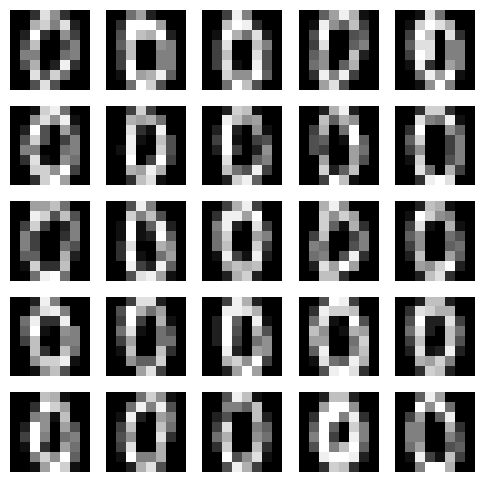

In [17]:
dataset = DigitsDataset(
    csv_file="D:\helpers\optdigits_csv (1).csv",
    label=0,
    transform=transforms.Compose([transforms.ToTensor()]),
)
sampler = RandomSampler(dataset, replacement=True, num_samples=25)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, drop_last=True, sampler=sampler
)

ax = plt.figure(figsize=(6, 6))
for index, image in enumerate(iter(dataloader)):
    plt.subplot(5, 5, index +   1)
    plt.imshow(image[0][0][0], cmap="gray")
    plt.axis("off")

In [28]:
def get_archstring(arch):
    return "".join([re.sub(r'[0-9]|\]|\[', '', s) for s in arch.copy()])

architectures = [
        ["var", "enc[2]", "var"],
        ["var", "var", "enc[2]", "var", "var"],
        ["var", "enc[1]", "var", "enc[3]", "var"],
        ["var", "var", "enc[1]", "var", "var", "enc[3]", "var", "var"],
        ["var", "enc[0]", "var", "enc[2]", "var", "enc[4]", "var"],
        ["var", "enc[1]", "var", "enc[3]", "var", "enc[5]", "var", "enc[7]", "var"],
]
archstrings = [get_archstring(s) for s in architectures]

In [29]:
def plot_loss(loss_in, ax):
    
    arr = np.asarray(loss_in)
    ax.clear()

    if arr.size == 0:
        ax.text(0.5, 0.5, "No loss data", ha="center", va="center", transform=ax.transAxes)
        ax.set_title("Loss Evolution"); ax.set_xlabel("Iteration"); ax.set_ylabel("Loss Value")
        return

    if arr.ndim == 2:  # (steps,2)
        D = arr[:, 0] / 2.0
        G = arr[:, 1]
        ax.plot(D, label="D Loss")
        ax.plot(G, label="G Loss")
    elif arr.ndim == 3:  # (runs,steps,2)
        D = arr[:, :, 0] / 2.0
        G = arr[:, :, 1]
        ax.plot(D.T, alpha=0.15, lw=1)
        ax.plot(G.T, alpha=0.15, lw=1)
        ax.plot(D.mean(axis=0), label="D Loss (mean)", lw=2)
        ax.plot(G.mean(axis=0), label="G Loss (mean)", lw=2)
    else:
        ax.text(0.5, 0.5, f"Unexpected loss shape: {arr.shape}", ha="center", va="center", transform=ax.transAxes)

    ax.set_title("Loss Evolution")
    ax.set_xlabel("Iteration"); ax.set_ylabel("Loss Value"); ax.legend()

In [30]:
def _autocontrast_row(v, eps=1e-6, tol=5e-3):
    x = np.asarray(v, dtype=np.float32)
    x = np.nan_to_num(x, nan=0.0, posinf=1.0, neginf=0.0)
    # light squash if clearly outside [0,1]
    if x.min() < 0.0 or x.max() > 1.0:
        x = 1.0 / (1.0 + np.exp(-x))
    x_min, x_max = float(x.min()), float(x.max())
    span = x_max - x_min
    if span >= tol:
        y = (x - x_min) / max(span, eps)
    else:
        xc  = x - x.mean()
        std = float(xc.std())
        y   = (xc / max(std, eps)) * 0.15 + 0.5
    return np.clip(y, 0.0, 1.0)

def _autocontrast_rows(arr):
    if arr.size == 0: return arr
    return np.stack([_autocontrast_row(r) for r in np.asarray(arr)], axis=0)

def _render_from_fake(fake_arr, axes):
    if fake_arr is None or fake_arr.size == 0 or len(axes) == 0:
        for ax in axes: ax.axis("off")
        return
    arr = np.asarray(fake_arr)
    if arr.ndim != 2:
        arr = arr.reshape(-1, arr.shape[-1])
    steps, pixels = arr.shape
    k = len(axes)
    idxs = np.linspace(max(1, steps // 3), steps, num=k, endpoint=True, dtype=int) - 1
    idxs = np.clip(np.unique(idxs), 0, steps - 1)
    if len(idxs) < k:
        idxs = np.pad(idxs, (0, k - len(idxs)), mode="edge")
    for ax, t in zip(axes, idxs):
        img = _autocontrast_row(arr[t])
        img8 = np.clip(img * 255.0, 0, 255).astype(np.uint8).reshape(8, 8)
        ax.imshow(img8, cmap="gray"); ax.axis("off")

In [31]:


def plot_progress(fake_runs, axes):
 
    arr = np.asarray(fake_runs)

    # clear axes
    for ax in axes:
        ax.clear()
        ax.axis("off")

    if arr.size == 0 or len(axes) == 0:
        return

    # unify to (runs, steps, pixels)
    if arr.ndim == 2:          # single run
        arr = arr[None, ...]   # -> (1, steps, pixels)
    elif arr.ndim != 3:
        axes[0].text(0.5, 0.5, f"Unexpected shape: {arr.shape}",
                     ha="center", va="center", transform=axes[0].transAxes)
        return

    runs, steps, pixels = arr.shape

    # optional smoothing like your original code
    if steps >= 4:
        chunks = [arr[:, i::4, :] for i in range(4)]              # list of (runs, ceil(steps/4), pixels)
        fake_mean = np.mean(np.mean(np.array(chunks), axis=0), axis=0)  # -> (ceil(steps/4), pixels)
    else:
        fake_mean = arr.mean(axis=0)  # (steps, pixels)

    steps2 = fake_mean.shape[0]
    k = len(axes)

    # choose exactly k evenly spaced snapshot indices
    idxs = np.linspace(1, steps2, num=k, endpoint=True, dtype=int) - 1
    idxs = np.clip(np.unique(idxs), 0, steps2 - 1)
    if len(idxs) < k:  # pad if uniq collapsed
        idxs = np.pad(idxs, (0, k - len(idxs)), mode="edge")

    for ax, t in zip(axes, idxs):
        img = _autocontrast_row(fake_mean[t])  # (pixels,) in [0,1]
        img8 = np.clip(img * 255.0, 0, 255).astype(np.uint8).reshape(8, 8)
        ax.imshow(img8, cmap="gray")
        ax.set_title(f"Iter {t}", fontsize=10)
        ax.axis("off")

    # row title
    axes[0].text(0.0, 1.10, "Image Evolution",
                 transform=axes[0].transAxes, ha="left", va="bottom", fontsize=12)




In [32]:
def plot_results(params_runs, config, axes, best_run=None):
  
    if not axes:
        return
    for ax in axes:
        ax.clear(); ax.axis("off")

    if not params_runs:
        axes[0].set_title("Generated Images", fontsize=14, pad=10)
        return

    qgan = QGAN(
        image_size=8,
        gen_count=config["gen_count"],
        gen_arch=config["arch"],
        input_state=pcvl.BasicState(config["input_state"]),
        noise_dim=config["noise_dim"],
        batch_size=4,
        pnr=config["pnr"],
        lossy=False,
    )
    qgan.G.eval()

    # Helper: set params into generator even if update_var_params isn't provided
    def _apply_params_to_G(vec):
        if hasattr(qgan.G, "update_var_params"):
            qgan.G.update_var_params(vec)
            return True
        # Try to push into each sublayer.theta if lengths match
        if hasattr(qgan.G, "layers"):
            thetas = [getattr(L, "theta", None) for L in qgan.G.layers]
            flat_thetas = [t.view(-1) for t in thetas if isinstance(t, torch.Tensor)]
            total = sum(t.numel() for t in flat_thetas)
            v = torch.as_tensor(vec, dtype=torch.float32, device=qgan.device)
            if v.numel() == total:
                offset = 0
                for t in thetas:
                    if isinstance(t, torch.Tensor):
                        n = t.numel()
                        t.data.copy_(v[offset:offset+n].view_as(t))
                        offset += n
                return True
        return False

    # --- Generate samples for each run
    device = qgan.device
    num_axes = len(axes)
    final_results = []  # list of (num_axes, 64)
    for params in params_runs:
        p = np.asarray(params)
        p = p[-1] if p.ndim == 2 else p  # last snapshot if (T,P)

        _apply_params_to_G(p)

        # New noise per axis for diversity
        z = torch.randn(num_axes, qgan.latent_dim, device=device)
        with torch.no_grad():
            # G returns (-1,1); map to [0,1] for display
            out = qgan.G(z)                                # (N, 64) in (-1,1)
            out01 = ((out + 1.0) * 0.5).clamp(0.0, 1.0)    # [0,1]
            final_results.append(out01.cpu().numpy())

    final_arr = np.stack(final_results, axis=0)  # (runs, num_axes, 64)

    # --- Choose what to show per axis
    rng = np.random.default_rng()
    for i, ax in enumerate(axes):
        if best_run is not None and 0 <= best_run < final_arr.shape[0]:
            run_idx = best_run
        else:
            # pick a different run per axis (no averaging → more variety)
            run_idx = rng.integers(0, final_arr.shape[0])
        image_flat = final_arr[run_idx, i, :]  # (64,)
        img = (np.clip(image_flat, 0.0, 1.0) * 255.0).astype(np.uint8).reshape(8, 8)
        ax.imshow(img, cmap="gray", vmin=0, vmax=1)
        ax.axis("off")

    axes[0].set_title("Generated Images", fontsize=14, pad=10)


In [ ]:
from numpy.random import default_rng

varencvar


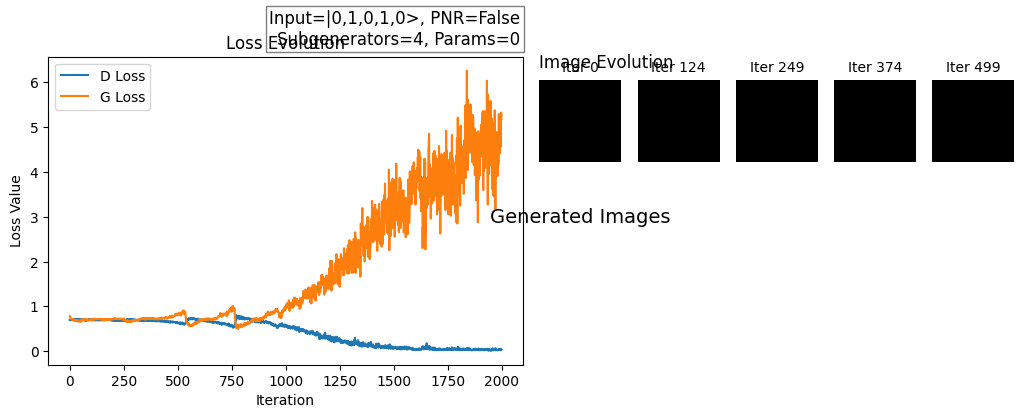

varvarencvarvar


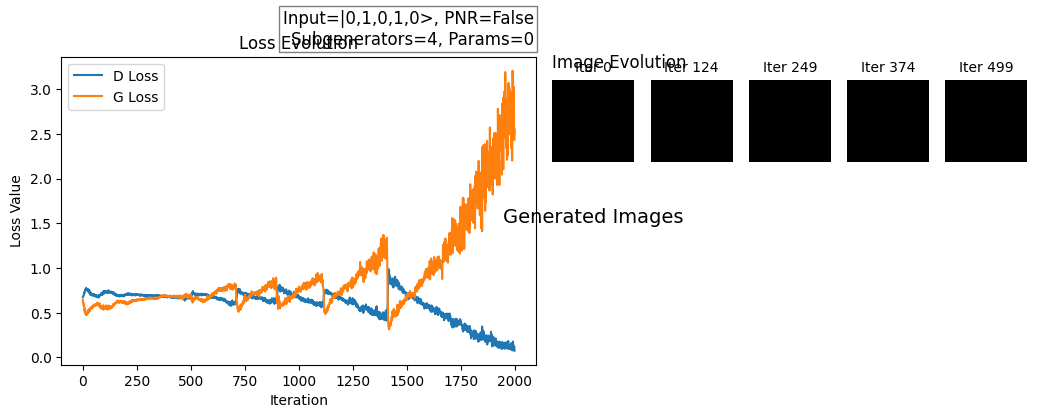

varencvarencvar


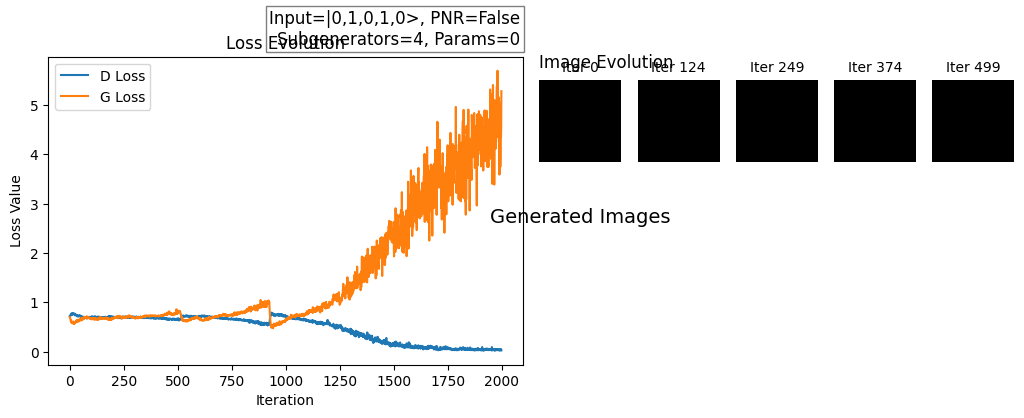

varvarencvarvarencvarvar


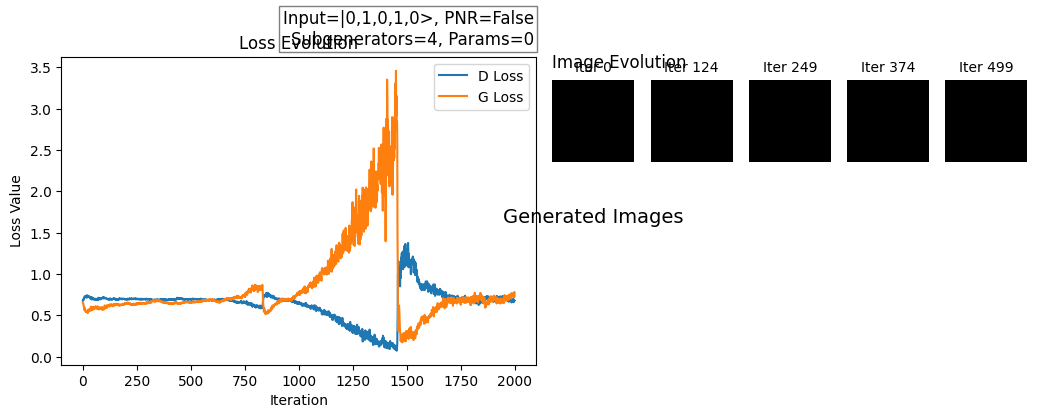

varencvarencvarencvar


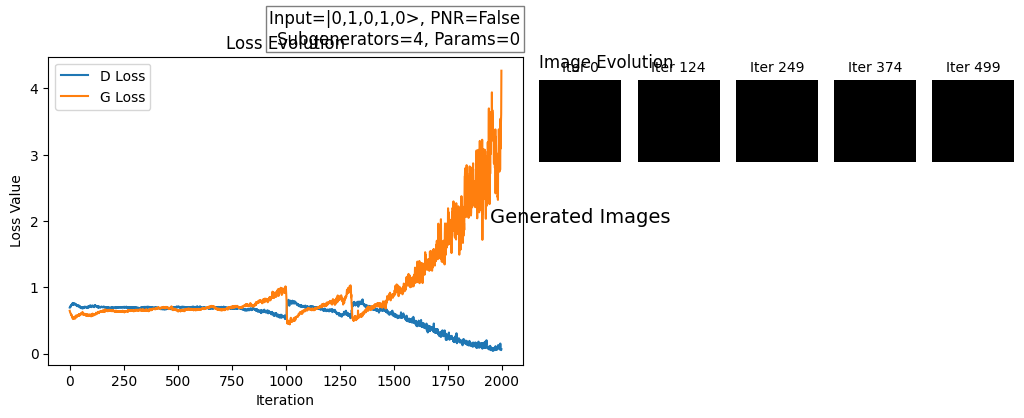

varencvarencvarencvarencvar


In [33]:
RUN = 1  # fixed

for archstring in archstrings:
    print(archstring)
    for config_num in range(5):
        config_path = os.path.join(path, f"config_{config_num}")
        with open(os.path.join(config_path, "config.json")) as c:
            config = json.load(c)

        if get_archstring(config["arch"]) != archstring:
            continue

        full_path   = os.path.join(path, f"config_{config_num}", f"run_{RUN}")
        loss_file   = os.path.join(full_path, "loss_progress.csv")
        fake_file   = os.path.join(full_path, "fake_progress.csv")
        params_file = os.path.join(full_path, "G_params_progress.csv")

        loss_data   = np.loadtxt(loss_file, delimiter=",", skiprows=1) if os.path.exists(loss_file) else np.empty((0,))
        fake_data   = np.loadtxt(fake_file, delimiter=",")            if os.path.exists(fake_file) else np.empty((0,))
        params_data = np.loadtxt(params_file, delimiter=",")          if os.path.exists(params_file) else None

        fig = plt.figure(figsize=(15, 4))
        gs = fig.add_gridspec(2, 12)
        loss_ax   = fig.add_subplot(gs[:, :5])
        prog_axes = [fig.add_subplot(gs[0, 5+i]) for i in range(5)]
        res_axes  = [fig.add_subplot(gs[1, 5+i]) for i in range(5)]

        # loss: pass 2D if single run; otherwise stack if you ever add more runs
        plot_loss(loss_data, loss_ax)

        # progress: expects 2D (steps,pixels) or 3D; we have 2D for run=1
        plot_progress(fake_data, prog_axes)

        # generated images
        params_list = [params_data] if params_data is not None else []
        plot_results(params_list, config, res_axes, best_run=0 if params_list else None)

        n_params = (params_data.shape[-1]) if params_data is not None else 0
        configinfo = (
            f"Input={pcvl.BasicState(config['input_state'])}, PNR={config['pnr']}\n"
            f"Subgenerators={config['gen_count']}, Params={n_params}"
        )
        loss_ax.text(
            x=0.995, y=1.04, s=configinfo, ha="right",
            bbox=dict(boxstyle='square, pad=0.2', facecolor='white', alpha=0.5),
            transform=loss_ax.transAxes, fontsize=12
        )

        plt.subplots_adjust(hspace=0.4)

    plt.show()



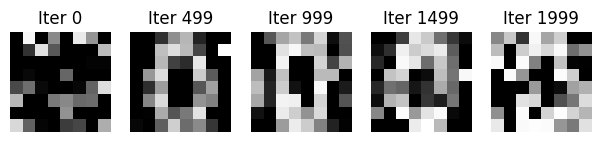

In [34]:
evolution = np.vstack(fake_data_progress)

n_show = 5
steps = np.linspace(0, evolution.shape[0]-1, n_show, dtype=int)
fig, axes = plt.subplots(1, n_show, figsize=(n_show*1.5, 1.5))
for ax, step in zip(axes, steps):  
    img = evolution[step]
    img8 = np.clip(img * 255.0, 0, 255).astype(np.uint8).reshape(8, 8)
    ax.imshow(img8, cmap="gray", vmin=0, vmax=255)
    ax.set_title(f"Iter {step}")
    ax.axis("off")

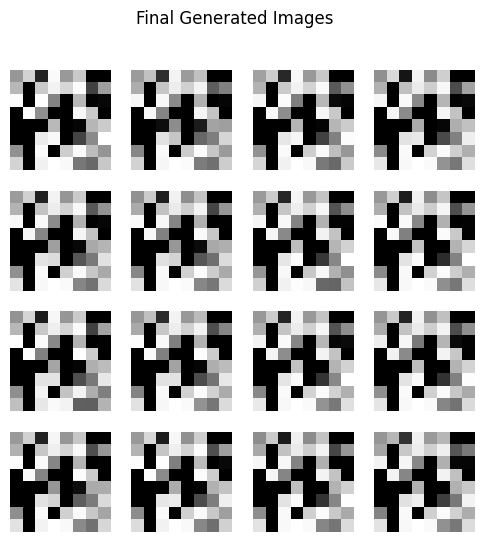

In [37]:
# Generate a batch of new images
z_fixed = torch.randn(16, qgan.latent_dim, device=qgan.device)
with torch.no_grad():
    gen_imgs = qgan.G(z_fixed).cpu().numpy()

fig, axes = plt.subplots(4, 4, figsize=(6,6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(gen_imgs[i].reshape(image_size, image_size), cmap="gray", vmin=0, vmax=1)
    ax.axis("off")
plt.suptitle("Final Generated Images")
plt.show()


In [42]:
import glob
from PIL import Image


varencvar


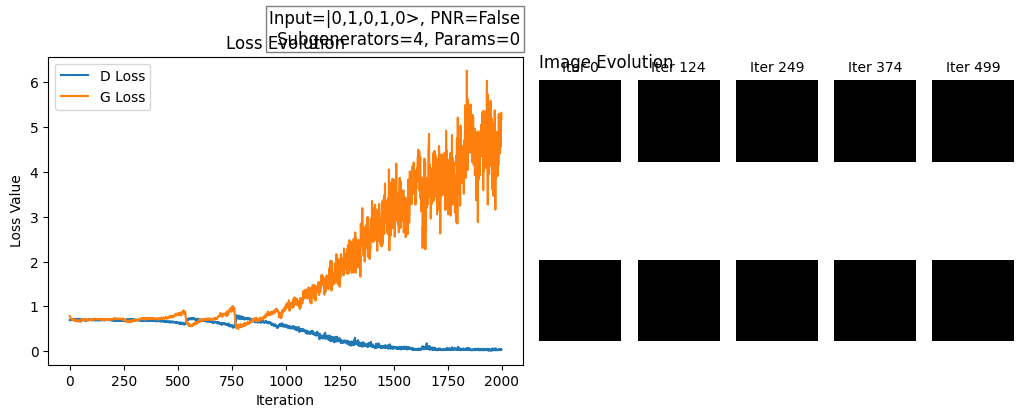

varvarencvarvar


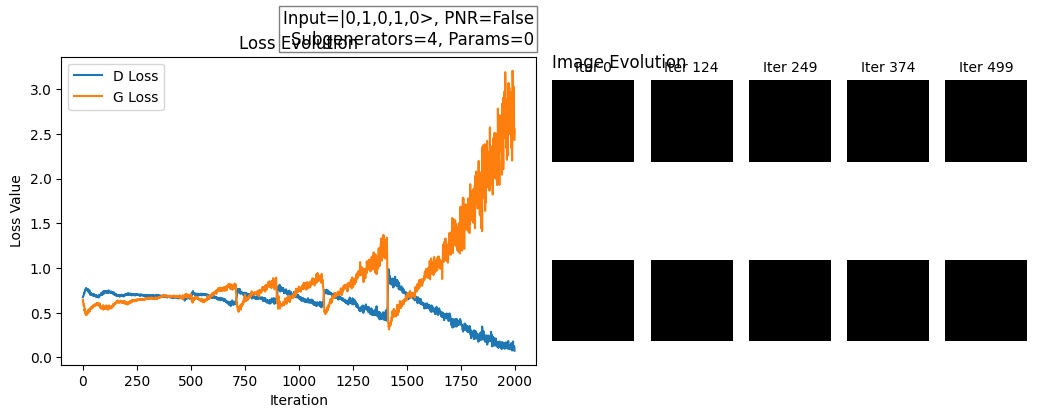

varencvarencvar


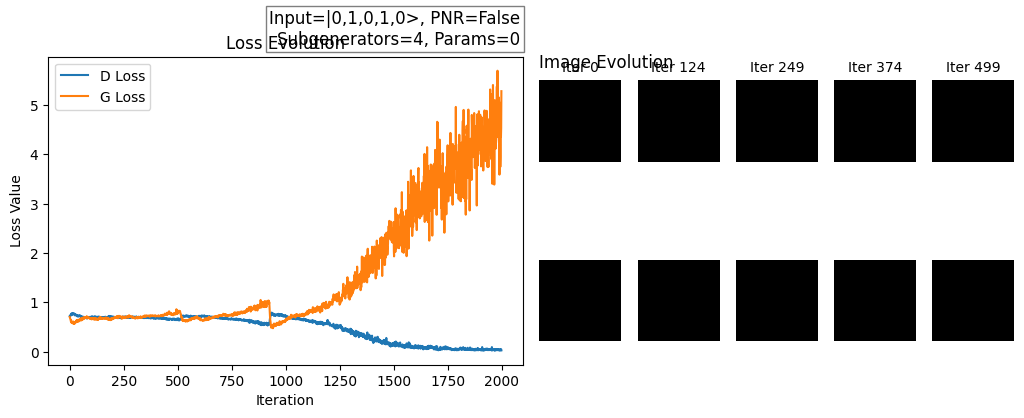

varvarencvarvarencvarvar


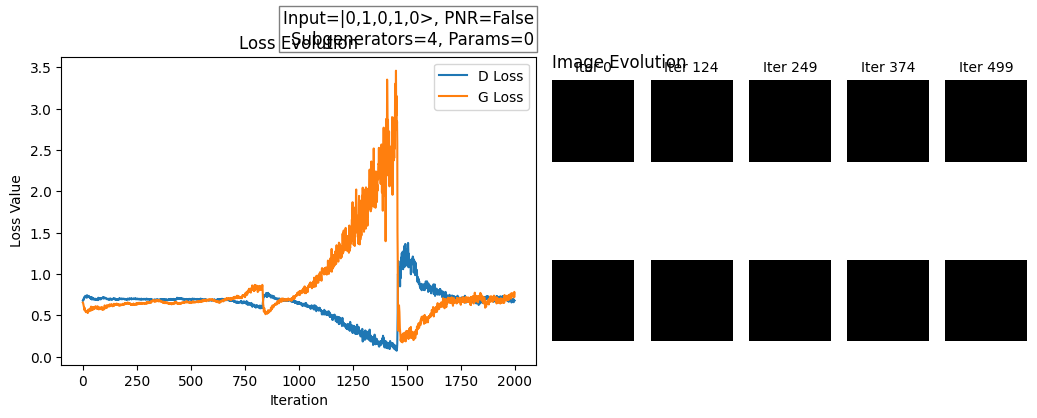

varencvarencvarencvar


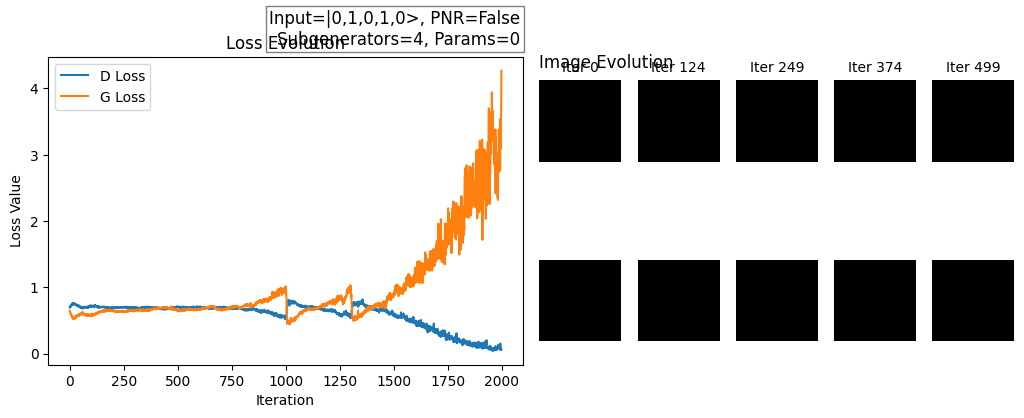

varencvarencvarencvarencvar


In [39]:
RUN = 1  # fixed

for archstring in archstrings:
    print(archstring)
    for config_num in range(5):
        config_path = os.path.join(path, f"config_{config_num}")
        with open(os.path.join(config_path, "config.json")) as c:
            config = json.load(c)

        if get_archstring(config["arch"]) != archstring:
            continue

        full_path   = os.path.join(path, f"config_{config_num}", f"run_{RUN}")
        loss_file   = os.path.join(full_path, "loss_progress.csv")
        fake_file   = os.path.join(full_path, "fake_progress.csv")
        params_file = os.path.join(full_path, "G_params_progress.csv")

        # --- load (single run) ---
        loss_data   = np.loadtxt(loss_file, delimiter=",", skiprows=1) if os.path.exists(loss_file) else np.empty((0, 2))
        fake_data   = np.loadtxt(fake_file, delimiter=",")            if os.path.exists(fake_file) else np.empty((0, 64))
        params_data = np.loadtxt(params_file, delimiter=",")          if os.path.exists(params_file) else None

        # --- normalize shapes defensively ---
        if loss_data.ndim == 1 and loss_data.size >= 2:
            loss_data = loss_data[None, :]  # (1,2)

        if fake_data.ndim == 1:
            fake_data = fake_data[None, :]
        # force to 64 pixels (8x8) when possible
        if fake_data.size and fake_data.shape[1] != 64 and (fake_data.size % 64 == 0):
            steps = fake_data.shape[0]
            fake_data = fake_data.reshape(steps, -1)[:, :64]

        if params_data is not None and params_data.ndim == 1:
            params_data = params_data[None, :]  # (1,P)

        # --- figure & axes ---
        fig = plt.figure(figsize=(15, 4))
        gs = fig.add_gridspec(2, 12)
        loss_ax   = fig.add_subplot(gs[:, :5])
        prog_axes = [fig.add_subplot(gs[0, 5+i]) for i in range(5)]
        res_axes  = [fig.add_subplot(gs[1, 5+i]) for i in range(5)]

        # loss: pass 2D for single run
        plot_loss(loss_data, loss_ax)

        # progress: auto-contrast frames before plotting so they aren't black
        ac_fake = _autocontrast_rows(fake_data) if fake_data.size else fake_data
        plot_progress(ac_fake, prog_axes)

        # generated images:
        params_list = [params_data] if params_data is not None else []
        if params_list and params_list[0] is not None and params_list[0].size:
            # try your original plot_results first (if it regenerates from params)
            try:
                plot_results(params_list, config, res_axes, best_run=0)
            except Exception:
                # fallback to saved fakes if regeneration fails
                _render_from_fake(ac_fake, res_axes)
        else:
            # no params saved (Params=0) -> show saved fakes (auto-contrasted)
            _render_from_fake(ac_fake, res_axes)

        n_params = (params_data.shape[-1]) if params_data is not None else 0
        configinfo = (
            f"Input={pcvl.BasicState(config['input_state'])}, PNR={config['pnr']}\n"
            f"Subgenerators={config['gen_count']}, Params={n_params}"
        )
        loss_ax.text(
            x=0.995, y=1.04, s=configinfo, ha="right",
            bbox=dict(boxstyle='square, pad=0.2', facecolor='white', alpha=0.5),
            transform=loss_ax.transAxes, fontsize=12
        )

        plt.subplots_adjust(hspace=0.4)

    plt.show()